In [1]:


import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

W0819 05:23:07.075372 140276832970624 deprecation.py:323] From <ipython-input-1-4ac721b2bea3>:10: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0819 05:23:07.077167 140276832970624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0819 05:23:07.082615 140276832970624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be remove

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


W0819 05:23:07.450523 140276832970624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0819 05:23:07.527856 140276832970624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


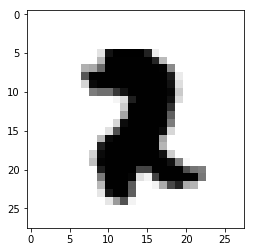

In [2]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

In [0]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

In [0]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [0]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [0]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

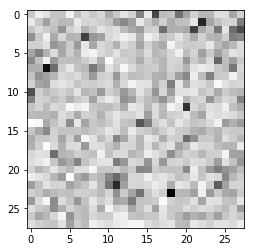

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [0]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

In [9]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

W0819 05:24:47.450717 140276832970624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

In [11]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_b1/beta:0', 'g_w2:0', 'g_b2:0', 'g_b2/beta:0', 'g_w3:0', 'g_b3:0', 'g_b3/beta:0', 'g_w4:0', 'g_b4:0']


In [0]:

# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [0]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.6930457 dLossFake: 0.69313675
dLossReal: 0.0073710326 dLossFake: 0.027546884
dLossReal: 0.0010098547 dLossFake: 0.0028584546
Iteration: 0 at 2019-08-19 05:25:11.306089


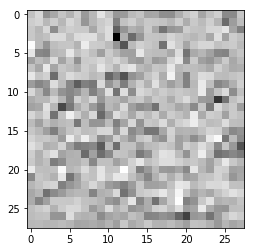

Estimate: [[-6.2568846]]
Iteration: 100 at 2019-08-19 05:25:13.576356


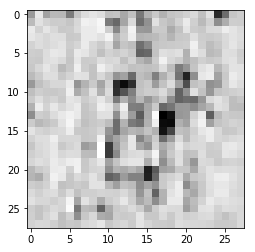

Estimate: [[-5.283568]]
Iteration: 200 at 2019-08-19 05:25:15.870745


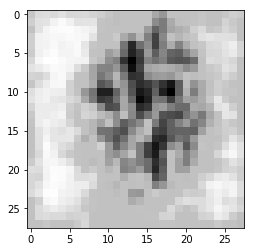

Estimate: [[-6.842762]]
Iteration: 300 at 2019-08-19 05:25:18.164372


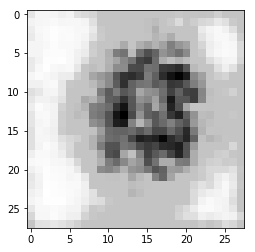

Estimate: [[-4.5143695]]
Iteration: 400 at 2019-08-19 05:25:20.624299


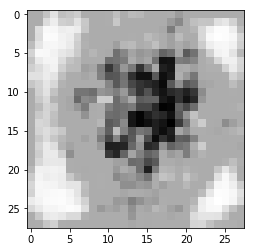

Estimate: [[-6.8420124]]
Iteration: 500 at 2019-08-19 05:25:22.944118


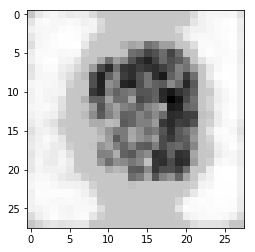

Estimate: [[-7.5045757]]
Iteration: 600 at 2019-08-19 05:25:25.273900


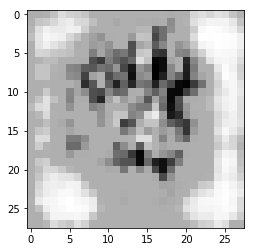

Estimate: [[-7.493763]]
Iteration: 700 at 2019-08-19 05:25:27.617243


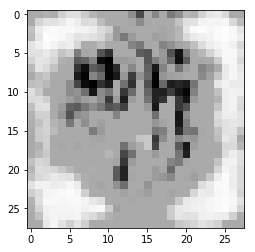

Estimate: [[-7.080582]]
Iteration: 800 at 2019-08-19 05:25:30.058725


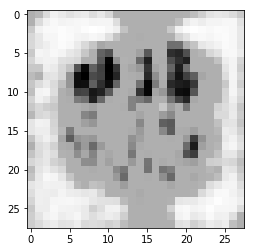

Estimate: [[-6.993741]]
Iteration: 900 at 2019-08-19 05:25:32.410878


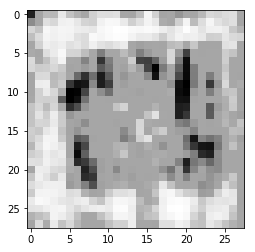

Estimate: [[-5.971228]]
Iteration: 1000 at 2019-08-19 05:25:34.789532


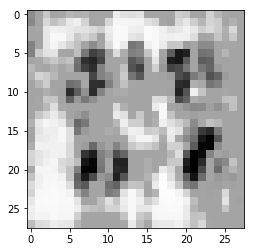

Estimate: [[-7.473092]]
Iteration: 1100 at 2019-08-19 05:25:37.161584


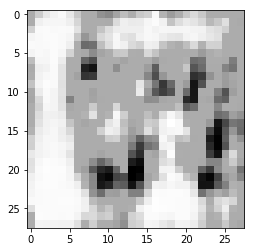

Estimate: [[-5.850554]]
Iteration: 1200 at 2019-08-19 05:25:39.547826


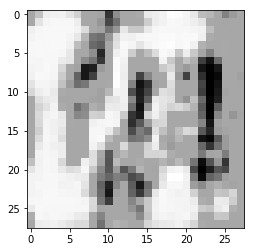

Estimate: [[-7.4726405]]
Iteration: 1300 at 2019-08-19 05:25:41.959596


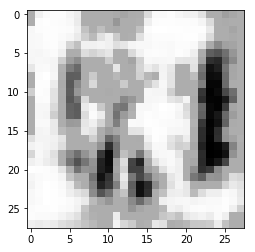

Estimate: [[-1.8064001]]
Iteration: 1400 at 2019-08-19 05:25:44.353960


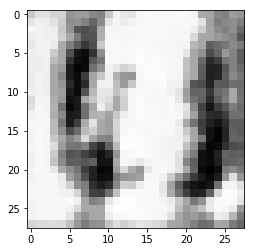

Estimate: [[-9.487144]]
Iteration: 1500 at 2019-08-19 05:25:46.771682


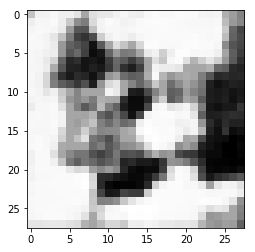

Estimate: [[-12.044328]]
Iteration: 1600 at 2019-08-19 05:25:49.211285


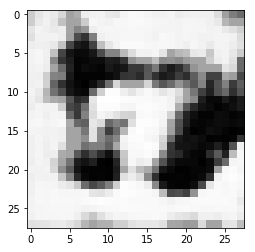

Estimate: [[-8.123438]]
Iteration: 1700 at 2019-08-19 05:25:51.634325


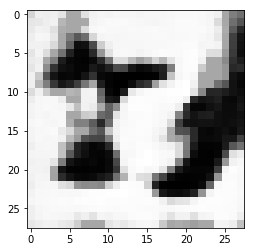

Estimate: [[-8.063498]]
Iteration: 1800 at 2019-08-19 05:25:54.090810


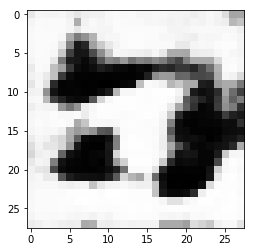

Estimate: [[-6.0784984]]
Iteration: 1900 at 2019-08-19 05:25:56.669207


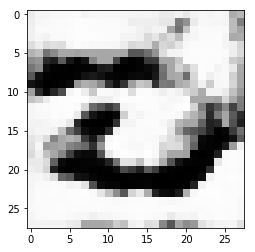

Estimate: [[-7.9587083]]
Iteration: 2000 at 2019-08-19 05:25:59.300749


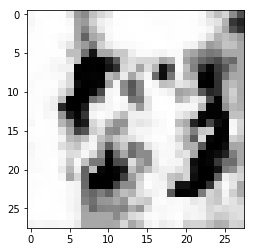

Estimate: [[-7.503067]]
Iteration: 2100 at 2019-08-19 05:26:01.759080


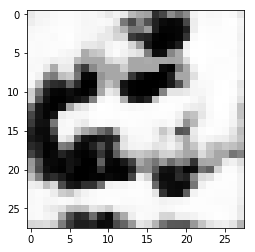

Estimate: [[-16.680939]]
Iteration: 2200 at 2019-08-19 05:26:04.226267


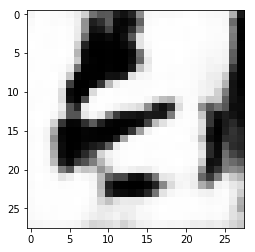

Estimate: [[-18.960993]]
Iteration: 2300 at 2019-08-19 05:26:06.694945


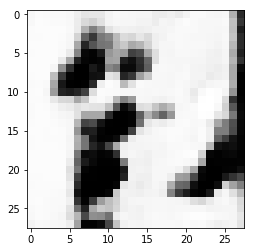

Estimate: [[-27.299154]]
Iteration: 2400 at 2019-08-19 05:26:09.167695


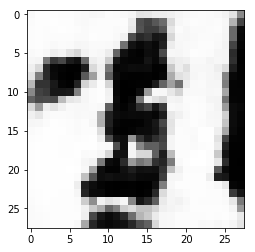

Estimate: [[-6.2435026]]
Iteration: 2500 at 2019-08-19 05:26:11.641221


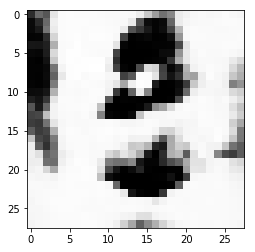

Estimate: [[4.4437456]]
Iteration: 2600 at 2019-08-19 05:26:14.115001


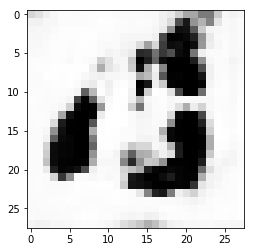

Estimate: [[-19.295801]]
Iteration: 2700 at 2019-08-19 05:26:16.588886


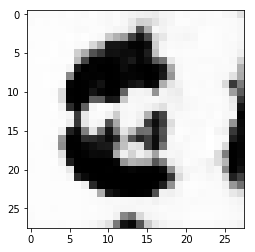

Estimate: [[6.681657]]
Iteration: 2800 at 2019-08-19 05:26:19.067553


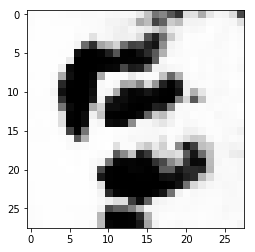

Estimate: [[-5.8784804]]
Iteration: 2900 at 2019-08-19 05:26:21.541859


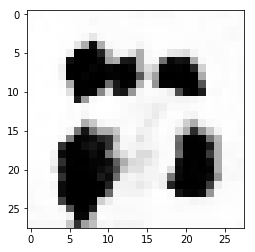

Estimate: [[-11.960977]]
Iteration: 3000 at 2019-08-19 05:26:24.130092


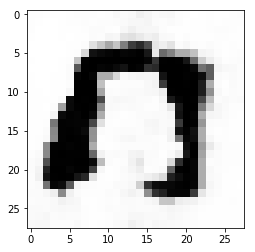

Estimate: [[5.3310776]]
Iteration: 3100 at 2019-08-19 05:26:26.611307


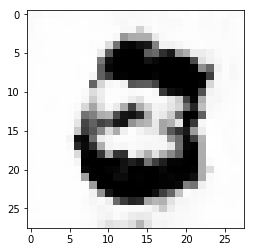

Estimate: [[12.755771]]
Iteration: 3200 at 2019-08-19 05:26:29.097993


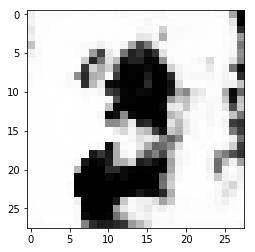

Estimate: [[-21.328255]]
Iteration: 3300 at 2019-08-19 05:26:31.584698


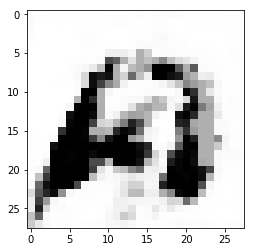

Estimate: [[-10.419885]]
Iteration: 3400 at 2019-08-19 05:26:34.071317


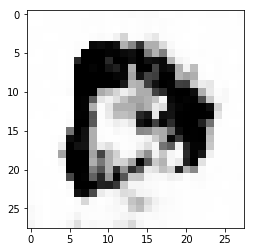

Estimate: [[-12.489041]]
Iteration: 3500 at 2019-08-19 05:26:36.577578


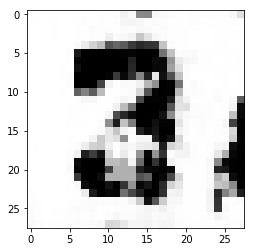

Estimate: [[-21.699753]]
Iteration: 3600 at 2019-08-19 05:26:39.076672


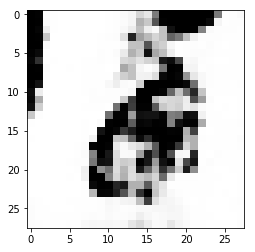

Estimate: [[-6.971858]]
Iteration: 3700 at 2019-08-19 05:26:41.584303


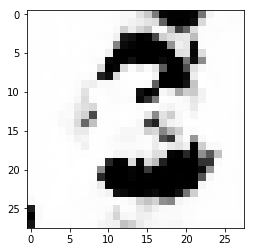

Estimate: [[-10.352739]]
Iteration: 3800 at 2019-08-19 05:26:44.090133


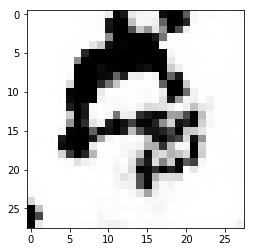

Estimate: [[-11.184571]]
Iteration: 3900 at 2019-08-19 05:26:46.790906


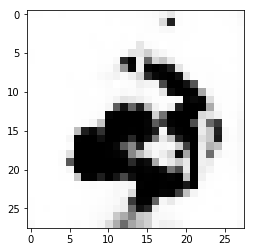

Estimate: [[-7.2981305]]
Iteration: 4000 at 2019-08-19 05:26:49.314751


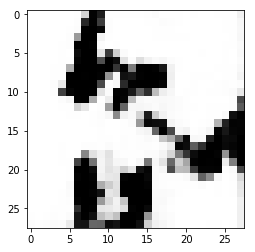

Estimate: [[-12.725829]]
Iteration: 4100 at 2019-08-19 05:26:51.883280


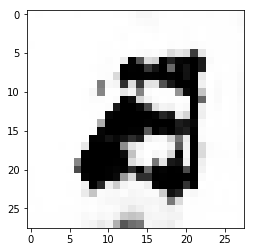

Estimate: [[-8.729235]]
Iteration: 4200 at 2019-08-19 05:26:54.409823


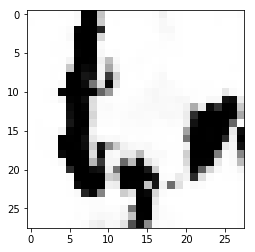

Estimate: [[-8.122]]
Iteration: 4300 at 2019-08-19 05:26:56.932847


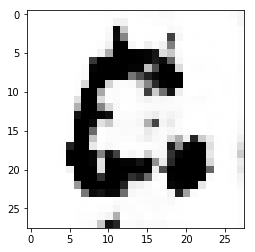

Estimate: [[-7.733077]]
Iteration: 4400 at 2019-08-19 05:26:59.484785


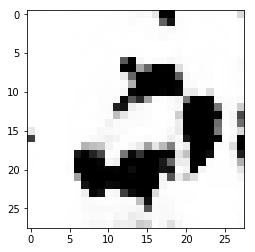

Estimate: [[-10.956807]]
Iteration: 4500 at 2019-08-19 05:27:02.020632


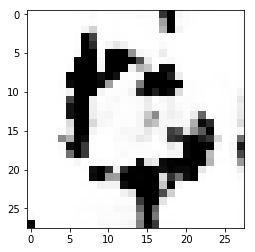

Estimate: [[-16.357561]]
Iteration: 4600 at 2019-08-19 05:27:04.574822


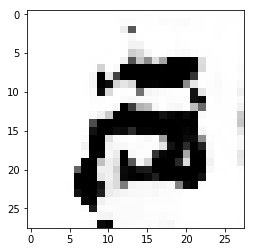

Estimate: [[-0.20092218]]
Iteration: 4700 at 2019-08-19 05:27:07.137582


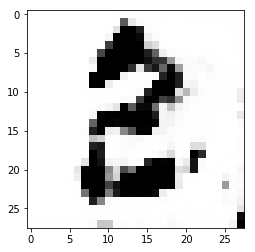

Estimate: [[-5.4733024]]
Iteration: 4800 at 2019-08-19 05:27:09.711740


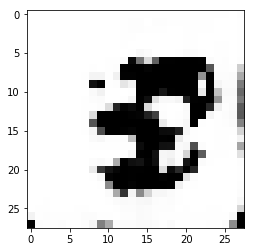

Estimate: [[-8.599387]]
Iteration: 4900 at 2019-08-19 05:27:12.269796


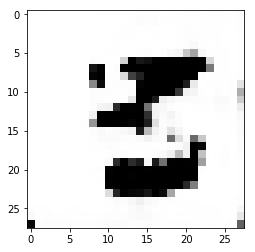

Estimate: [[2.8515213]]
Iteration: 5000 at 2019-08-19 05:27:14.846226


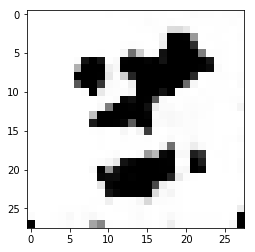

Estimate: [[-4.180972]]
Iteration: 5100 at 2019-08-19 05:27:17.464363


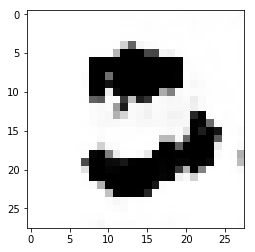

Estimate: [[-8.334456]]
Iteration: 5200 at 2019-08-19 05:27:20.117793


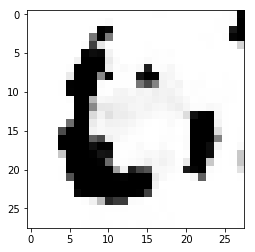

Estimate: [[-8.178039]]
Iteration: 5300 at 2019-08-19 05:27:22.722889


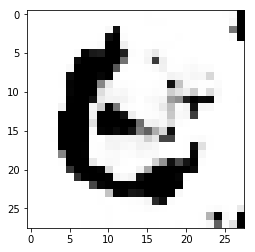

Estimate: [[-2.566112]]
Iteration: 5400 at 2019-08-19 05:27:25.318942


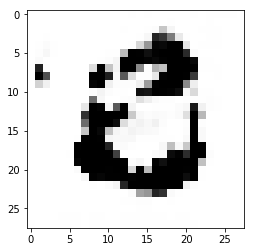

Estimate: [[-1.8127228]]
Iteration: 5500 at 2019-08-19 05:27:27.927269


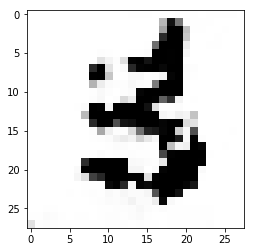

Estimate: [[-5.920923]]
Iteration: 5600 at 2019-08-19 05:27:30.542077


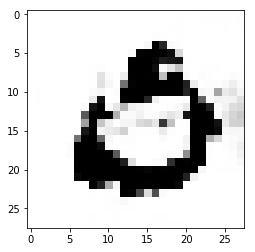

Estimate: [[2.5233705]]
Iteration: 5700 at 2019-08-19 05:27:33.177789


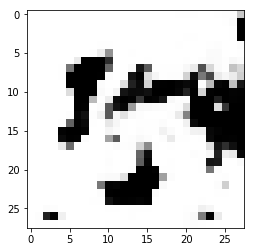

Estimate: [[-4.577233]]
Iteration: 5800 at 2019-08-19 05:27:35.795781


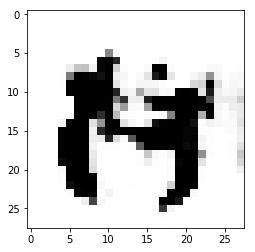

Estimate: [[1.4248953]]
Iteration: 5900 at 2019-08-19 05:27:38.427496


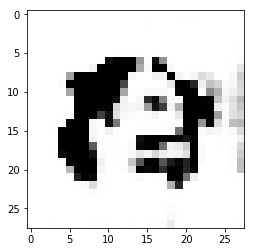

Estimate: [[2.796865]]
Iteration: 6000 at 2019-08-19 05:27:41.069193


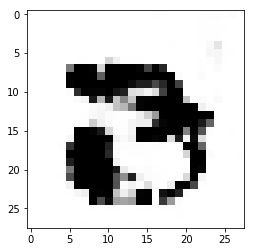

Estimate: [[-1.008671]]
Iteration: 6100 at 2019-08-19 05:27:43.931529


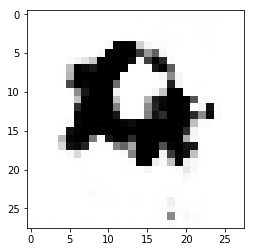

Estimate: [[0.6688635]]
Iteration: 6200 at 2019-08-19 05:27:46.581716


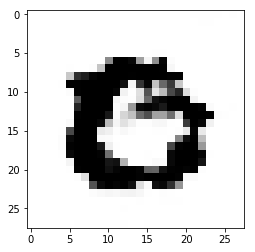

Estimate: [[1.4742153]]
Iteration: 6300 at 2019-08-19 05:27:49.284276


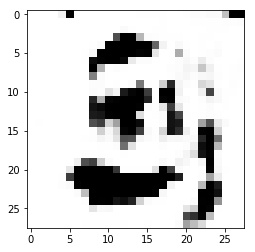

Estimate: [[-5.920694]]
Iteration: 6400 at 2019-08-19 05:27:51.955278


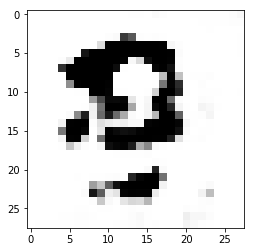

Estimate: [[0.31328905]]
Iteration: 6500 at 2019-08-19 05:27:54.627760


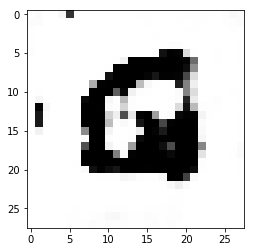

Estimate: [[3.7288356]]
Iteration: 6600 at 2019-08-19 05:27:57.300399


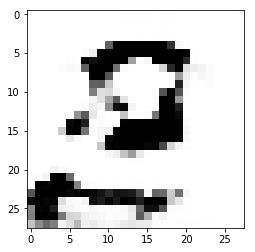

Estimate: [[0.16894197]]
Iteration: 6700 at 2019-08-19 05:27:59.992441


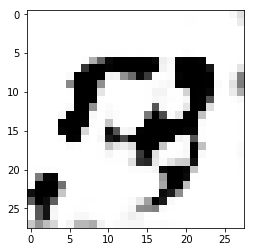

Estimate: [[-1.240927]]
Iteration: 6800 at 2019-08-19 05:28:02.687168


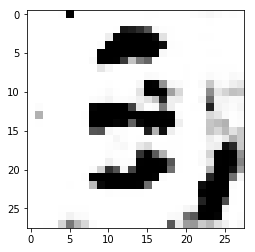

Estimate: [[-2.6509185]]
Iteration: 6900 at 2019-08-19 05:28:05.371603


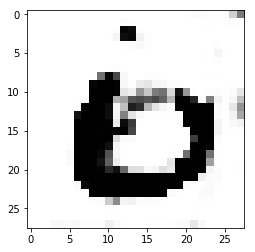

Estimate: [[-2.6446836]]
Iteration: 7000 at 2019-08-19 05:28:08.061521


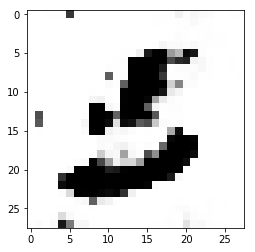

Estimate: [[-2.5599868]]
Iteration: 7100 at 2019-08-19 05:28:10.754958


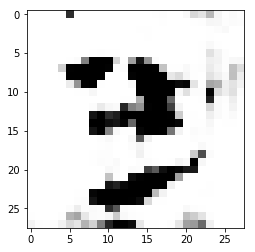

Estimate: [[-3.8430839]]
Iteration: 7200 at 2019-08-19 05:28:13.458540


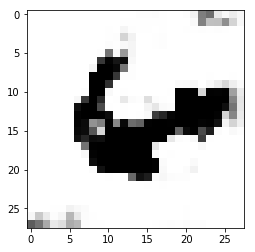

Estimate: [[-1.3853605]]
Iteration: 7300 at 2019-08-19 05:28:16.160129


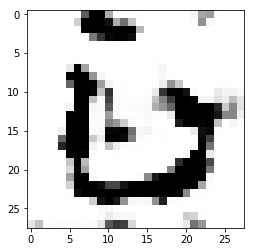

Estimate: [[-2.1111143]]
Iteration: 7400 at 2019-08-19 05:28:18.931037


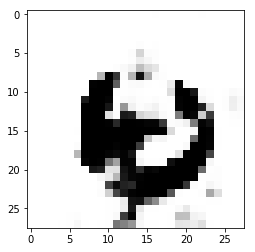

Estimate: [[-5.9826617]]
Iteration: 7500 at 2019-08-19 05:28:21.643019


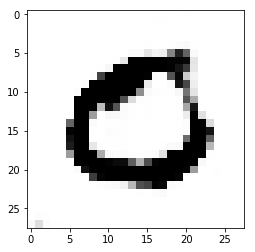

Estimate: [[-3.2312634]]
Iteration: 7600 at 2019-08-19 05:28:24.376419


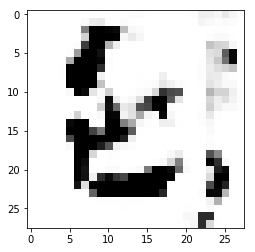

Estimate: [[-7.6384196]]
Iteration: 7700 at 2019-08-19 05:28:27.105606


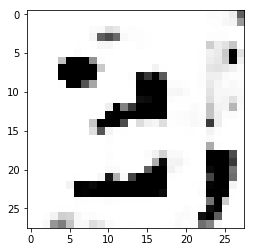

Estimate: [[-0.51294315]]
Iteration: 7800 at 2019-08-19 05:28:29.853606


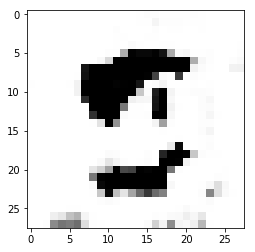

Estimate: [[-4.432093]]
Iteration: 7900 at 2019-08-19 05:28:32.585265


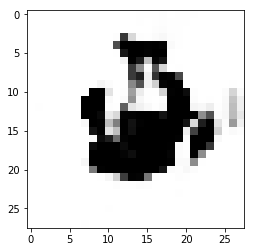

Estimate: [[-5.3284974]]
Iteration: 8000 at 2019-08-19 05:28:35.314745


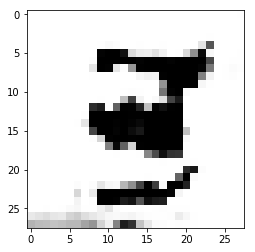

Estimate: [[2.7651386]]
Iteration: 8100 at 2019-08-19 05:28:38.072064


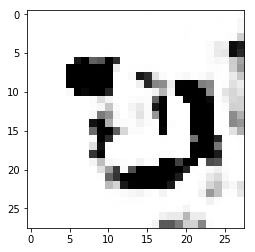

Estimate: [[-3.2324798]]
Iteration: 8200 at 2019-08-19 05:28:40.819738


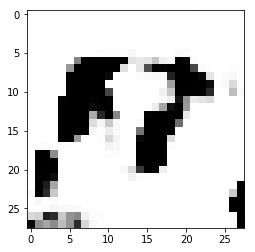

Estimate: [[1.72397]]
Iteration: 8300 at 2019-08-19 05:28:43.578254


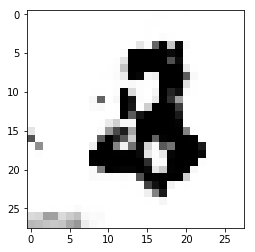

Estimate: [[-5.4495325]]
Iteration: 8400 at 2019-08-19 05:28:46.338648


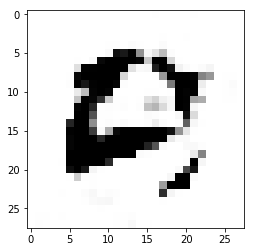

Estimate: [[-2.3398294]]
Iteration: 8500 at 2019-08-19 05:28:49.170083


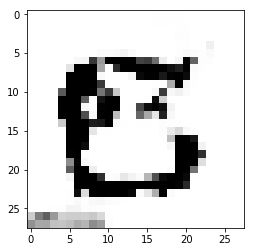

Estimate: [[-2.4370153]]
Iteration: 8600 at 2019-08-19 05:28:52.185584


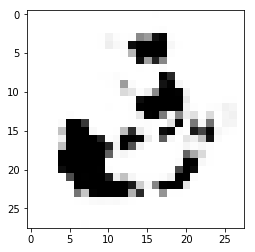

Estimate: [[-4.069691]]
Iteration: 8700 at 2019-08-19 05:28:54.961396


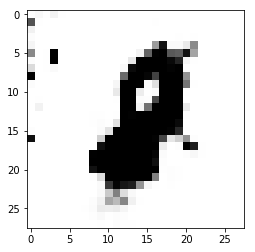

Estimate: [[0.90943]]
Iteration: 8800 at 2019-08-19 05:28:57.759031


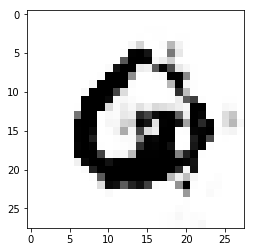

Estimate: [[-4.627457]]
Iteration: 8900 at 2019-08-19 05:29:00.548419


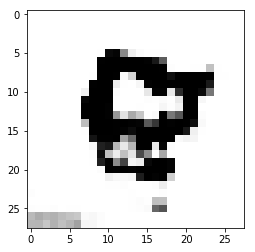

Estimate: [[-1.3998935]]
Iteration: 9000 at 2019-08-19 05:29:03.382780


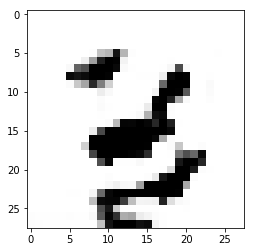

Estimate: [[-9.34394]]
Iteration: 9100 at 2019-08-19 05:29:06.220071


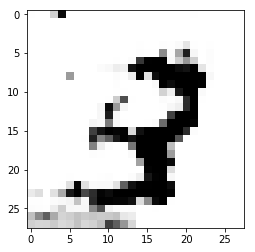

Estimate: [[1.2316006]]
Iteration: 9200 at 2019-08-19 05:29:09.056073


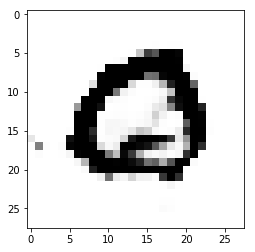

Estimate: [[-0.87245816]]
Iteration: 9300 at 2019-08-19 05:29:11.894765


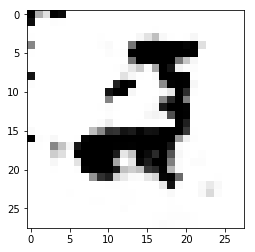

Estimate: [[-4.990356]]
Iteration: 9400 at 2019-08-19 05:29:14.705424


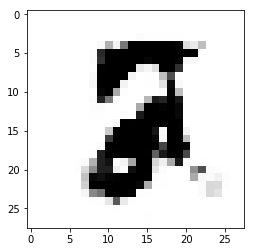

Estimate: [[0.7623165]]
Iteration: 9500 at 2019-08-19 05:29:17.549504


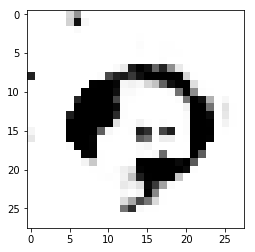

Estimate: [[1.9441754]]
Iteration: 9600 at 2019-08-19 05:29:20.432483


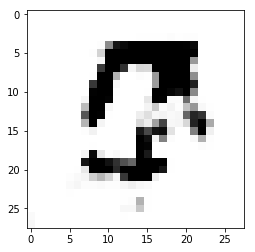

Estimate: [[-2.8698952]]
Iteration: 9700 at 2019-08-19 05:29:23.278633


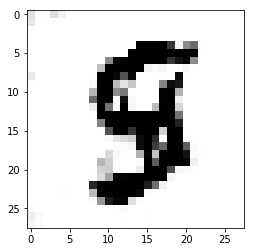

Estimate: [[-2.8148253]]
Iteration: 9800 at 2019-08-19 05:29:26.132192


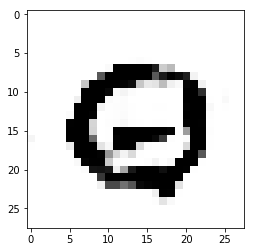

Estimate: [[-1.4468615]]
Iteration: 9900 at 2019-08-19 05:29:28.980794


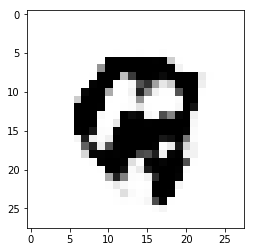

Estimate: [[0.22741532]]
Iteration: 10000 at 2019-08-19 05:29:31.848753


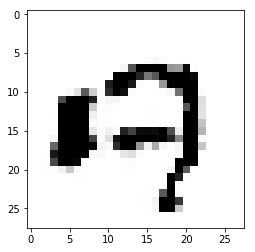

Estimate: [[-3.7754323]]
Iteration: 10100 at 2019-08-19 05:29:34.696514


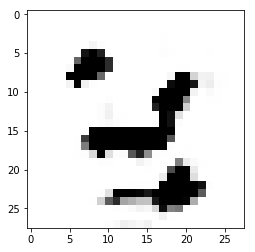

Estimate: [[-2.5801978]]
Iteration: 10200 at 2019-08-19 05:29:37.576131


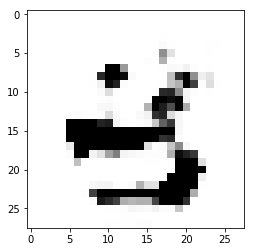

Estimate: [[-3.8996916]]
Iteration: 10300 at 2019-08-19 05:29:40.448211


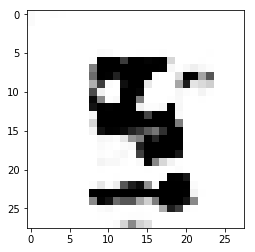

Estimate: [[-4.3465433]]
Iteration: 10400 at 2019-08-19 05:29:43.328108


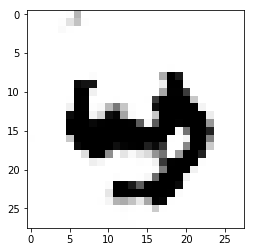

Estimate: [[1.1153556]]
Iteration: 10500 at 2019-08-19 05:29:46.216757


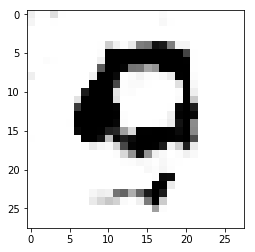

Estimate: [[-2.4351585]]
Iteration: 10600 at 2019-08-19 05:29:49.144158


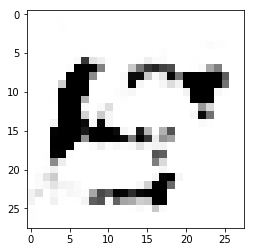

Estimate: [[-10.074871]]
Iteration: 10700 at 2019-08-19 05:29:52.116589


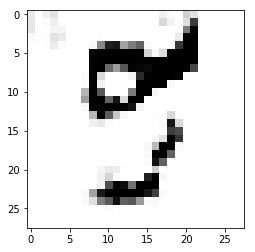

Estimate: [[3.7189305]]
Iteration: 10800 at 2019-08-19 05:29:55.026765


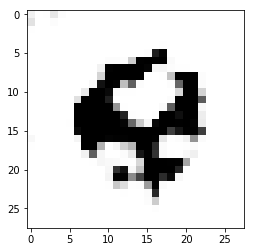

Estimate: [[-8.378577]]
Iteration: 10900 at 2019-08-19 05:29:57.936508


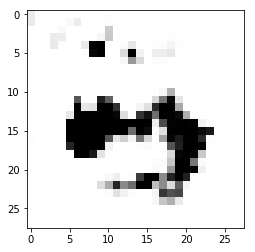

Estimate: [[-2.1422992]]
Iteration: 11000 at 2019-08-19 05:30:00.851834


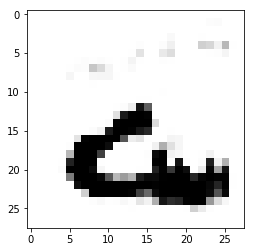

Estimate: [[11.377262]]
Iteration: 11100 at 2019-08-19 05:30:03.794425


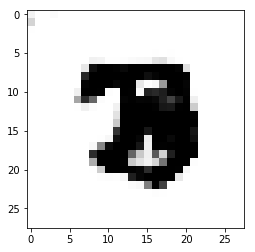

Estimate: [[3.3619554]]
Iteration: 11200 at 2019-08-19 05:30:06.732825


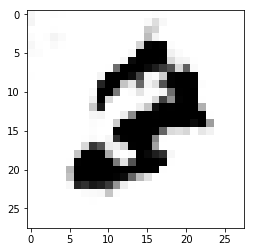

Estimate: [[1.1017272]]
Iteration: 11300 at 2019-08-19 05:30:09.680372


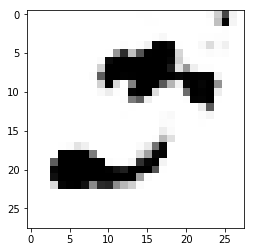

Estimate: [[-3.2326093]]
Iteration: 11400 at 2019-08-19 05:30:12.635095


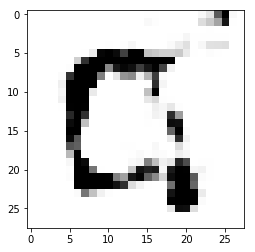

Estimate: [[-1.4250774]]
Iteration: 11500 at 2019-08-19 05:30:15.831542


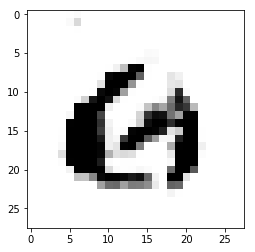

Estimate: [[-13.393694]]
Iteration: 11600 at 2019-08-19 05:30:18.774873


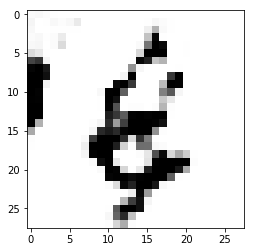

Estimate: [[-2.6967912]]
Iteration: 11700 at 2019-08-19 05:30:21.736405


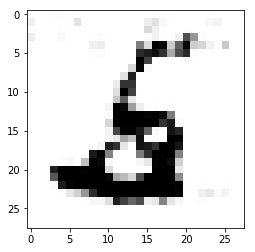

Estimate: [[-0.6777093]]
Iteration: 11800 at 2019-08-19 05:30:24.776893


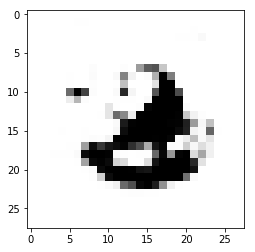

Estimate: [[-5.240041]]
Iteration: 11900 at 2019-08-19 05:30:27.768457


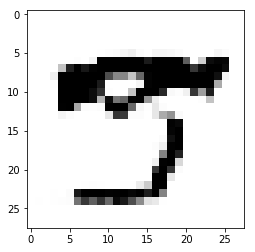

Estimate: [[-1.5075015]]
Iteration: 12000 at 2019-08-19 05:30:30.766297


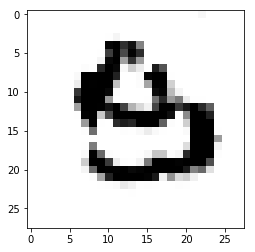

Estimate: [[-2.3032794]]
Iteration: 12100 at 2019-08-19 05:30:33.734644


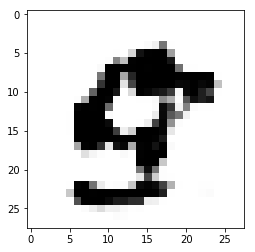

Estimate: [[-14.393905]]
Iteration: 12200 at 2019-08-19 05:30:36.734504


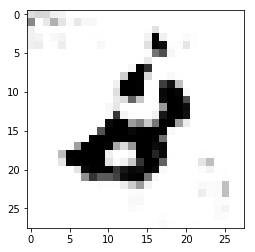

Estimate: [[-3.6156719]]
Iteration: 12300 at 2019-08-19 05:30:39.746938


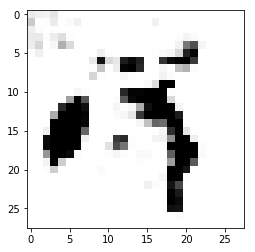

Estimate: [[6.366167]]
Iteration: 12400 at 2019-08-19 05:30:42.776614


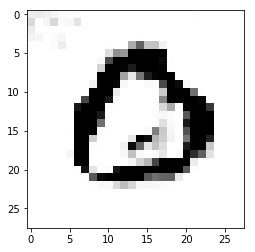

Estimate: [[-1.2801359]]
Iteration: 12500 at 2019-08-19 05:30:45.797194


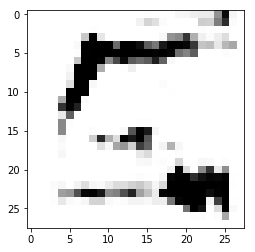

Estimate: [[-12.547632]]
Iteration: 12600 at 2019-08-19 05:30:48.810509


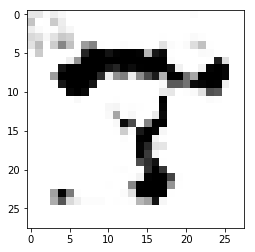

Estimate: [[0.0335357]]
Iteration: 12700 at 2019-08-19 05:30:51.857233


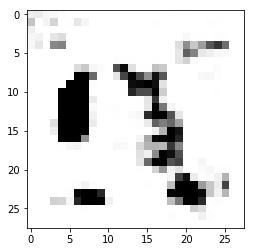

Estimate: [[-0.19479725]]
Iteration: 12800 at 2019-08-19 05:30:54.905789


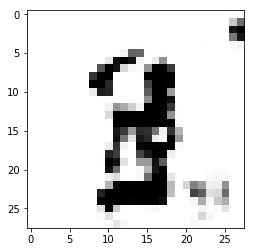

Estimate: [[4.4381065]]
Iteration: 12900 at 2019-08-19 05:30:58.004847


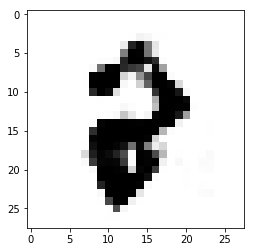

Estimate: [[1.9427692]]
Iteration: 13000 at 2019-08-19 05:31:01.031214


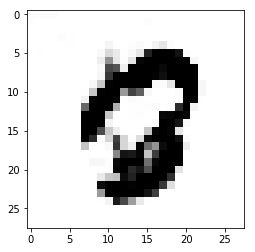

Estimate: [[-4.9027405]]
Iteration: 13100 at 2019-08-19 05:31:04.091293


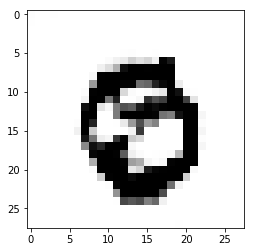

Estimate: [[7.0196953]]
Iteration: 13200 at 2019-08-19 05:31:07.128437


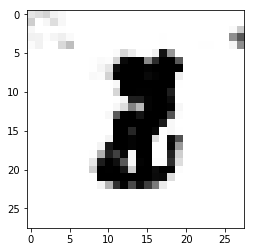

Estimate: [[-2.9018364]]
Iteration: 13300 at 2019-08-19 05:31:10.191508


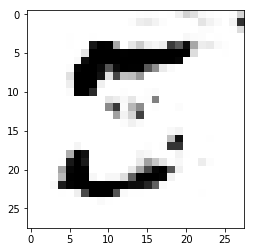

Estimate: [[-4.6093693]]
Iteration: 13400 at 2019-08-19 05:31:13.243096


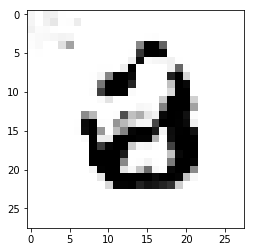

Estimate: [[0.7040817]]
Iteration: 13500 at 2019-08-19 05:31:16.302006


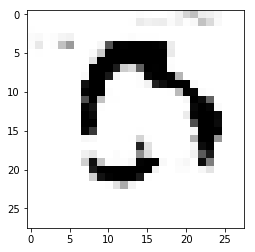

Estimate: [[2.8183465]]
Iteration: 13600 at 2019-08-19 05:31:19.361353


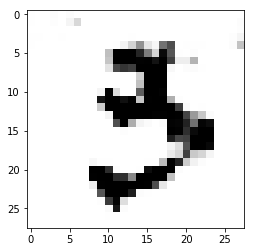

Estimate: [[-7.558733]]
Iteration: 13700 at 2019-08-19 05:31:22.437353


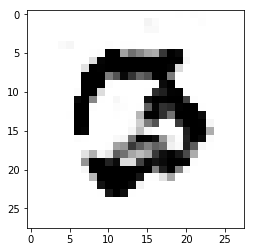

Estimate: [[-2.6698928]]
Iteration: 13800 at 2019-08-19 05:31:25.529634


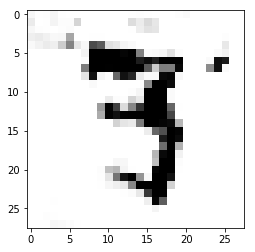

Estimate: [[0.43362433]]
Iteration: 13900 at 2019-08-19 05:31:28.611868


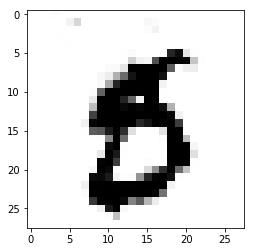

Estimate: [[1.561147]]
Iteration: 14000 at 2019-08-19 05:31:31.793000


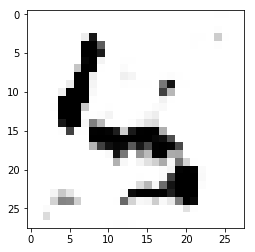

Estimate: [[-7.6324162]]
Iteration: 14100 at 2019-08-19 05:31:34.894083


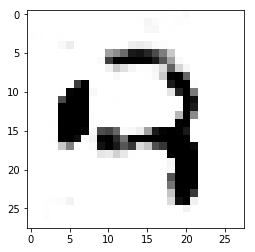

Estimate: [[-0.9840828]]
Iteration: 14200 at 2019-08-19 05:31:38.017888


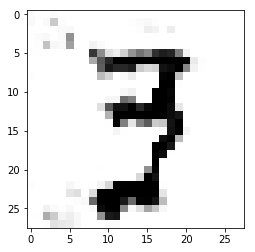

Estimate: [[0.82439303]]
Iteration: 14300 at 2019-08-19 05:31:41.126131


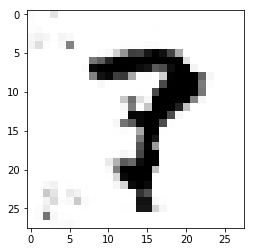

Estimate: [[10.853736]]
Iteration: 14400 at 2019-08-19 05:31:44.273263


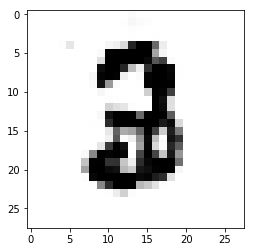

Estimate: [[-7.1511464]]
Iteration: 14500 at 2019-08-19 05:31:47.401246


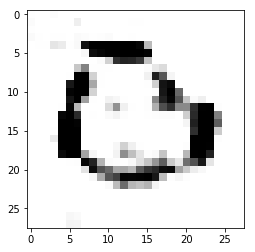

Estimate: [[-1.2017027]]
Iteration: 14600 at 2019-08-19 05:31:50.539277


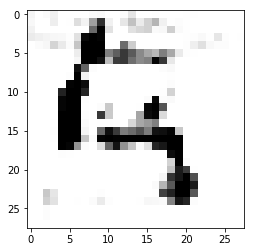

Estimate: [[-1.8971093]]
Iteration: 14700 at 2019-08-19 05:31:53.668779


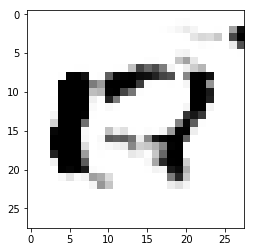

Estimate: [[-7.111543]]
Iteration: 14800 at 2019-08-19 05:31:56.808909


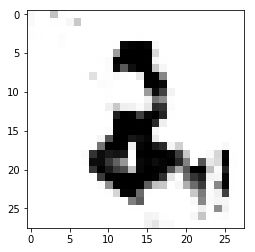

Estimate: [[-0.19692343]]
Iteration: 14900 at 2019-08-19 05:32:00.258746


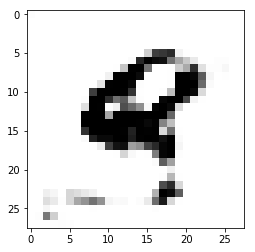

Estimate: [[0.89787674]]
Iteration: 15000 at 2019-08-19 05:32:03.409362


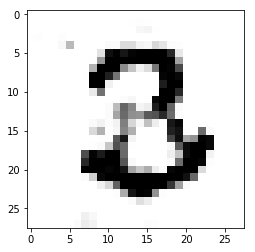

Estimate: [[-7.3866787]]
Iteration: 15100 at 2019-08-19 05:32:06.632646


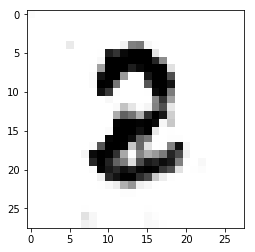

Estimate: [[-1.8110877]]
Iteration: 15200 at 2019-08-19 05:32:09.793108


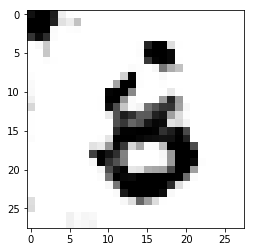

Estimate: [[9.696377]]
Iteration: 15300 at 2019-08-19 05:32:12.982902


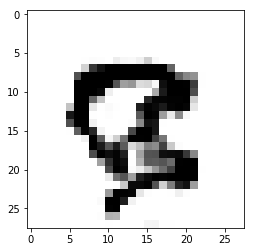

Estimate: [[-1.1004623]]
Iteration: 15400 at 2019-08-19 05:32:16.169797


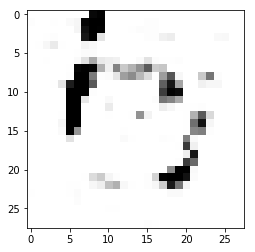

Estimate: [[-16.267826]]
Iteration: 15500 at 2019-08-19 05:32:19.344488


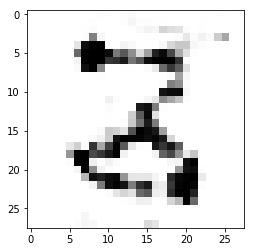

Estimate: [[-2.5376883]]
Iteration: 15600 at 2019-08-19 05:32:22.537416


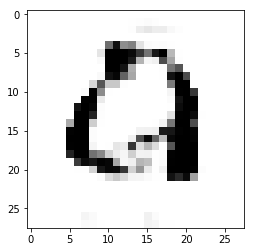

Estimate: [[-1.93535]]
Iteration: 15700 at 2019-08-19 05:32:25.745368


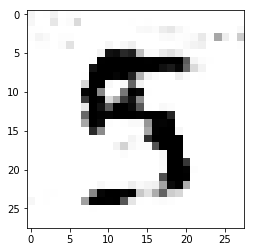

Estimate: [[-6.167599]]
Iteration: 15800 at 2019-08-19 05:32:28.949139


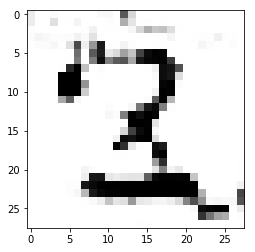

Estimate: [[-13.913533]]
Iteration: 15900 at 2019-08-19 05:32:32.162648


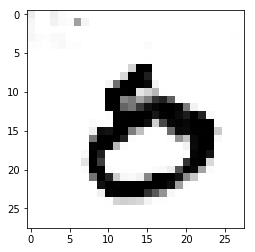

Estimate: [[1.2124157]]
Iteration: 16000 at 2019-08-19 05:32:35.398812


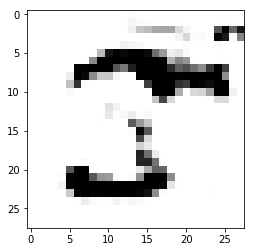

Estimate: [[-3.2323587]]
Iteration: 16100 at 2019-08-19 05:32:38.631546


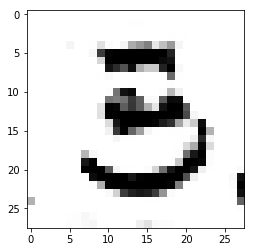

Estimate: [[5.0134044]]
Iteration: 16200 at 2019-08-19 05:32:41.926252


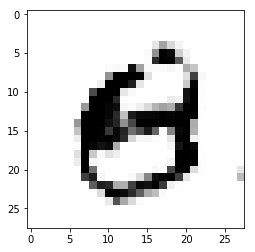

Estimate: [[-9.386309]]
Iteration: 16300 at 2019-08-19 05:32:45.160547


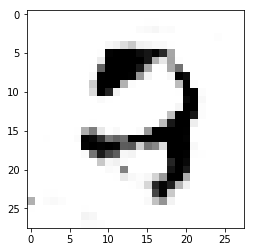

Estimate: [[0.5487217]]
Iteration: 16400 at 2019-08-19 05:32:48.410675


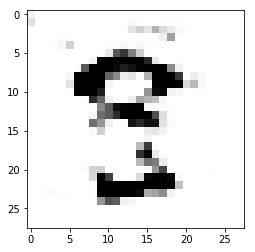

Estimate: [[-5.3006444]]
Iteration: 16500 at 2019-08-19 05:32:51.670366


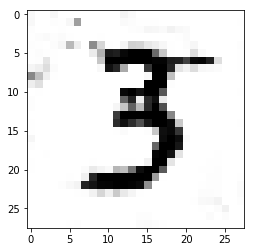

Estimate: [[-7.2422466]]
Iteration: 16600 at 2019-08-19 05:32:54.964318


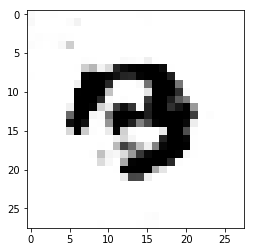

Estimate: [[2.0637734]]
Iteration: 16700 at 2019-08-19 05:32:58.242306


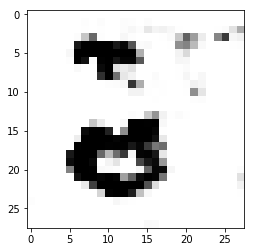

Estimate: [[-11.035511]]
Iteration: 16800 at 2019-08-19 05:33:01.511097


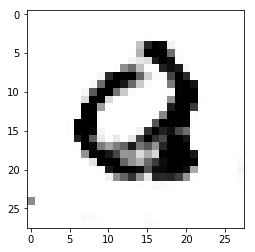

Estimate: [[5.0847945]]
Iteration: 16900 at 2019-08-19 05:33:04.795486


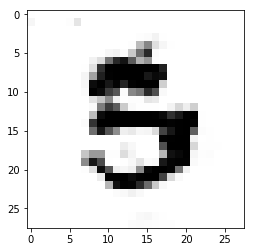

Estimate: [[-7.127087]]
Iteration: 17000 at 2019-08-19 05:33:08.095969


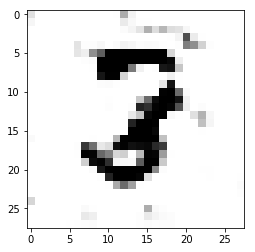

Estimate: [[-3.7514102]]
Iteration: 17100 at 2019-08-19 05:33:11.380327


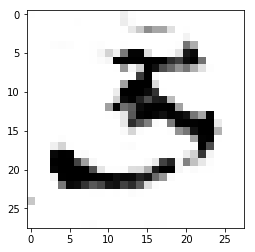

Estimate: [[-1.2031044]]
Iteration: 17200 at 2019-08-19 05:33:14.669303


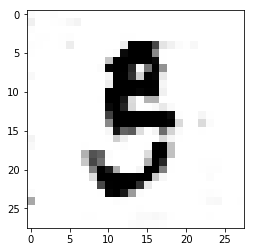

Estimate: [[-2.1047604]]
Iteration: 17300 at 2019-08-19 05:33:18.039622


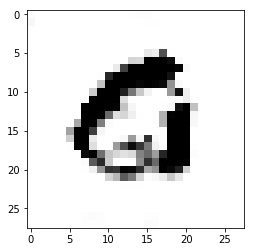

Estimate: [[-1.6293569]]
Iteration: 17400 at 2019-08-19 05:33:21.372492


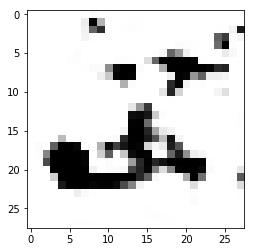

Estimate: [[-17.567686]]
Iteration: 17500 at 2019-08-19 05:33:24.713277


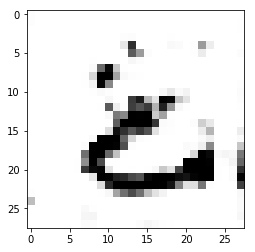

Estimate: [[-2.486975]]
Iteration: 17600 at 2019-08-19 05:33:28.059774


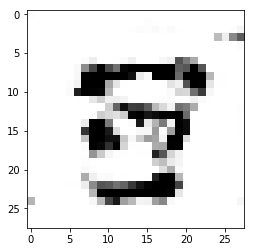

Estimate: [[-1.1347281]]
Iteration: 17700 at 2019-08-19 05:33:31.402755


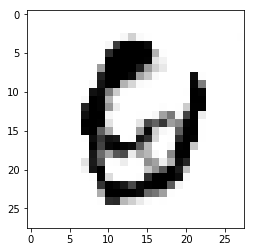

Estimate: [[14.648828]]
Iteration: 17800 at 2019-08-19 05:33:34.743618


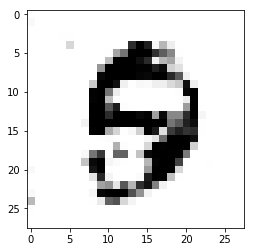

Estimate: [[-0.29922295]]
Iteration: 17900 at 2019-08-19 05:33:38.098311


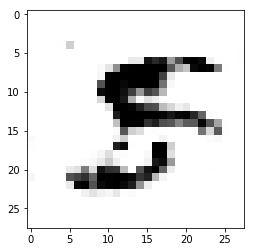

Estimate: [[2.9326122]]
Iteration: 18000 at 2019-08-19 05:33:41.452947


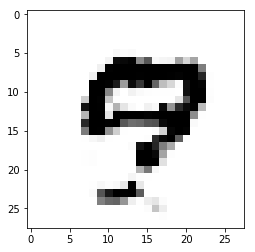

Estimate: [[-0.8066075]]
Iteration: 18100 at 2019-08-19 05:33:44.796475


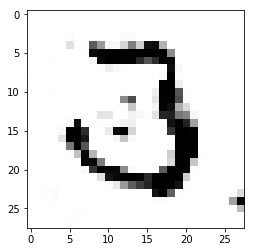

Estimate: [[-7.03653]]
Iteration: 18200 at 2019-08-19 05:33:48.173405


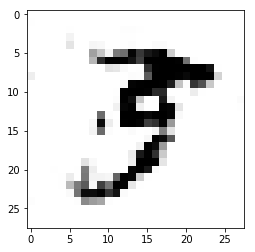

Estimate: [[13.265246]]
Iteration: 18300 at 2019-08-19 05:33:51.527434


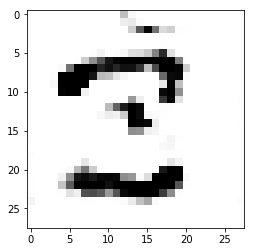

Estimate: [[-5.1102896]]
Iteration: 18400 at 2019-08-19 05:33:54.993543


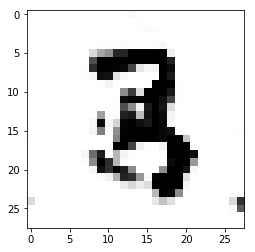

Estimate: [[-9.902921]]
Iteration: 18500 at 2019-08-19 05:33:58.400273


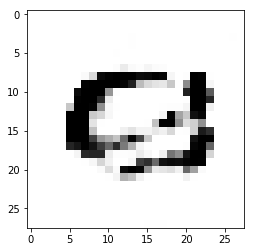

Estimate: [[-5.863086]]
Iteration: 18600 at 2019-08-19 05:34:01.806378


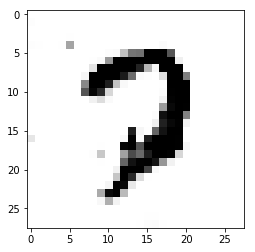

Estimate: [[-3.5273402]]
Iteration: 18700 at 2019-08-19 05:34:05.187651


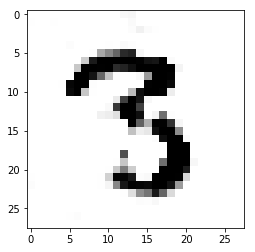

Estimate: [[0.14433254]]
Iteration: 18800 at 2019-08-19 05:34:08.935899


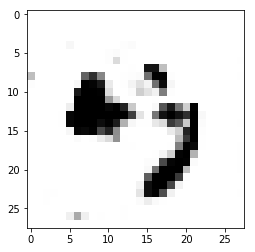

Estimate: [[6.6873293]]
Iteration: 18900 at 2019-08-19 05:34:12.337379


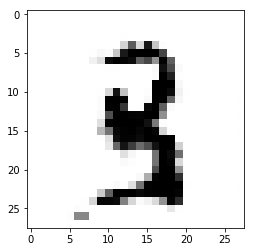

Estimate: [[-0.8410558]]
Iteration: 19000 at 2019-08-19 05:34:15.818987


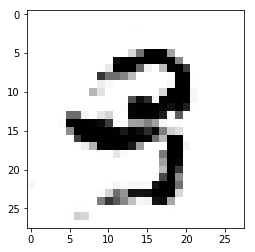

Estimate: [[3.6639466]]
Iteration: 19100 at 2019-08-19 05:34:19.292863


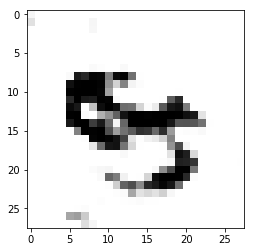

Estimate: [[-7.80413]]
Iteration: 19200 at 2019-08-19 05:34:22.783846


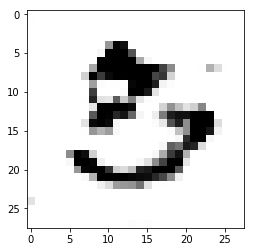

Estimate: [[-6.526867]]
Iteration: 19300 at 2019-08-19 05:34:26.223397


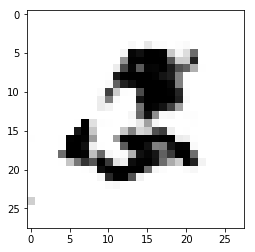

Estimate: [[-4.672697]]
Iteration: 19400 at 2019-08-19 05:34:29.655958


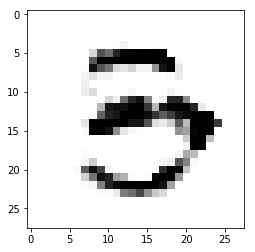

Estimate: [[-10.022128]]
Iteration: 19500 at 2019-08-19 05:34:33.160816


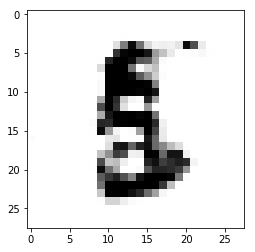

Estimate: [[-4.747302]]
Iteration: 19600 at 2019-08-19 05:34:36.607086


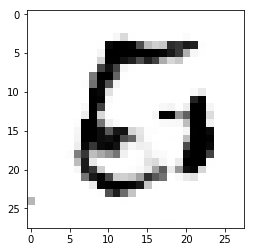

Estimate: [[1.8163506]]
Iteration: 19700 at 2019-08-19 05:34:40.083376


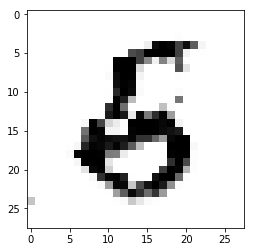

Estimate: [[0.23761594]]
Iteration: 19800 at 2019-08-19 05:34:43.570169


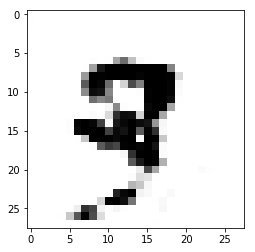

Estimate: [[-6.0823116]]
Iteration: 19900 at 2019-08-19 05:34:47.058997


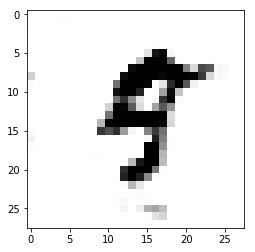

Estimate: [[-1.8621218]]
Iteration: 20000 at 2019-08-19 05:34:50.560602


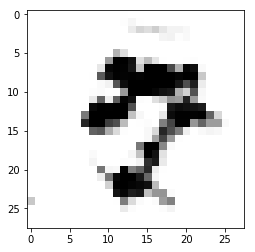

Estimate: [[-2.0304806]]
Iteration: 20100 at 2019-08-19 05:34:54.105025


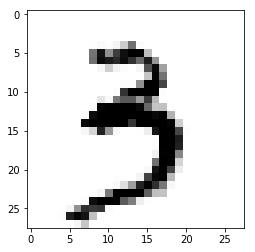

Estimate: [[9.175484]]
Iteration: 20200 at 2019-08-19 05:34:57.638679


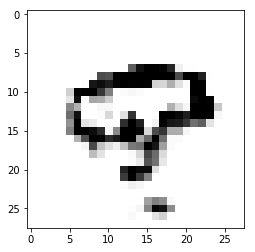

Estimate: [[3.687542]]
Iteration: 20300 at 2019-08-19 05:35:01.141344


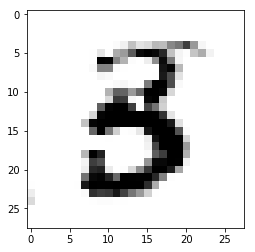

Estimate: [[-0.30001354]]
Iteration: 20400 at 2019-08-19 05:35:04.653149


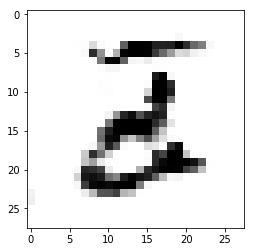

Estimate: [[-2.1716068]]
Iteration: 20500 at 2019-08-19 05:35:08.158876


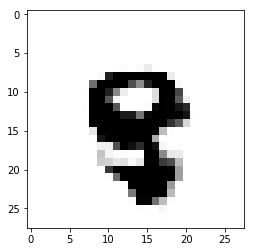

Estimate: [[-3.884466]]
Iteration: 20600 at 2019-08-19 05:35:11.727544


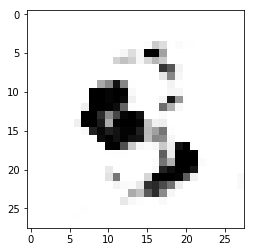

Estimate: [[-9.019246]]
Iteration: 20700 at 2019-08-19 05:35:15.238601


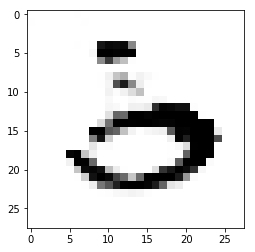

Estimate: [[-9.65073]]
Iteration: 20800 at 2019-08-19 05:35:18.759492


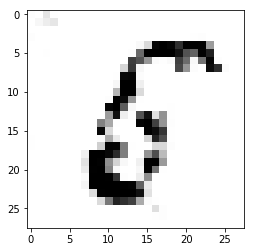

Estimate: [[-6.109485]]
Iteration: 20900 at 2019-08-19 05:35:22.300483


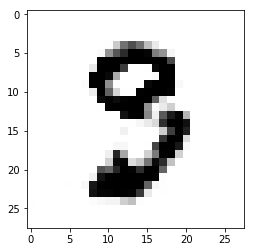

Estimate: [[-2.447982]]
Iteration: 21000 at 2019-08-19 05:35:25.860676


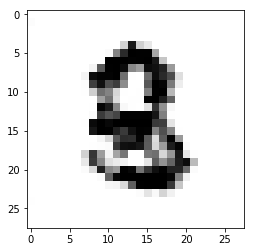

Estimate: [[-6.6592703]]
Iteration: 21100 at 2019-08-19 05:35:29.422143


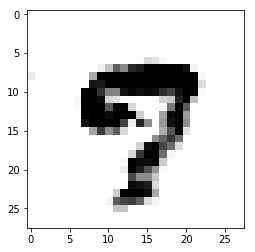

Estimate: [[7.3054657]]
Iteration: 21200 at 2019-08-19 05:35:32.973492


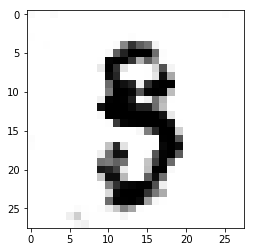

Estimate: [[1.9142126]]
Iteration: 21300 at 2019-08-19 05:35:36.555119


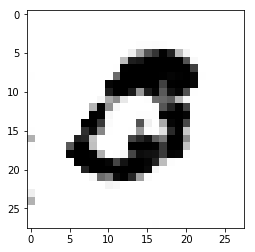

Estimate: [[0.31114662]]
Iteration: 21400 at 2019-08-19 05:35:40.156212


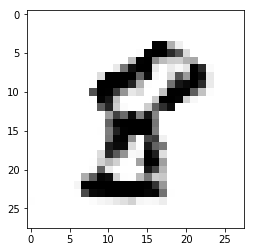

Estimate: [[4.746301]]
Iteration: 21500 at 2019-08-19 05:35:43.744597


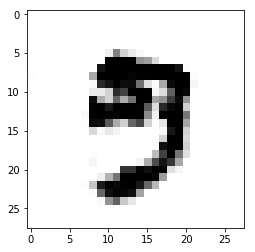

Estimate: [[-2.112088]]
Iteration: 21600 at 2019-08-19 05:35:47.348873


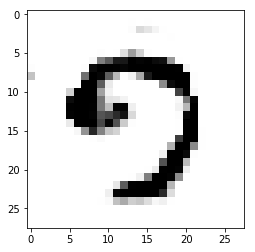

Estimate: [[1.8443216]]
Iteration: 21700 at 2019-08-19 05:35:50.998351


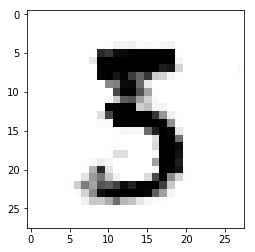

Estimate: [[-3.1042125]]
Iteration: 21800 at 2019-08-19 05:35:54.648079


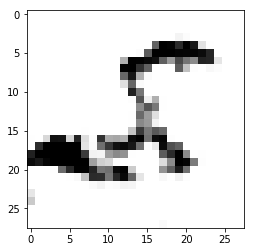

Estimate: [[1.4171659]]
Iteration: 21900 at 2019-08-19 05:35:58.283874


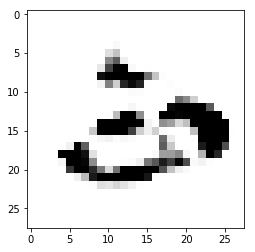

Estimate: [[6.652686]]
Iteration: 22000 at 2019-08-19 05:36:01.947084


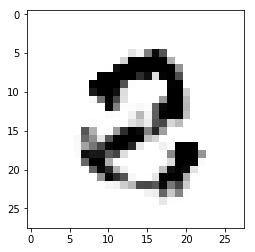

Estimate: [[-8.414019]]
Iteration: 22100 at 2019-08-19 05:36:05.583210


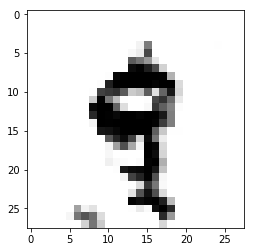

Estimate: [[0.2872509]]
Iteration: 22200 at 2019-08-19 05:36:09.252121


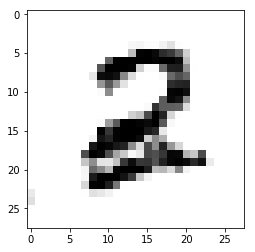

Estimate: [[-0.19563916]]
Iteration: 22300 at 2019-08-19 05:36:12.881768


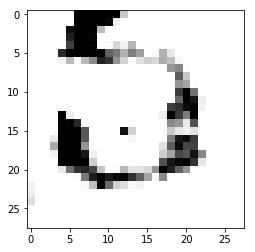

Estimate: [[-12.748861]]
Iteration: 22400 at 2019-08-19 05:36:16.516874


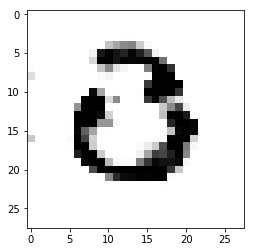

Estimate: [[-11.279084]]
Iteration: 22500 at 2019-08-19 05:36:20.157908


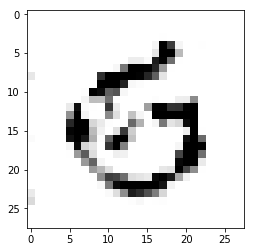

Estimate: [[-1.2129663]]
Iteration: 22600 at 2019-08-19 05:36:23.825962


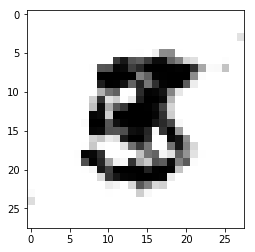

Estimate: [[-10.24028]]
Iteration: 22700 at 2019-08-19 05:36:27.520829


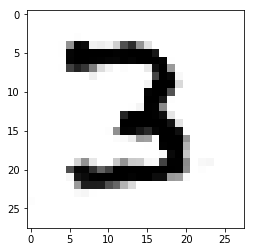

Estimate: [[9.253492]]
Iteration: 22800 at 2019-08-19 05:36:31.262268


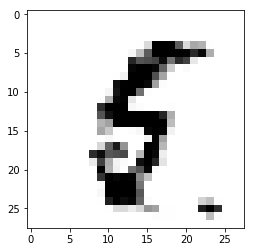

Estimate: [[8.440723]]
Iteration: 22900 at 2019-08-19 05:36:34.994756


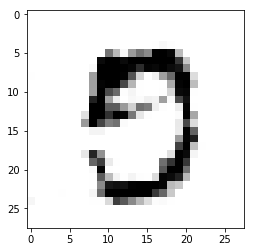

Estimate: [[-3.5247512]]
Iteration: 23000 at 2019-08-19 05:36:38.700571


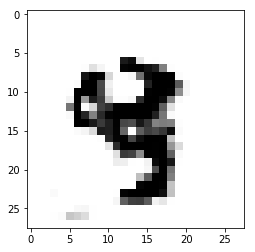

Estimate: [[3.3406951]]
Iteration: 23100 at 2019-08-19 05:36:42.462302


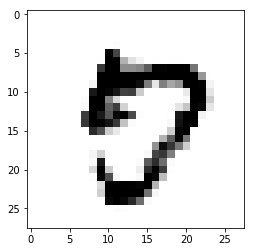

Estimate: [[7.433164]]
Iteration: 23200 at 2019-08-19 05:36:46.152129


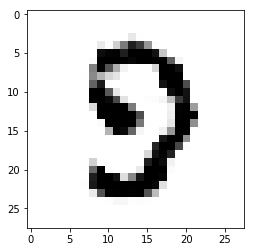

Estimate: [[5.942795]]
Iteration: 23300 at 2019-08-19 05:36:50.343277


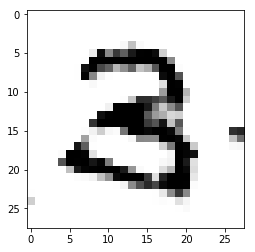

Estimate: [[-2.5224545]]
Iteration: 23400 at 2019-08-19 05:36:54.085278


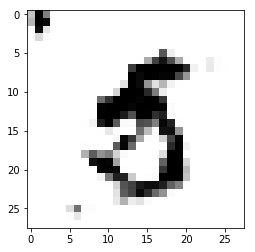

Estimate: [[-0.94477427]]
Iteration: 23500 at 2019-08-19 05:36:57.815004


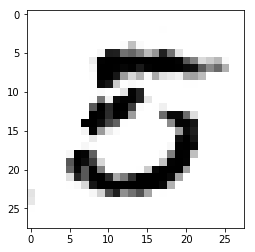

Estimate: [[-4.100911]]
Iteration: 23600 at 2019-08-19 05:37:01.633708


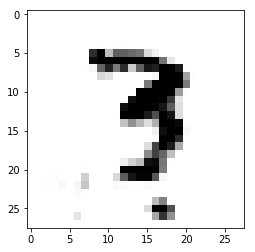

Estimate: [[-1.9647086]]
Iteration: 23700 at 2019-08-19 05:37:05.385414


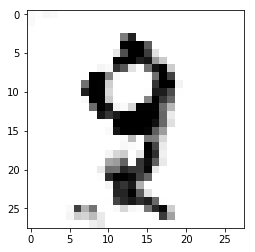

Estimate: [[11.131335]]
Iteration: 23800 at 2019-08-19 05:37:09.181895


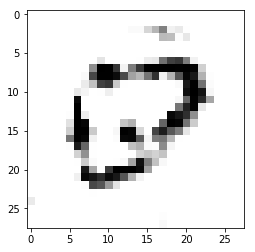

Estimate: [[-8.698328]]
Iteration: 23900 at 2019-08-19 05:37:13.051610


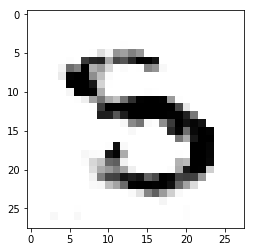

Estimate: [[3.4184546]]
Iteration: 24000 at 2019-08-19 05:37:16.888853


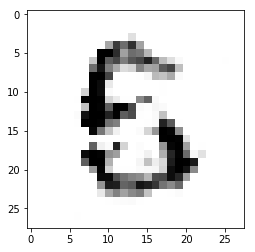

Estimate: [[-4.300786]]
Iteration: 24100 at 2019-08-19 05:37:20.726189


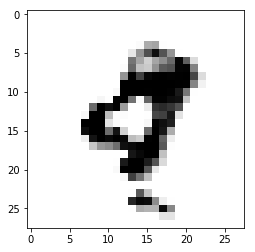

Estimate: [[3.0904374]]
Iteration: 24200 at 2019-08-19 05:37:24.605847


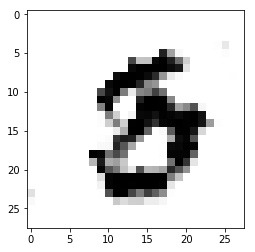

Estimate: [[-4.0613694]]
Iteration: 24300 at 2019-08-19 05:37:28.478684


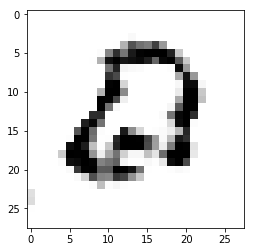

Estimate: [[3.7627587]]
Iteration: 24400 at 2019-08-19 05:37:32.285460


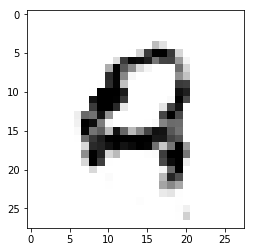

Estimate: [[-10.6768875]]
Iteration: 24500 at 2019-08-19 05:37:36.197085


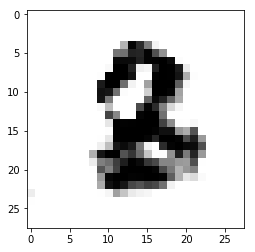

Estimate: [[-0.5543308]]
Iteration: 24600 at 2019-08-19 05:37:40.081852


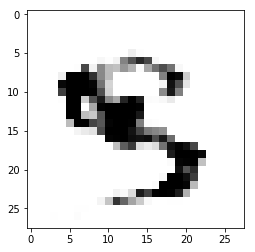

Estimate: [[-7.569431]]
Iteration: 24700 at 2019-08-19 05:37:43.959540


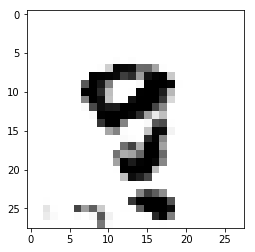

Estimate: [[-6.630822]]
Iteration: 24800 at 2019-08-19 05:37:47.878893


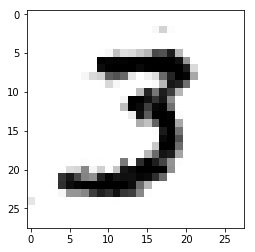

Estimate: [[-7.373041]]
Iteration: 24900 at 2019-08-19 05:37:51.779406


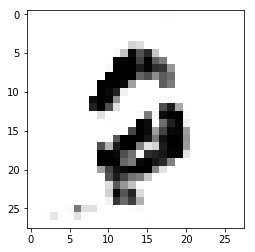

Estimate: [[-3.9398606]]
Iteration: 25000 at 2019-08-19 05:37:55.772383


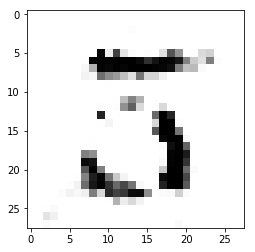

Estimate: [[-5.9578156]]
Iteration: 25100 at 2019-08-19 05:37:59.706672


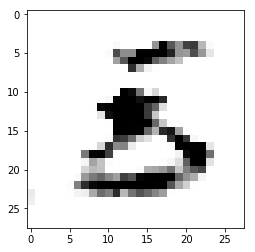

Estimate: [[2.0030437]]
Iteration: 25200 at 2019-08-19 05:38:03.672444


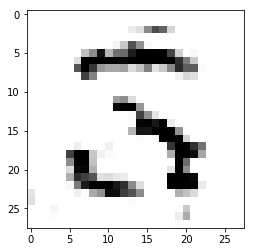

Estimate: [[5.0145764]]
Iteration: 25300 at 2019-08-19 05:38:07.589303


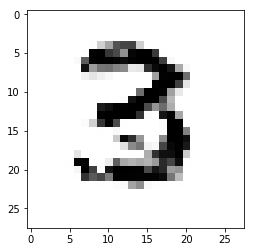

Estimate: [[-4.2497134]]
Iteration: 25400 at 2019-08-19 05:38:11.528500


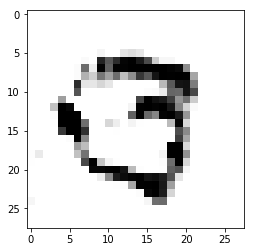

Estimate: [[-1.4451636]]
Iteration: 25500 at 2019-08-19 05:38:15.482179


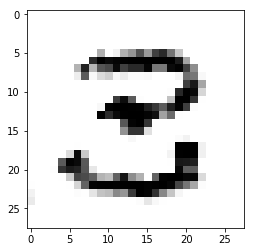

Estimate: [[-0.78183246]]
Iteration: 25600 at 2019-08-19 05:38:19.425609


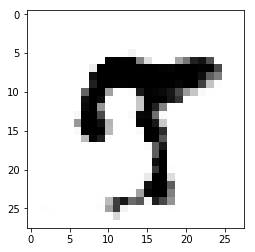

Estimate: [[3.1200283]]
Iteration: 25700 at 2019-08-19 05:38:23.398433


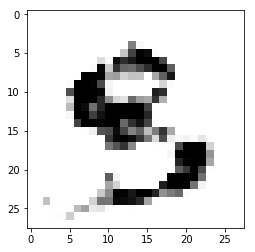

Estimate: [[-4.88175]]
Iteration: 25800 at 2019-08-19 05:38:27.374468


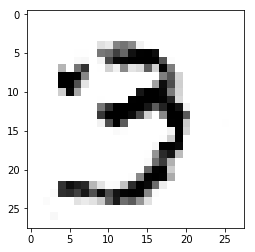

Estimate: [[-1.8837546]]
Iteration: 25900 at 2019-08-19 05:38:31.397771


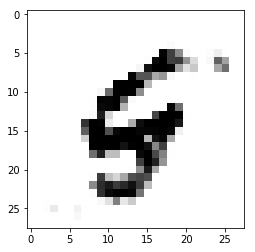

Estimate: [[-3.228858]]
Iteration: 26000 at 2019-08-19 05:38:35.390725


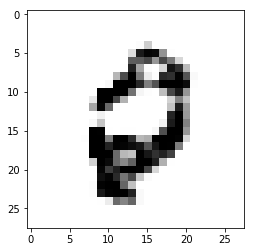

Estimate: [[-4.388724]]
Iteration: 26100 at 2019-08-19 05:38:39.459755


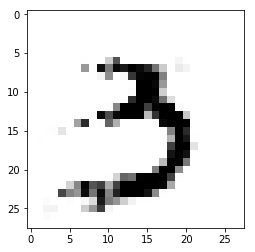

Estimate: [[3.7634094]]
Iteration: 26200 at 2019-08-19 05:38:43.514838


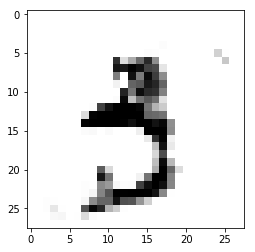

Estimate: [[-5.311079]]
Iteration: 26300 at 2019-08-19 05:38:47.561772


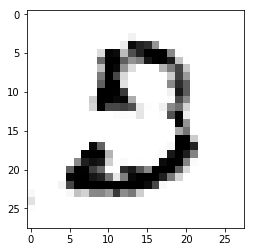

Estimate: [[4.677501]]
Iteration: 26400 at 2019-08-19 05:38:51.604970


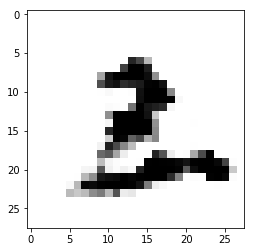

Estimate: [[0.36698842]]
Iteration: 26500 at 2019-08-19 05:38:55.656386


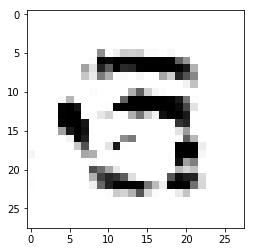

Estimate: [[1.3888096]]
Iteration: 26600 at 2019-08-19 05:38:59.701005


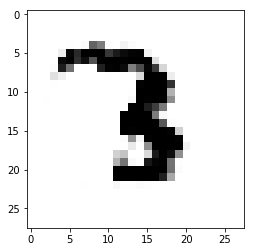

Estimate: [[-0.335545]]
Iteration: 26700 at 2019-08-19 05:39:03.743264


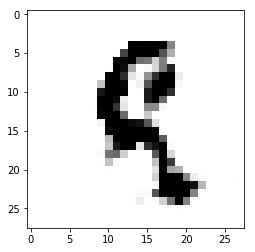

Estimate: [[11.254024]]
Iteration: 26800 at 2019-08-19 05:39:07.784496


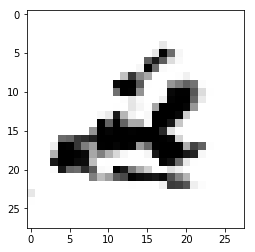

Estimate: [[-2.871183]]
Iteration: 26900 at 2019-08-19 05:39:11.829959


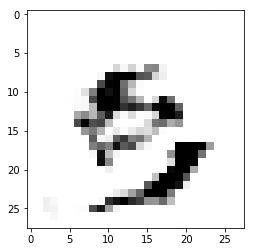

Estimate: [[-10.070509]]
Iteration: 27000 at 2019-08-19 05:39:15.873045


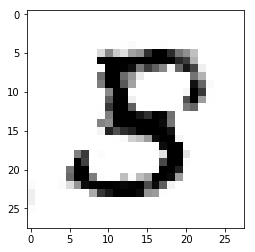

Estimate: [[-1.5352622]]
Iteration: 27100 at 2019-08-19 05:39:19.898671


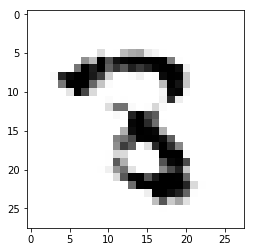

Estimate: [[-4.803015]]
Iteration: 27200 at 2019-08-19 05:39:24.059754


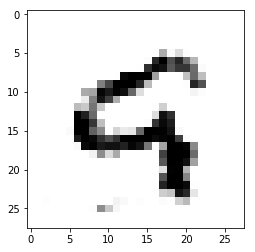

Estimate: [[2.5525022]]
Iteration: 27300 at 2019-08-19 05:39:28.225818


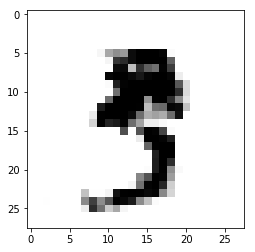

Estimate: [[-5.1428323]]
Iteration: 27400 at 2019-08-19 05:39:32.372188


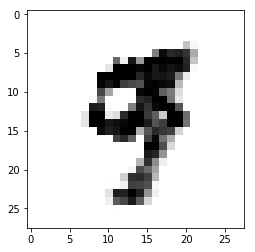

Estimate: [[12.604537]]
Iteration: 27500 at 2019-08-19 05:39:36.479583


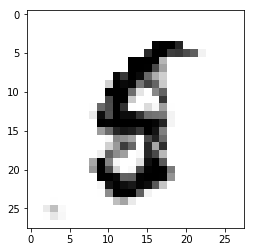

Estimate: [[-3.222104]]
Iteration: 27600 at 2019-08-19 05:39:40.563752


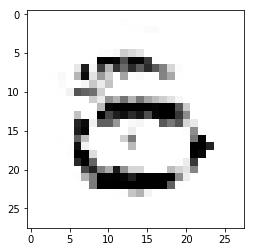

Estimate: [[-7.6209636]]
Iteration: 27700 at 2019-08-19 05:39:44.689773


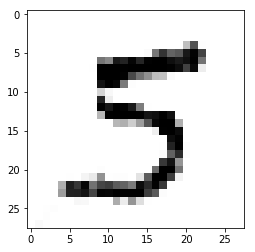

Estimate: [[4.3750496]]
Iteration: 27800 at 2019-08-19 05:39:48.806910


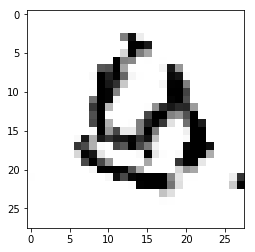

Estimate: [[-1.0242757]]
Iteration: 27900 at 2019-08-19 05:39:52.914134


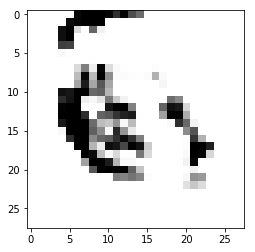

Estimate: [[23.129679]]
Iteration: 28000 at 2019-08-19 05:39:57.070494


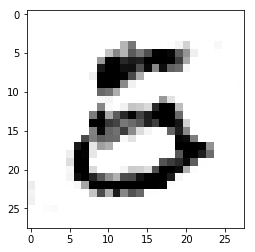

Estimate: [[-7.355575]]
Iteration: 28100 at 2019-08-19 05:40:01.264112


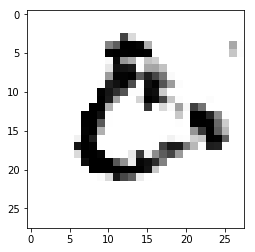

Estimate: [[-0.99787354]]
Iteration: 28200 at 2019-08-19 05:40:05.476647


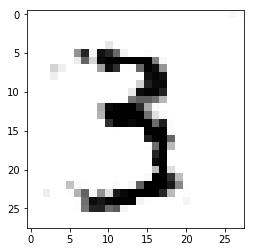

Estimate: [[-0.9558519]]
Iteration: 28300 at 2019-08-19 05:40:09.706973


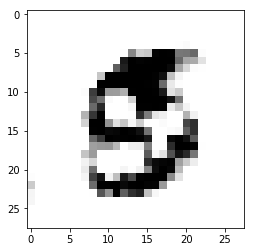

Estimate: [[-14.86196]]
Iteration: 28400 at 2019-08-19 05:40:13.872991


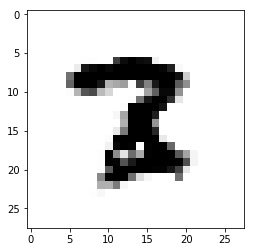

Estimate: [[2.2974262]]
Iteration: 28500 at 2019-08-19 05:40:18.486734


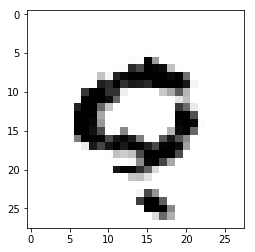

Estimate: [[-4.813627]]
Iteration: 28600 at 2019-08-19 05:40:22.683527


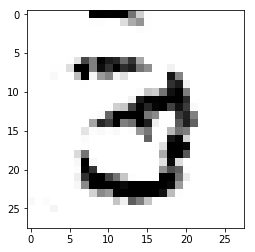

Estimate: [[2.3948102]]
Iteration: 28700 at 2019-08-19 05:40:26.911019


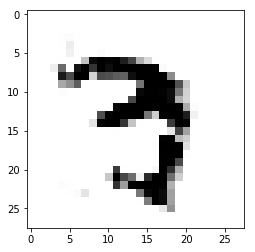

Estimate: [[-0.7549572]]
Iteration: 28800 at 2019-08-19 05:40:31.116551


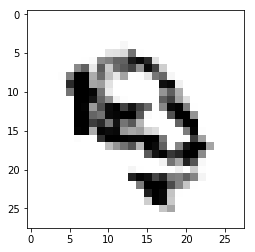

Estimate: [[7.3237996]]
Iteration: 28900 at 2019-08-19 05:40:35.302138


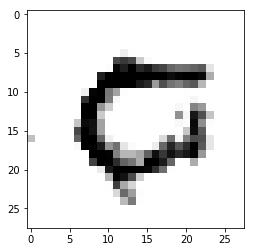

Estimate: [[-1.6151694]]
Iteration: 29000 at 2019-08-19 05:40:39.532218


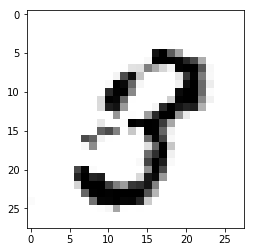

Estimate: [[-5.4059896]]
Iteration: 29100 at 2019-08-19 05:40:43.747156


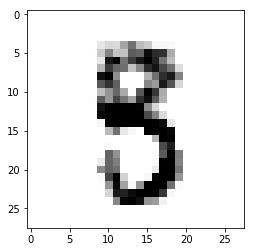

Estimate: [[-0.68321645]]
Iteration: 29200 at 2019-08-19 05:40:47.973447


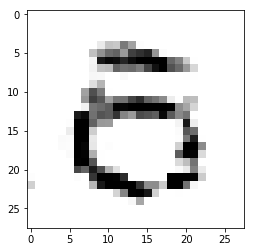

Estimate: [[-10.366651]]
Iteration: 29300 at 2019-08-19 05:40:52.208248


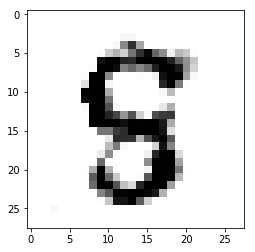

Estimate: [[-8.345132]]
Iteration: 29400 at 2019-08-19 05:40:56.535336


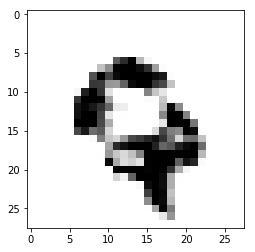

Estimate: [[1.5057606]]
Iteration: 29500 at 2019-08-19 05:41:00.764586


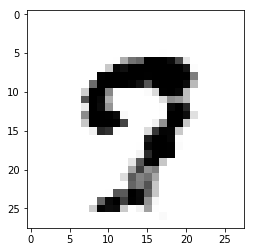

Estimate: [[-0.4499185]]
Iteration: 29600 at 2019-08-19 05:41:05.017629


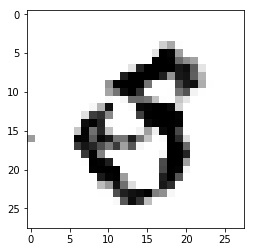

Estimate: [[6.922393]]
Iteration: 29700 at 2019-08-19 05:41:09.271104


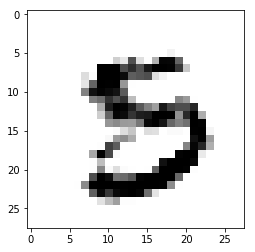

Estimate: [[-1.6401955]]
Iteration: 29800 at 2019-08-19 05:41:13.527389


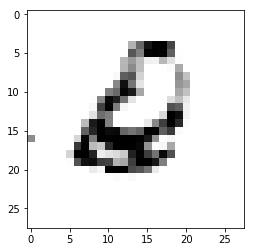

Estimate: [[3.3095572]]
Iteration: 29900 at 2019-08-19 05:41:17.789156


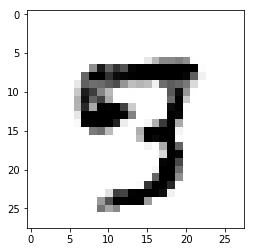

Estimate: [[0.17226346]]
Iteration: 30000 at 2019-08-19 05:41:22.101539


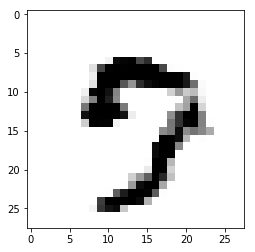

Estimate: [[-3.6922717]]
Iteration: 30100 at 2019-08-19 05:41:26.421908


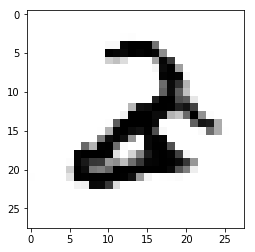

Estimate: [[2.8776615]]
Iteration: 30200 at 2019-08-19 05:41:30.735986


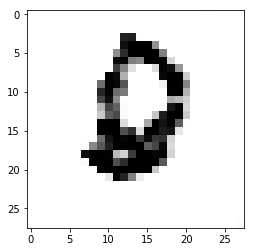

Estimate: [[3.648978]]
Iteration: 30300 at 2019-08-19 05:41:35.058963


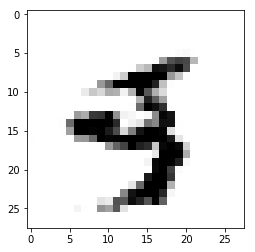

Estimate: [[-3.1083853]]
Iteration: 30400 at 2019-08-19 05:41:39.358841


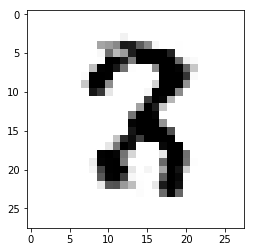

Estimate: [[-0.7472533]]
Iteration: 30500 at 2019-08-19 05:41:43.756347


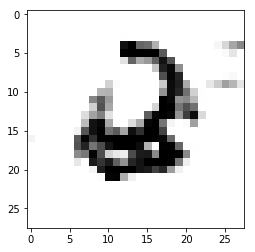

Estimate: [[7.239893]]
Iteration: 30600 at 2019-08-19 05:41:48.091226


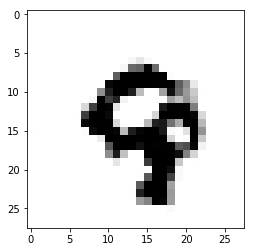

Estimate: [[4.0050807]]
Iteration: 30700 at 2019-08-19 05:41:52.426877


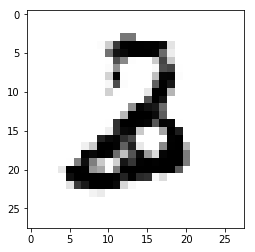

Estimate: [[0.2520096]]
Iteration: 30800 at 2019-08-19 05:41:56.803321


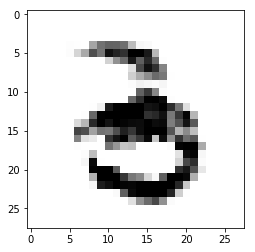

Estimate: [[-3.3322563]]
Iteration: 30900 at 2019-08-19 05:42:01.146463


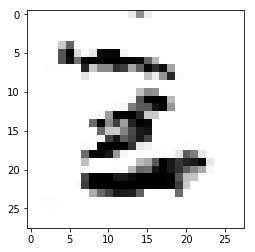

Estimate: [[-2.1590457]]
Iteration: 31000 at 2019-08-19 05:42:05.501145


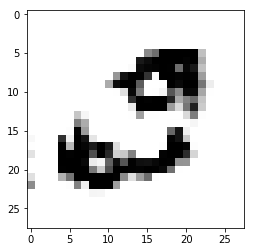

Estimate: [[-12.540803]]
Iteration: 31100 at 2019-08-19 05:42:09.854113


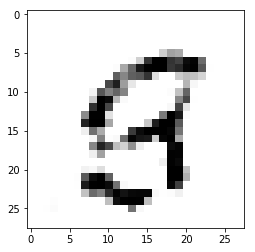

Estimate: [[1.7239777]]
Iteration: 31200 at 2019-08-19 05:42:14.243781


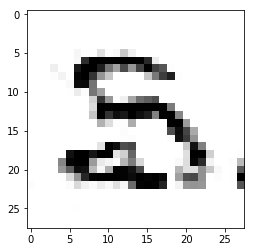

Estimate: [[-12.236043]]
Iteration: 31300 at 2019-08-19 05:42:18.593193


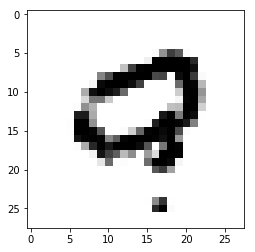

Estimate: [[-11.35252]]
Iteration: 31400 at 2019-08-19 05:42:22.957500


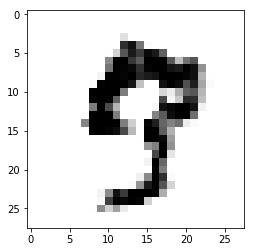

Estimate: [[-8.092817]]
Iteration: 31500 at 2019-08-19 05:42:27.369306


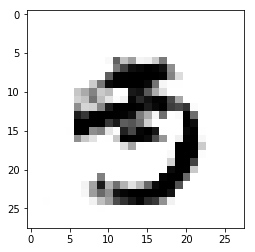

Estimate: [[-11.237636]]
Iteration: 31600 at 2019-08-19 05:42:31.853640


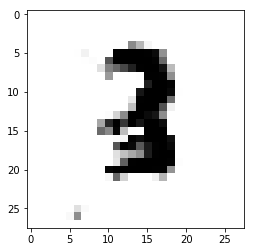

Estimate: [[-15.876297]]
Iteration: 31700 at 2019-08-19 05:42:36.267797


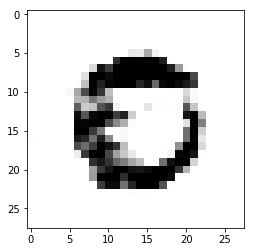

Estimate: [[-2.710519]]
Iteration: 31800 at 2019-08-19 05:42:40.699556


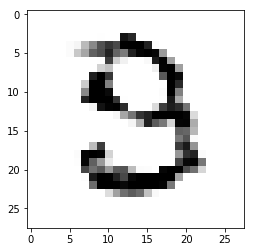

Estimate: [[2.2666504]]
Iteration: 31900 at 2019-08-19 05:42:45.120185


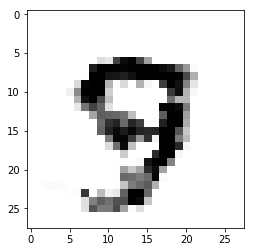

Estimate: [[-1.2433901]]
Iteration: 32000 at 2019-08-19 05:42:49.593942


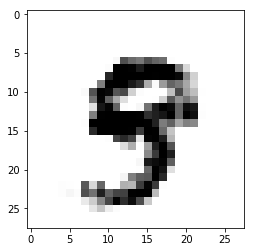

Estimate: [[3.393293]]
Iteration: 32100 at 2019-08-19 05:42:54.044882


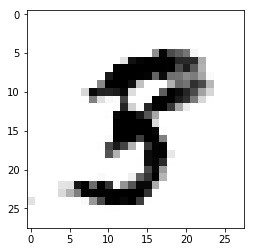

Estimate: [[13.531151]]
Iteration: 32200 at 2019-08-19 05:42:58.484073


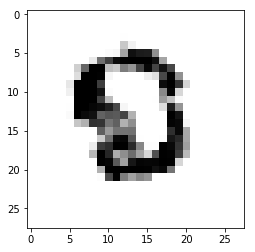

Estimate: [[9.781861]]
Iteration: 32300 at 2019-08-19 05:43:02.931151


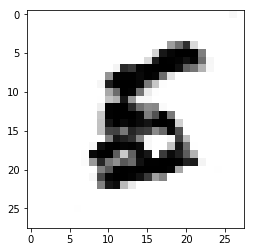

Estimate: [[-5.6619143]]
Iteration: 32400 at 2019-08-19 05:43:07.385981


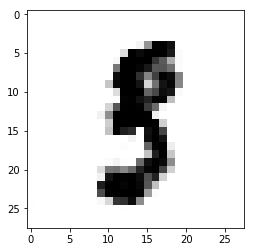

Estimate: [[-5.933625]]
Iteration: 32500 at 2019-08-19 05:43:11.832841


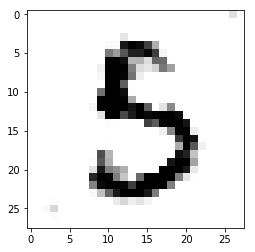

Estimate: [[-5.0899467]]
Iteration: 32600 at 2019-08-19 05:43:16.298568


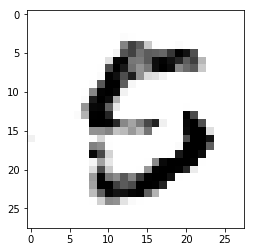

Estimate: [[0.03934544]]
Iteration: 32700 at 2019-08-19 05:43:20.812080


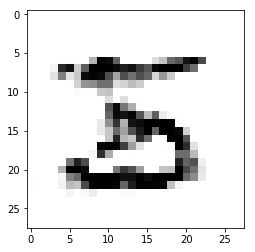

Estimate: [[-1.2863518]]
Iteration: 32800 at 2019-08-19 05:43:25.310936


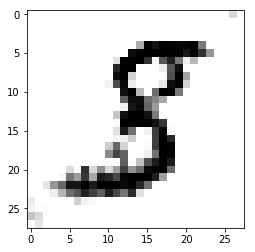

Estimate: [[7.2086363]]
Iteration: 32900 at 2019-08-19 05:43:29.800505


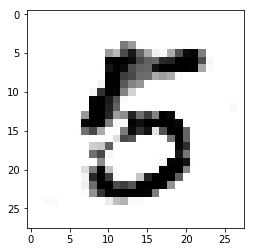

Estimate: [[3.4496734]]
Iteration: 33000 at 2019-08-19 05:43:34.279337


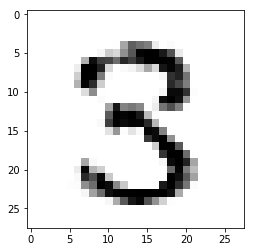

Estimate: [[-3.7861538]]
Iteration: 33100 at 2019-08-19 05:43:38.775793


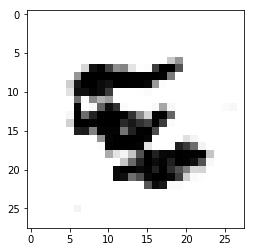

Estimate: [[0.10472386]]
Iteration: 33200 at 2019-08-19 05:43:43.300174


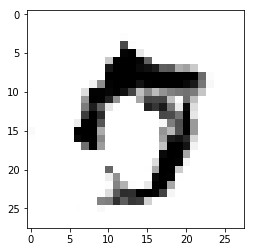

Estimate: [[-12.775337]]
Iteration: 33300 at 2019-08-19 05:43:47.800336


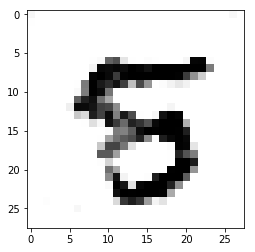

Estimate: [[-12.106578]]
Iteration: 33400 at 2019-08-19 05:43:52.328668


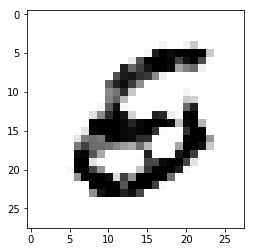

Estimate: [[1.8631803]]
Iteration: 33500 at 2019-08-19 05:43:56.896467


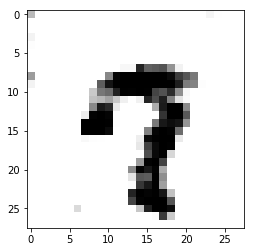

Estimate: [[-2.3891163]]
Iteration: 33600 at 2019-08-19 05:44:01.449234


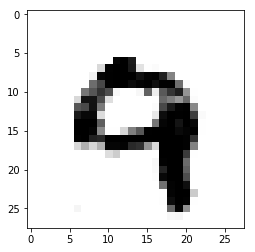

Estimate: [[8.902645]]
Iteration: 33700 at 2019-08-19 05:44:06.024157


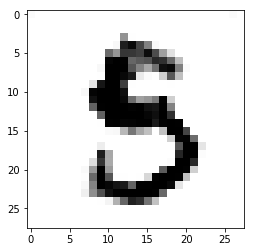

Estimate: [[2.5167592]]
Iteration: 33800 at 2019-08-19 05:44:10.708327


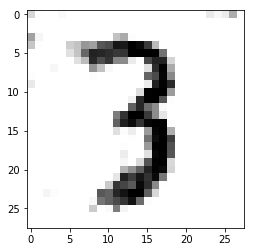

Estimate: [[2.8275914]]
Iteration: 33900 at 2019-08-19 05:44:15.267165


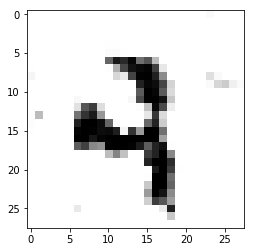

Estimate: [[1.3678389]]
Iteration: 34000 at 2019-08-19 05:44:19.831799


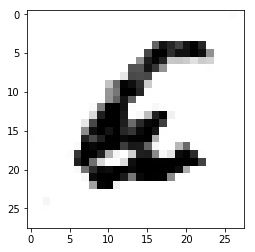

Estimate: [[1.12444]]
Iteration: 34100 at 2019-08-19 05:44:24.398569


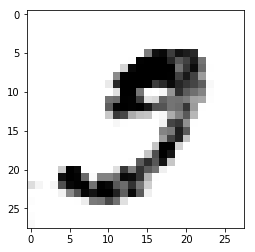

Estimate: [[4.156568]]
Iteration: 34200 at 2019-08-19 05:44:28.982877


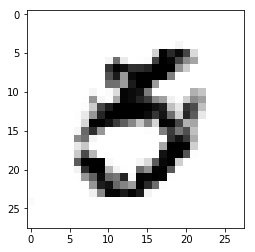

Estimate: [[-7.55319]]
Iteration: 34300 at 2019-08-19 05:44:33.587692


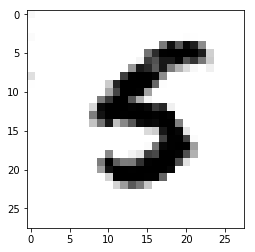

Estimate: [[-4.2806787]]
Iteration: 34400 at 2019-08-19 05:44:38.275484


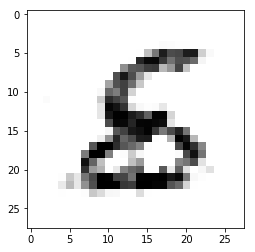

Estimate: [[-7.033544]]
Iteration: 34500 at 2019-08-19 05:44:42.964366


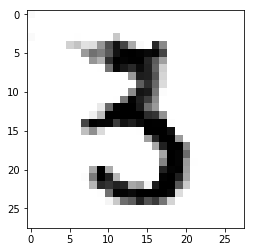

Estimate: [[2.3606558]]
Iteration: 34600 at 2019-08-19 05:44:48.051237


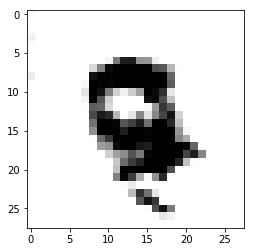

Estimate: [[11.223678]]
Iteration: 34700 at 2019-08-19 05:44:52.647891


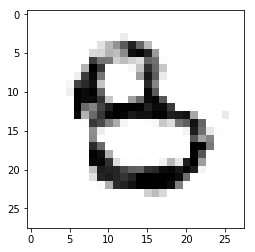

Estimate: [[-0.41242462]]
Iteration: 34800 at 2019-08-19 05:44:57.295457


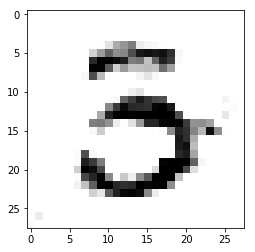

Estimate: [[1.9051992]]
Iteration: 34900 at 2019-08-19 05:45:01.984676


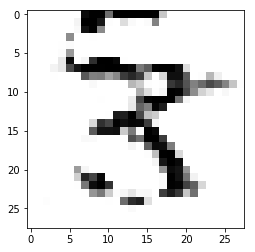

Estimate: [[5.401008]]
Iteration: 35000 at 2019-08-19 05:45:06.700152


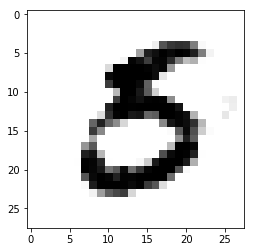

Estimate: [[0.3131867]]
Iteration: 35100 at 2019-08-19 05:45:11.375620


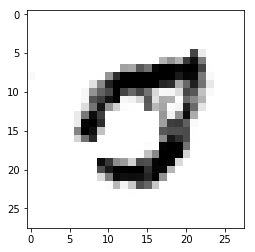

Estimate: [[-6.9672775]]
Iteration: 35200 at 2019-08-19 05:45:16.029344


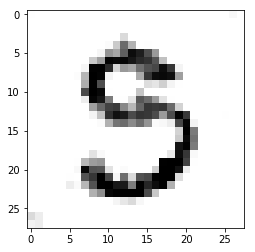

Estimate: [[-10.743706]]
Iteration: 35300 at 2019-08-19 05:45:20.704083


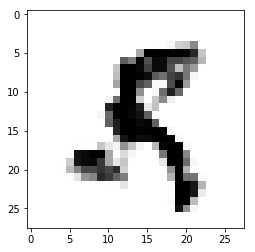

Estimate: [[-2.402109]]
Iteration: 35400 at 2019-08-19 05:45:25.388197


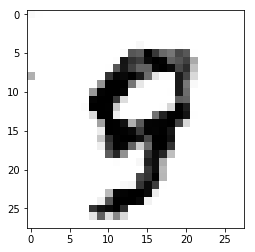

Estimate: [[2.1359372]]
Iteration: 35500 at 2019-08-19 05:45:30.139799


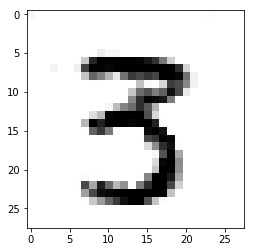

Estimate: [[0.5033043]]
Iteration: 35600 at 2019-08-19 05:45:34.827506


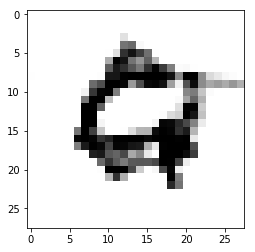

Estimate: [[2.2944694]]
Iteration: 35700 at 2019-08-19 05:45:39.517181


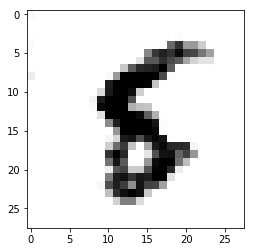

Estimate: [[14.65278]]
Iteration: 35800 at 2019-08-19 05:45:44.244856


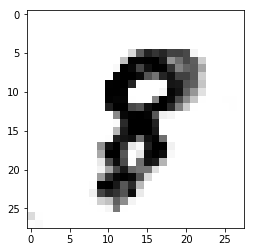

Estimate: [[12.036044]]
Iteration: 35900 at 2019-08-19 05:45:48.947073


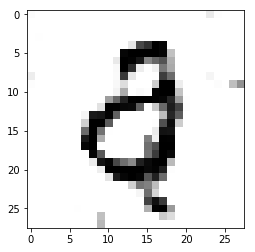

Estimate: [[-5.5720143]]
Iteration: 36000 at 2019-08-19 05:45:53.717288


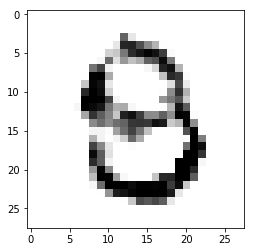

Estimate: [[3.0658271]]
Iteration: 36100 at 2019-08-19 05:45:58.456558


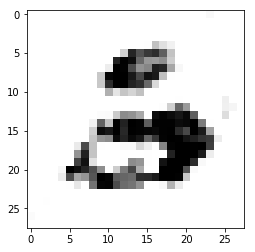

Estimate: [[-13.627514]]
Iteration: 36200 at 2019-08-19 05:46:03.226994


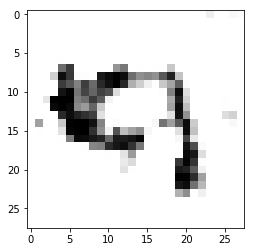

Estimate: [[4.004437]]
Iteration: 36300 at 2019-08-19 05:46:07.976732


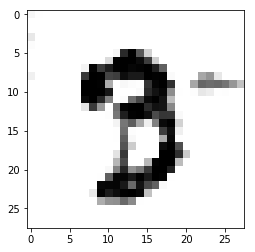

Estimate: [[0.6146107]]
Iteration: 36400 at 2019-08-19 05:46:12.761546


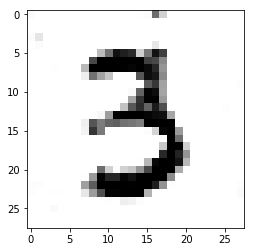

Estimate: [[-1.9676085]]
Iteration: 36500 at 2019-08-19 05:46:17.524902


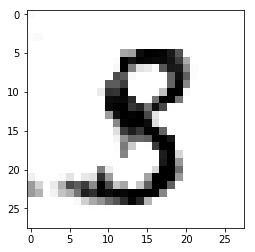

Estimate: [[2.2416158]]
Iteration: 36600 at 2019-08-19 05:46:22.295228


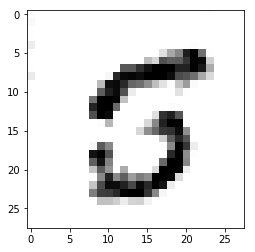

Estimate: [[-2.5065227]]
Iteration: 36700 at 2019-08-19 05:46:27.106161


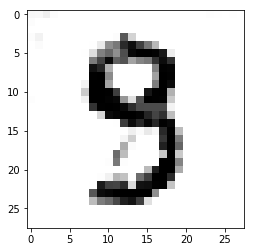

Estimate: [[-8.130651]]
Iteration: 36800 at 2019-08-19 05:46:31.936696


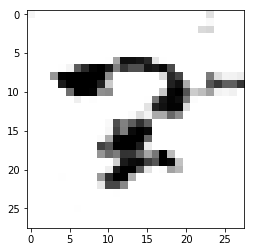

Estimate: [[15.184923]]
Iteration: 36900 at 2019-08-19 05:46:36.761965


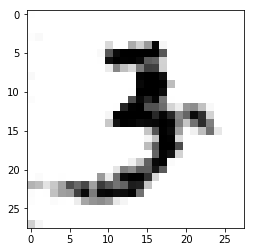

Estimate: [[7.933645]]
Iteration: 37000 at 2019-08-19 05:46:41.568204


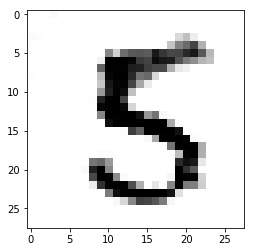

Estimate: [[11.54748]]
Iteration: 37100 at 2019-08-19 05:46:46.450421


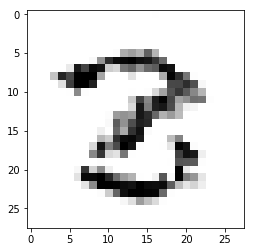

Estimate: [[-4.874791]]
Iteration: 37200 at 2019-08-19 05:46:51.331242


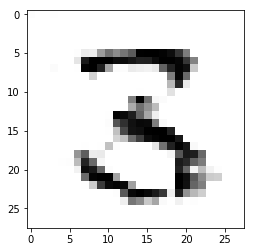

Estimate: [[-4.7113247]]
Iteration: 37300 at 2019-08-19 05:46:56.184401


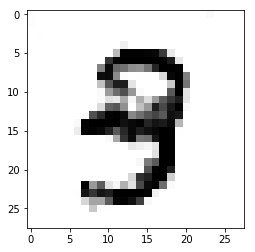

Estimate: [[-2.3551245]]
Iteration: 37400 at 2019-08-19 05:47:01.011885


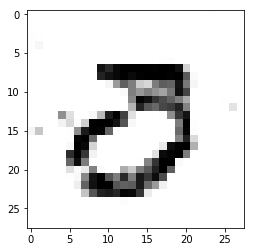

Estimate: [[-2.8737183]]
Iteration: 37500 at 2019-08-19 05:47:05.856433


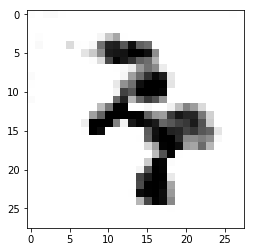

Estimate: [[0.81003577]]
Iteration: 37600 at 2019-08-19 05:47:10.725370


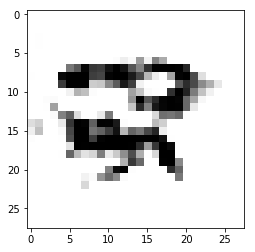

Estimate: [[-1.561304]]
Iteration: 37700 at 2019-08-19 05:47:15.582189


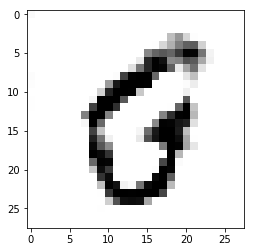

Estimate: [[8.560888]]
Iteration: 37800 at 2019-08-19 05:47:20.437307


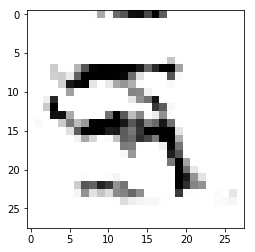

Estimate: [[-15.2833605]]
Iteration: 37900 at 2019-08-19 05:47:25.324476


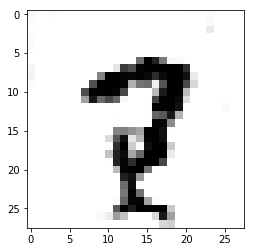

Estimate: [[17.051956]]
Iteration: 38000 at 2019-08-19 05:47:30.213563


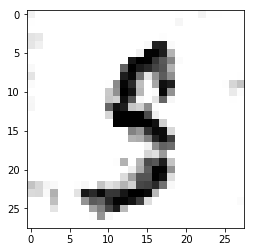

Estimate: [[-35.113514]]
Iteration: 38100 at 2019-08-19 05:47:35.116168


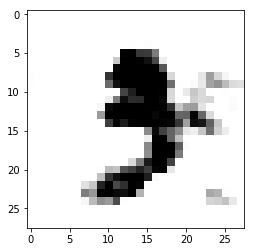

Estimate: [[15.504406]]
Iteration: 38200 at 2019-08-19 05:47:40.085587


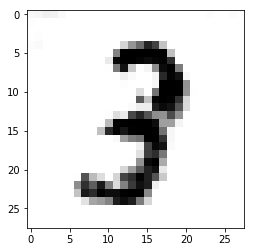

Estimate: [[2.831908]]
Iteration: 38300 at 2019-08-19 05:47:45.009461


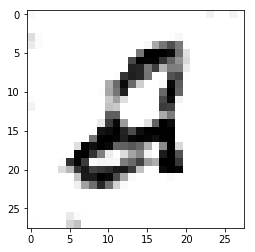

Estimate: [[5.9141116]]
Iteration: 38400 at 2019-08-19 05:47:49.921074


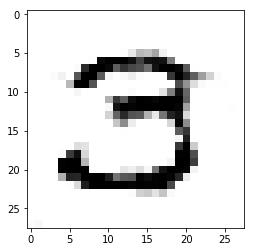

Estimate: [[-6.8360395]]
Iteration: 38500 at 2019-08-19 05:47:54.898559


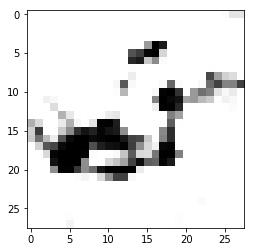

Estimate: [[7.476607]]
Iteration: 38600 at 2019-08-19 05:47:59.833759


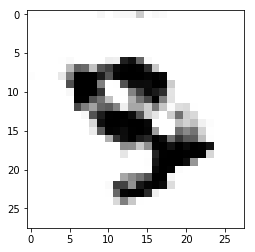

Estimate: [[-6.643978]]
Iteration: 38700 at 2019-08-19 05:48:04.817906


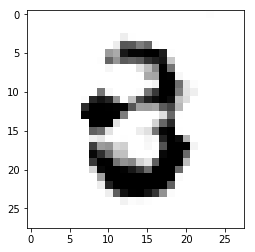

Estimate: [[0.05798159]]
Iteration: 38800 at 2019-08-19 05:48:09.854393


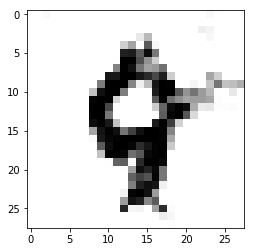

Estimate: [[8.281496]]
Iteration: 38900 at 2019-08-19 05:48:14.881120


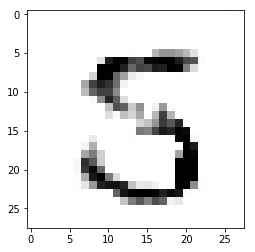

Estimate: [[-6.4191723]]
Iteration: 39000 at 2019-08-19 05:48:19.888915


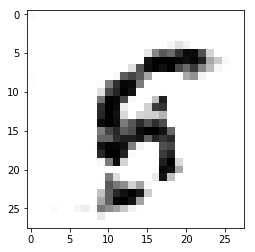

Estimate: [[-3.5814438]]
Iteration: 39100 at 2019-08-19 05:48:24.885258


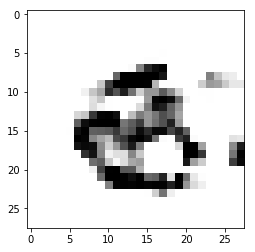

Estimate: [[-19.634125]]
Iteration: 39200 at 2019-08-19 05:48:29.894773


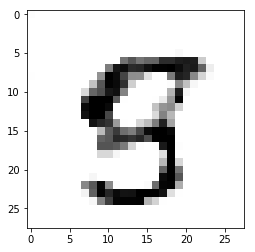

Estimate: [[-8.825484]]
Iteration: 39300 at 2019-08-19 05:48:34.951021


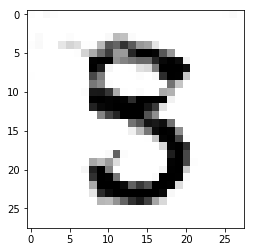

Estimate: [[3.6747322]]
Iteration: 39400 at 2019-08-19 05:48:39.970737


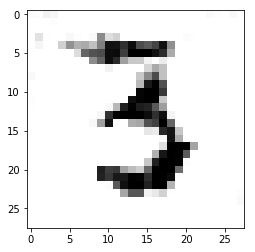

Estimate: [[-3.813896]]
Iteration: 39500 at 2019-08-19 05:48:45.012699


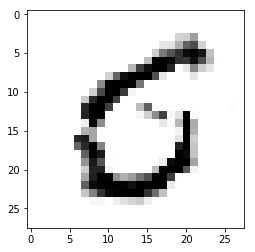

Estimate: [[-2.0952868]]
Iteration: 39600 at 2019-08-19 05:48:50.047418


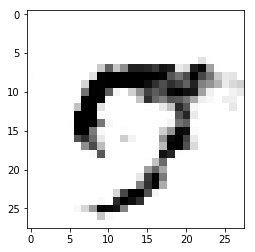

Estimate: [[-6.9870367]]
Iteration: 39700 at 2019-08-19 05:48:55.111794


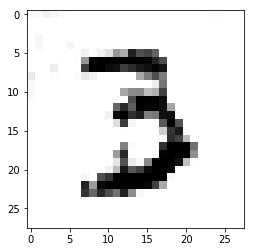

Estimate: [[-9.022997]]
Iteration: 39800 at 2019-08-19 05:49:00.157050


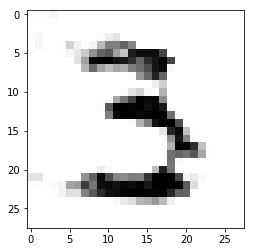

Estimate: [[-1.4690577]]
Iteration: 39900 at 2019-08-19 05:49:05.196598


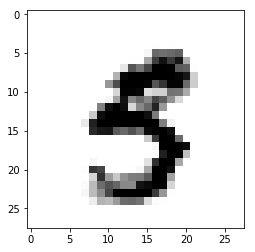

Estimate: [[-1.7637192]]
Iteration: 40000 at 2019-08-19 05:49:10.267131


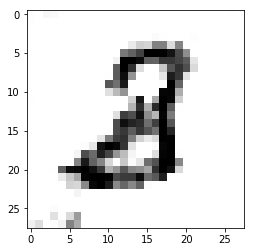

Estimate: [[-3.6794922]]
Iteration: 40100 at 2019-08-19 05:49:15.333530


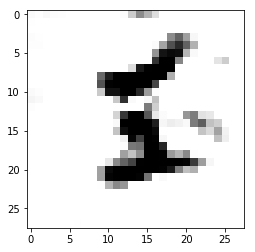

Estimate: [[6.4252887]]
Iteration: 40200 at 2019-08-19 05:49:20.362309


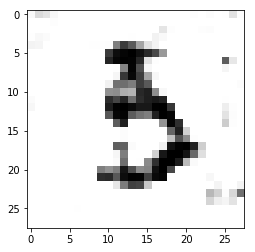

Estimate: [[-13.264758]]
Iteration: 40300 at 2019-08-19 05:49:25.455758


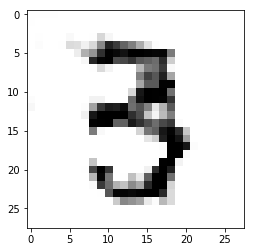

Estimate: [[-2.9302194]]
Iteration: 40400 at 2019-08-19 05:49:30.621245


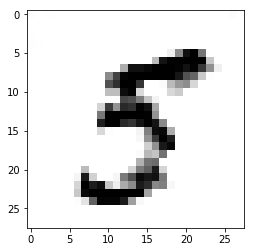

Estimate: [[1.2935163]]
Iteration: 40500 at 2019-08-19 05:49:35.691884


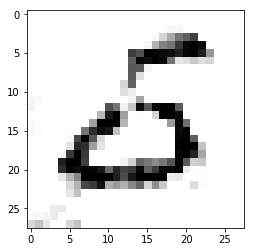

Estimate: [[-1.9560589]]
Iteration: 40600 at 2019-08-19 05:49:40.766998


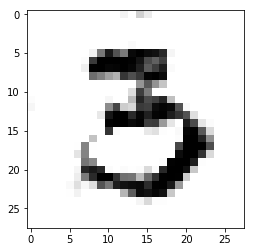

Estimate: [[-7.15667]]
Iteration: 40700 at 2019-08-19 05:49:45.913243


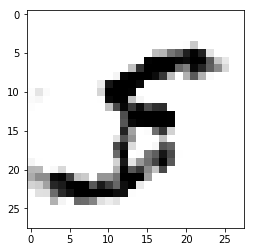

Estimate: [[6.0129766]]
Iteration: 40800 at 2019-08-19 05:49:51.112927


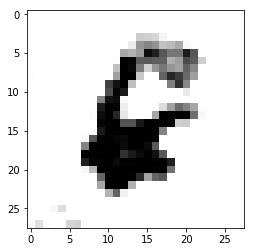

Estimate: [[2.0384698]]
Iteration: 40900 at 2019-08-19 05:49:56.311329


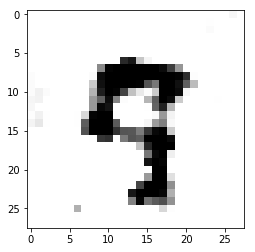

Estimate: [[0.60021216]]
Iteration: 41000 at 2019-08-19 05:50:01.461986


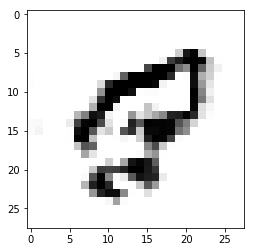

Estimate: [[3.728837]]
Iteration: 41100 at 2019-08-19 05:50:06.590236


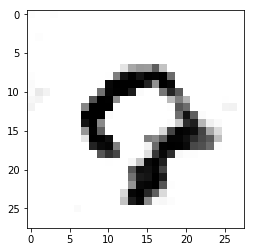

Estimate: [[-26.945559]]
Iteration: 41200 at 2019-08-19 05:50:11.808027


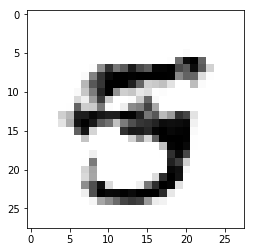

Estimate: [[-3.5579612]]
Iteration: 41300 at 2019-08-19 05:50:16.929649


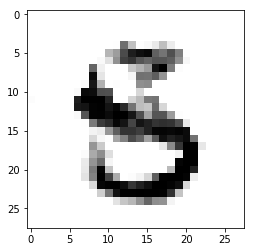

Estimate: [[-10.123422]]
Iteration: 41400 at 2019-08-19 05:50:22.070767


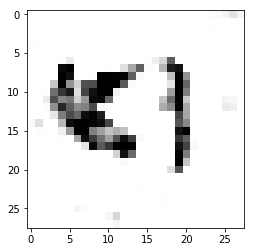

Estimate: [[2.2077792]]
Iteration: 41500 at 2019-08-19 05:50:27.313014


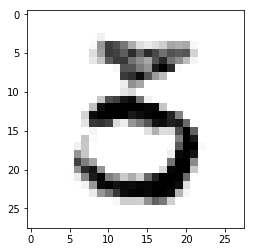

Estimate: [[-9.539188]]
Iteration: 41600 at 2019-08-19 05:50:33.036844


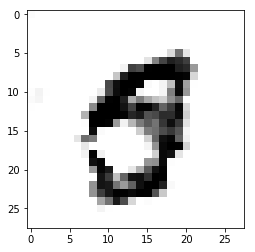

Estimate: [[11.22891]]
Iteration: 41700 at 2019-08-19 05:50:38.202630


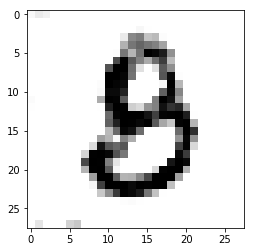

Estimate: [[6.0039315]]
Iteration: 41800 at 2019-08-19 05:50:43.378050


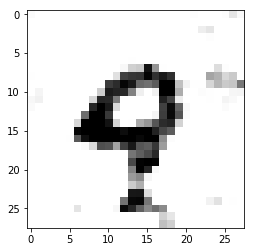

Estimate: [[4.4972906]]
Iteration: 41900 at 2019-08-19 05:50:48.576375


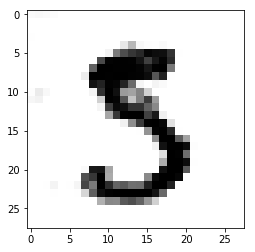

Estimate: [[-8.281709]]
Iteration: 42000 at 2019-08-19 05:50:53.787990


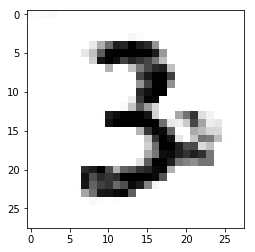

Estimate: [[-3.0529366]]
Iteration: 42100 at 2019-08-19 05:50:58.975943


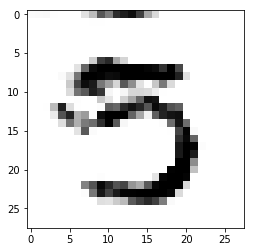

Estimate: [[-7.4401712]]
Iteration: 42200 at 2019-08-19 05:51:04.192750


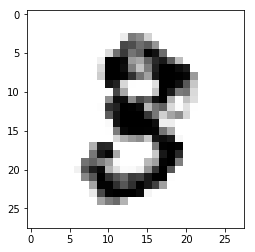

Estimate: [[2.5727673]]
Iteration: 42300 at 2019-08-19 05:51:09.422636


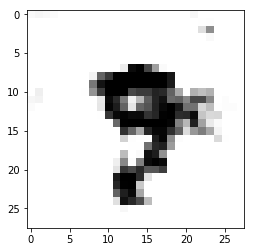

Estimate: [[4.8237596]]
Iteration: 42400 at 2019-08-19 05:51:14.688405


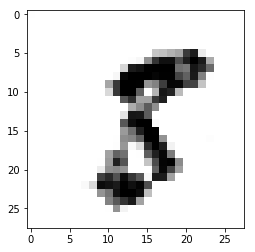

Estimate: [[-0.5646425]]
Iteration: 42500 at 2019-08-19 05:51:19.934477


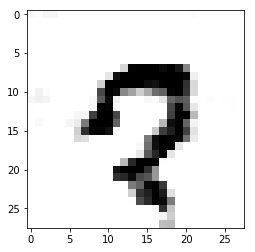

Estimate: [[3.2157454]]
Iteration: 42600 at 2019-08-19 05:51:25.236142


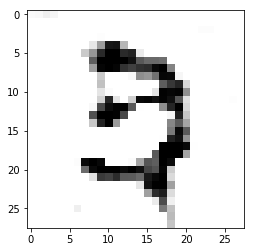

Estimate: [[-3.0255103]]
Iteration: 42700 at 2019-08-19 05:51:30.464913


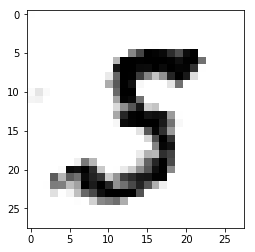

Estimate: [[-4.4706]]
Iteration: 42800 at 2019-08-19 05:51:35.708459


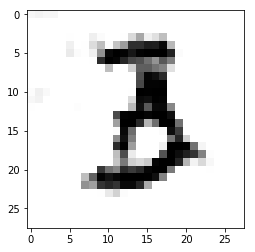

Estimate: [[11.723225]]
Iteration: 42900 at 2019-08-19 05:51:40.971319


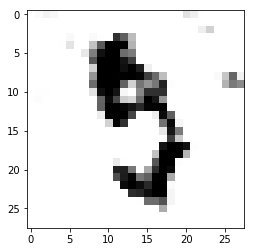

Estimate: [[6.945281]]
Iteration: 43000 at 2019-08-19 05:51:46.230031


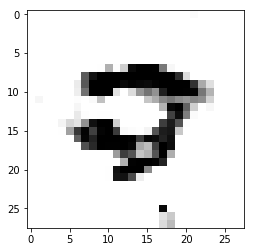

Estimate: [[-3.1805599]]
Iteration: 43100 at 2019-08-19 05:51:51.498846


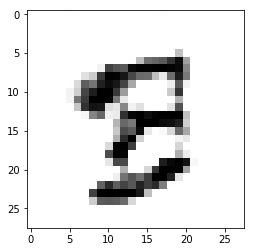

Estimate: [[1.5513813]]
Iteration: 43200 at 2019-08-19 05:51:56.845675


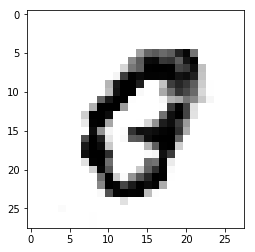

Estimate: [[-11.853051]]
Iteration: 43300 at 2019-08-19 05:52:02.142594


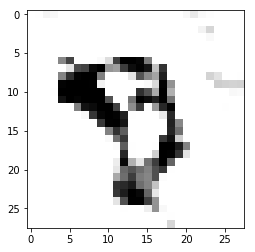

Estimate: [[38.1799]]
Iteration: 43400 at 2019-08-19 05:52:07.490730


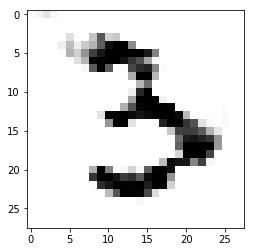

Estimate: [[-9.248724]]
Iteration: 43500 at 2019-08-19 05:52:12.832806


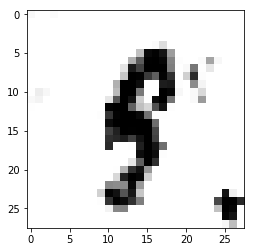

Estimate: [[8.256817]]
Iteration: 43600 at 2019-08-19 05:52:18.151028


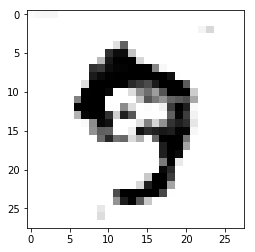

Estimate: [[-0.4765758]]
Iteration: 43700 at 2019-08-19 05:52:23.549351


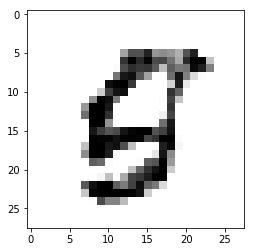

Estimate: [[10.006008]]
Iteration: 43800 at 2019-08-19 05:52:28.914365


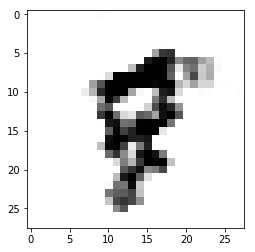

Estimate: [[25.2552]]
Iteration: 43900 at 2019-08-19 05:52:34.247790


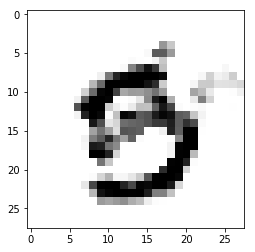

Estimate: [[-11.63533]]
Iteration: 44000 at 2019-08-19 05:52:39.625770


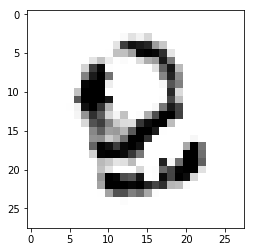

Estimate: [[-4.6327815]]
Iteration: 44100 at 2019-08-19 05:52:44.940125


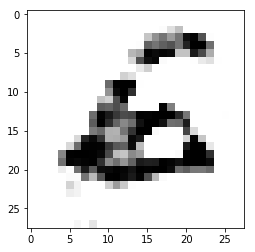

Estimate: [[15.110373]]
Iteration: 44200 at 2019-08-19 05:52:50.323838


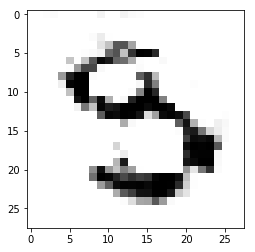

Estimate: [[0.46172357]]
Iteration: 44300 at 2019-08-19 05:52:55.692734


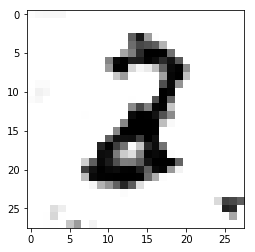

Estimate: [[2.82604]]
Iteration: 44400 at 2019-08-19 05:53:01.081283


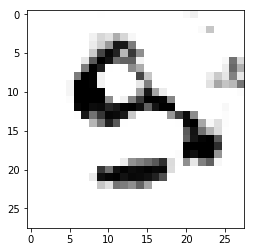

Estimate: [[-13.204632]]
Iteration: 44500 at 2019-08-19 05:53:06.475670


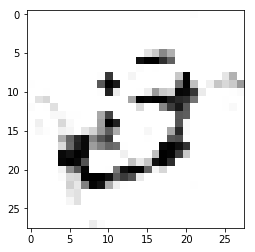

Estimate: [[-17.352507]]
Iteration: 44600 at 2019-08-19 05:53:11.876366


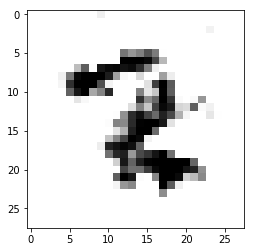

Estimate: [[4.3962846]]
Iteration: 44700 at 2019-08-19 05:53:17.272349


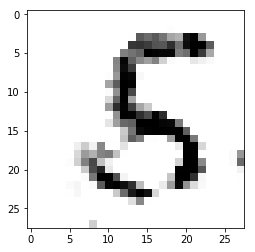

Estimate: [[-13.662812]]
Iteration: 44800 at 2019-08-19 05:53:22.729314


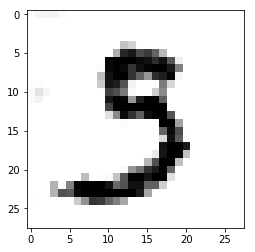

Estimate: [[-1.4144187]]
Iteration: 44900 at 2019-08-19 05:53:28.215689


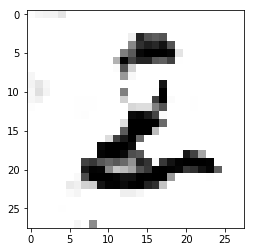

Estimate: [[-9.407476]]
Iteration: 45000 at 2019-08-19 05:53:33.655399


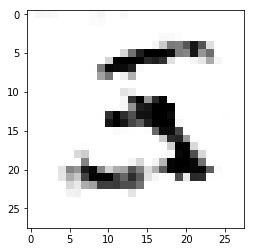

Estimate: [[-19.807848]]
Iteration: 45100 at 2019-08-19 05:53:39.046722


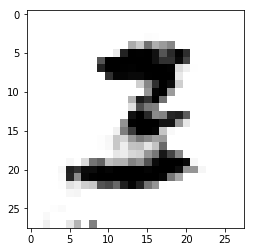

Estimate: [[10.578054]]
Iteration: 45200 at 2019-08-19 05:53:44.455402


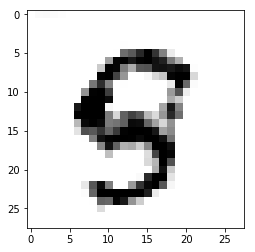

Estimate: [[-3.4717212]]
Iteration: 45300 at 2019-08-19 05:53:49.873274


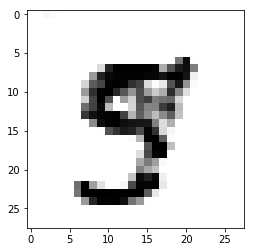

Estimate: [[-13.427767]]
Iteration: 45400 at 2019-08-19 05:53:55.330849


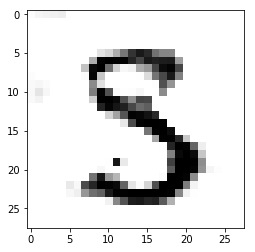

Estimate: [[-2.8903897]]
Iteration: 45500 at 2019-08-19 05:54:00.793606


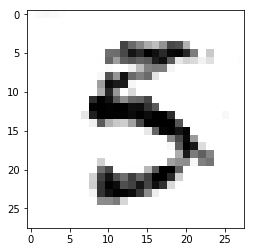

Estimate: [[10.148603]]
Iteration: 45600 at 2019-08-19 05:54:06.255157


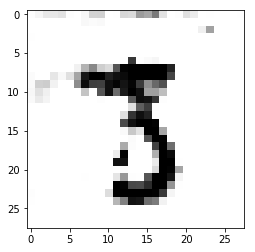

Estimate: [[-3.5786078]]
Iteration: 45700 at 2019-08-19 05:54:11.713268


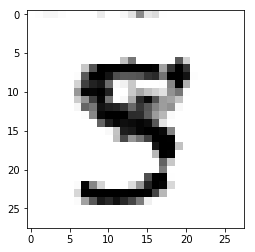

Estimate: [[0.20463794]]
Iteration: 45800 at 2019-08-19 05:54:17.160976


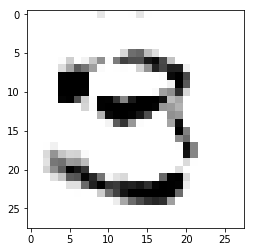

Estimate: [[0.36929244]]
Iteration: 45900 at 2019-08-19 05:54:22.681898


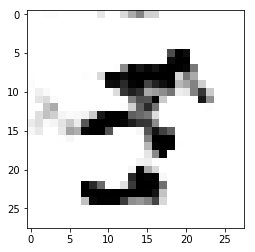

Estimate: [[16.05056]]
Iteration: 46000 at 2019-08-19 05:54:28.193555


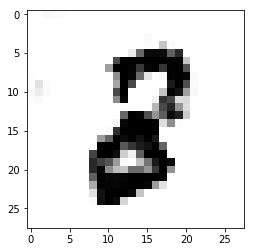

Estimate: [[7.7993307]]
Iteration: 46100 at 2019-08-19 05:54:33.660436


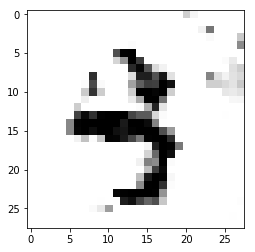

Estimate: [[-6.898897]]
Iteration: 46200 at 2019-08-19 05:54:39.150617


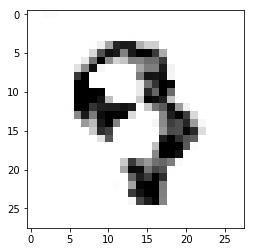

Estimate: [[4.748553]]
Iteration: 46300 at 2019-08-19 05:54:44.629173


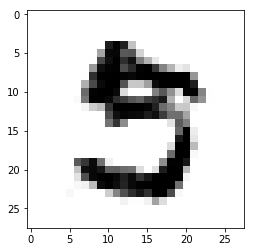

Estimate: [[0.38050753]]
Iteration: 46400 at 2019-08-19 05:54:50.181768


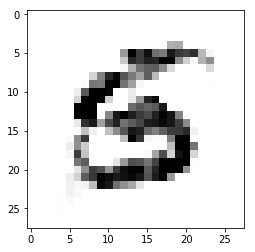

Estimate: [[-11.105039]]
Iteration: 46500 at 2019-08-19 05:54:55.768599


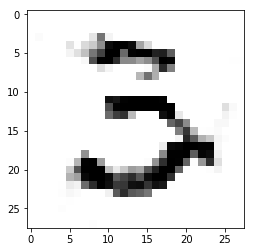

Estimate: [[5.5072427]]
Iteration: 46600 at 2019-08-19 05:55:01.415624


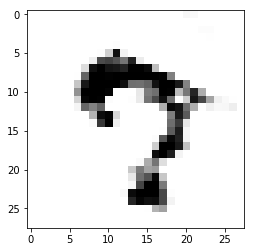

Estimate: [[-7.129432]]
Iteration: 46700 at 2019-08-19 05:55:06.992003


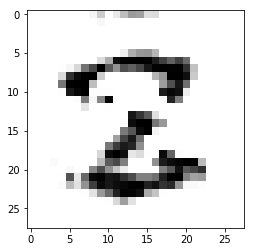

Estimate: [[-16.380966]]
Iteration: 46800 at 2019-08-19 05:55:12.510988


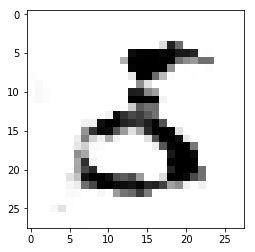

Estimate: [[-12.624651]]
Iteration: 46900 at 2019-08-19 05:55:18.125451


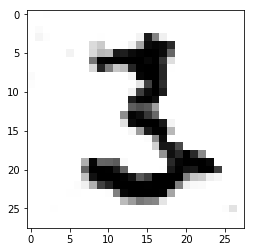

Estimate: [[-4.949798]]
Iteration: 47000 at 2019-08-19 05:55:23.724248


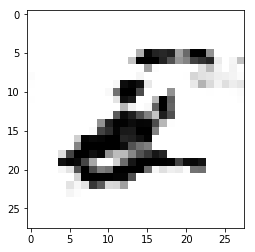

Estimate: [[-5.6357684]]
Iteration: 47100 at 2019-08-19 05:55:29.292652


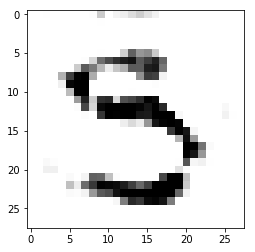

Estimate: [[11.052432]]
Iteration: 47200 at 2019-08-19 05:55:34.807182


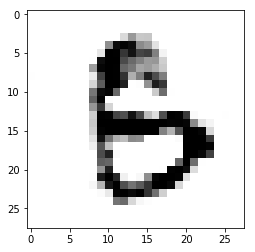

Estimate: [[7.058592]]
Iteration: 47300 at 2019-08-19 05:55:40.400611


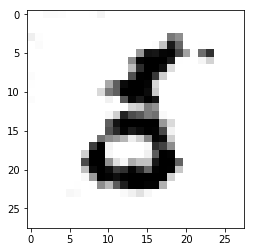

Estimate: [[10.620225]]
Iteration: 47400 at 2019-08-19 05:55:45.960498


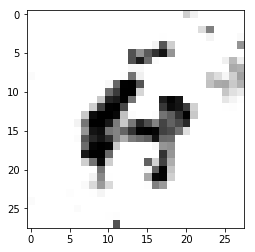

Estimate: [[-5.1871543]]
Iteration: 47500 at 2019-08-19 05:55:51.538352


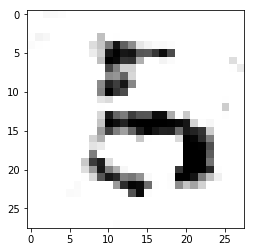

Estimate: [[-13.421706]]
Iteration: 47600 at 2019-08-19 05:55:57.170793


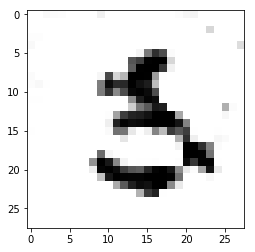

Estimate: [[6.0611243]]
Iteration: 47700 at 2019-08-19 05:56:02.793081


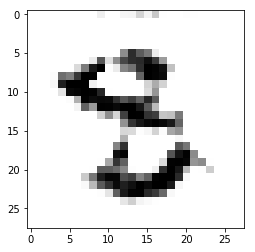

Estimate: [[4.718889]]
Iteration: 47800 at 2019-08-19 05:56:08.449862


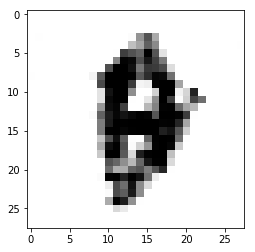

Estimate: [[22.310802]]
Iteration: 47900 at 2019-08-19 05:56:14.106593


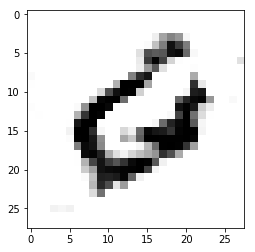

Estimate: [[27.354052]]
Iteration: 48000 at 2019-08-19 05:56:19.734315


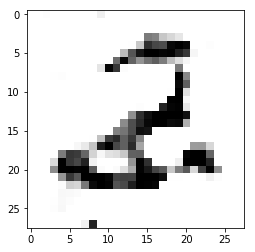

Estimate: [[5.165603]]
Iteration: 48100 at 2019-08-19 05:56:25.418780


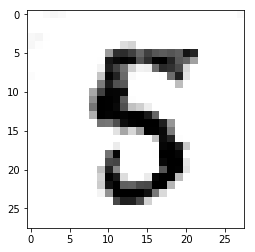

Estimate: [[7.8938766]]
Iteration: 48200 at 2019-08-19 05:56:31.070629


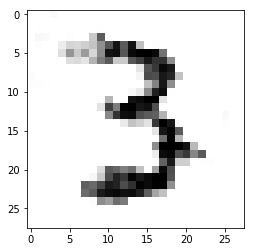

Estimate: [[-13.069076]]
Iteration: 48300 at 2019-08-19 05:56:36.694921


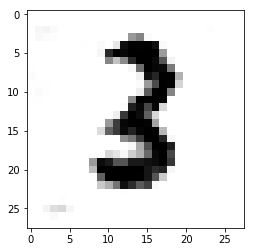

Estimate: [[8.305324]]
Iteration: 48400 at 2019-08-19 05:56:42.351004


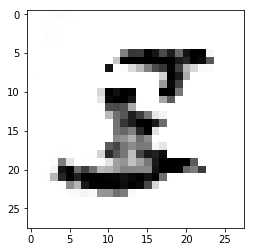

Estimate: [[7.2490807]]
Iteration: 48500 at 2019-08-19 05:56:48.004409


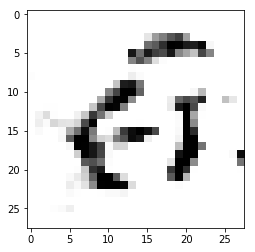

Estimate: [[-15.829636]]
Iteration: 48600 at 2019-08-19 05:56:53.671251


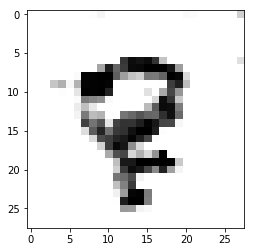

Estimate: [[-8.233048]]
Iteration: 48700 at 2019-08-19 05:56:59.334757


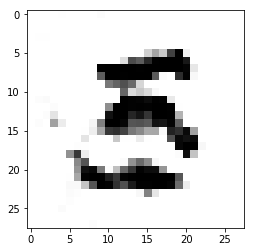

Estimate: [[-9.901856]]
Iteration: 48800 at 2019-08-19 05:57:04.992977


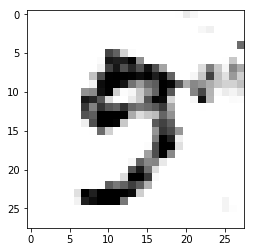

Estimate: [[-16.039064]]
Iteration: 48900 at 2019-08-19 05:57:10.706575


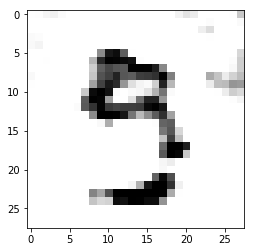

Estimate: [[11.446555]]
Iteration: 49000 at 2019-08-19 05:57:16.453128


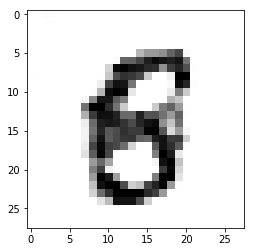

Estimate: [[5.904798]]
Iteration: 49100 at 2019-08-19 05:57:22.164891


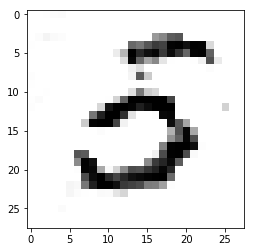

Estimate: [[2.6083903]]
Iteration: 49200 at 2019-08-19 05:57:28.010969


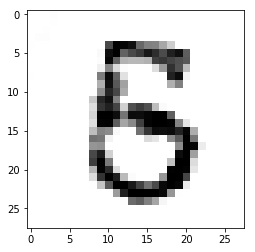

Estimate: [[7.7160745]]
Iteration: 49300 at 2019-08-19 05:57:33.790491


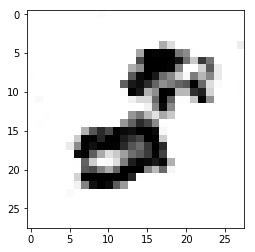

Estimate: [[18.263062]]
Iteration: 49400 at 2019-08-19 05:57:39.503350


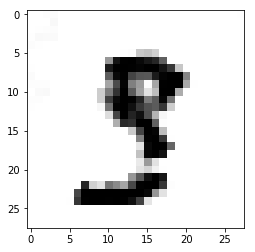

Estimate: [[-15.507851]]
Iteration: 49500 at 2019-08-19 05:57:45.254734


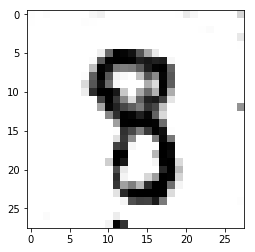

Estimate: [[-0.48983103]]
Iteration: 49600 at 2019-08-19 05:57:50.997823


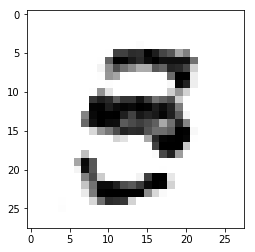

Estimate: [[4.296243]]
Iteration: 49700 at 2019-08-19 05:57:57.424395


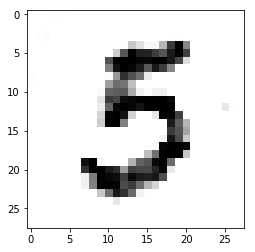

Estimate: [[1.8939601]]
Iteration: 49800 at 2019-08-19 05:58:03.214605


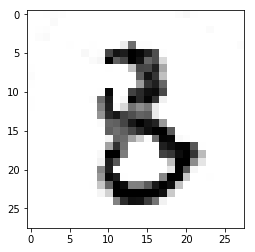

Estimate: [[-23.71422]]
Iteration: 49900 at 2019-08-19 05:58:08.974494


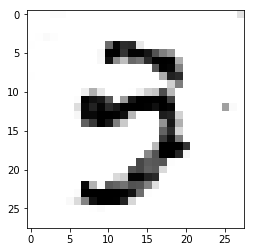

Estimate: [[13.531723]]
Iteration: 50000 at 2019-08-19 05:58:14.775025


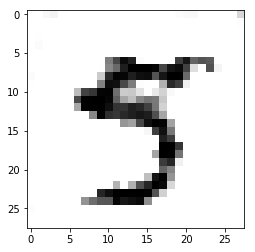

Estimate: [[-5.85395]]
Iteration: 50100 at 2019-08-19 05:58:20.592207


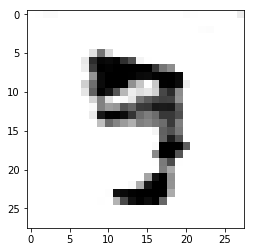

Estimate: [[-10.385788]]
Iteration: 50200 at 2019-08-19 05:58:26.413300


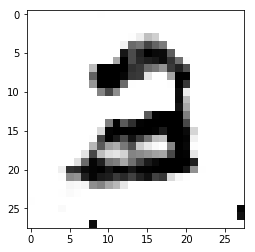

Estimate: [[21.139925]]
Iteration: 50300 at 2019-08-19 05:58:32.328925


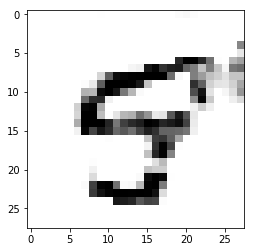

Estimate: [[0.1771391]]
Iteration: 50400 at 2019-08-19 05:58:38.181179


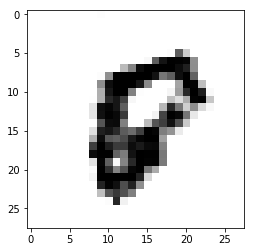

Estimate: [[13.116759]]
Iteration: 50500 at 2019-08-19 05:58:44.015301


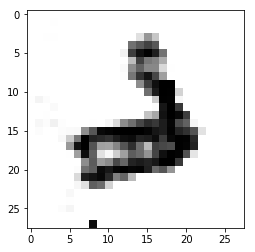

Estimate: [[28.178694]]
Iteration: 50600 at 2019-08-19 05:58:49.892638


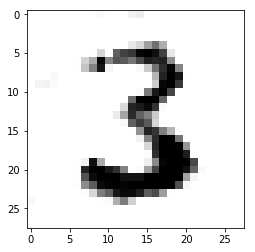

Estimate: [[-10.420712]]
Iteration: 50700 at 2019-08-19 05:58:55.782770


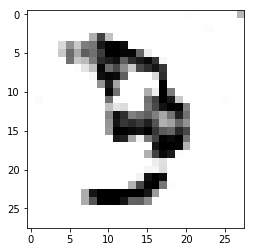

Estimate: [[1.4452555]]
Iteration: 50800 at 2019-08-19 05:59:01.656042


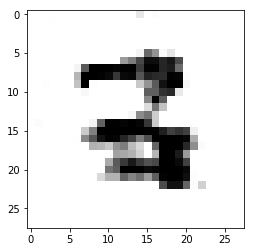

Estimate: [[-0.07931349]]
Iteration: 50900 at 2019-08-19 05:59:07.560905


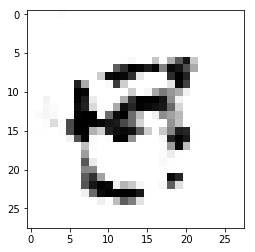

Estimate: [[7.388429]]
Iteration: 51000 at 2019-08-19 05:59:13.455850


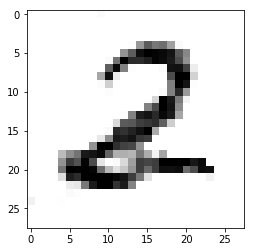

Estimate: [[14.798317]]
Iteration: 51100 at 2019-08-19 05:59:19.361575


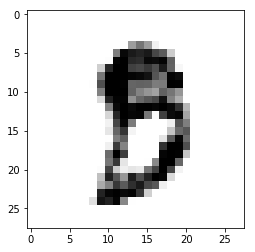

Estimate: [[37.991867]]
Iteration: 51200 at 2019-08-19 05:59:25.277462


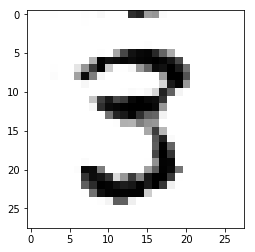

Estimate: [[-10.686177]]
Iteration: 51300 at 2019-08-19 05:59:31.237163


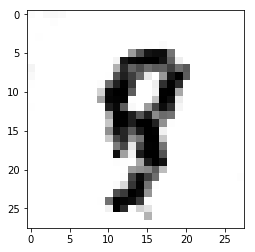

Estimate: [[-17.183796]]
Iteration: 51400 at 2019-08-19 05:59:37.224772


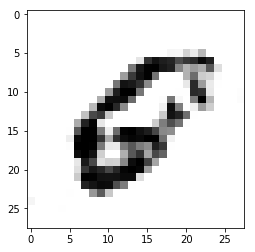

Estimate: [[36.890583]]
Iteration: 51500 at 2019-08-19 05:59:43.190207


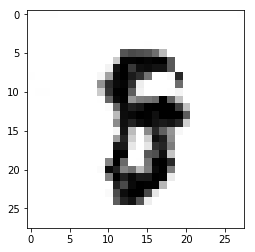

Estimate: [[-5.0841465]]
Iteration: 51600 at 2019-08-19 05:59:49.125402


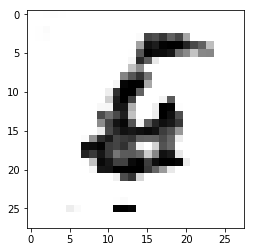

Estimate: [[-16.915297]]
Iteration: 51700 at 2019-08-19 05:59:55.090837


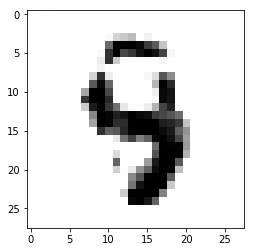

Estimate: [[-8.00225]]
Iteration: 51800 at 2019-08-19 06:00:01.105165


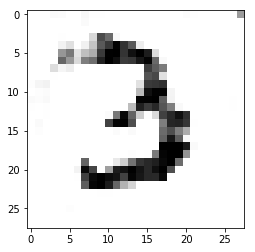

Estimate: [[0.7175075]]
Iteration: 51900 at 2019-08-19 06:00:07.199598


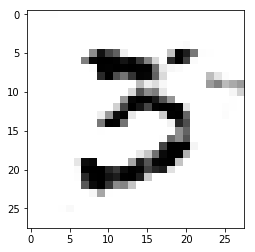

Estimate: [[5.129868]]
Iteration: 52000 at 2019-08-19 06:00:13.335855


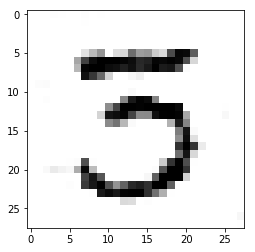

Estimate: [[9.412239]]
Iteration: 52100 at 2019-08-19 06:00:19.463647


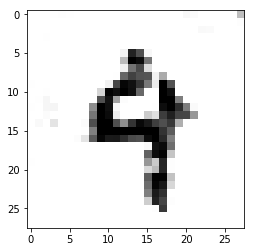

Estimate: [[-15.92764]]
Iteration: 52200 at 2019-08-19 06:00:25.554291


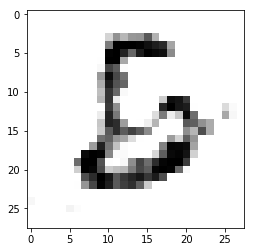

Estimate: [[-16.594055]]
Iteration: 52300 at 2019-08-19 06:00:31.579085


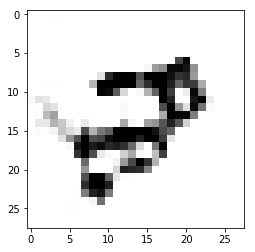

Estimate: [[10.136743]]
Iteration: 52400 at 2019-08-19 06:00:37.634148


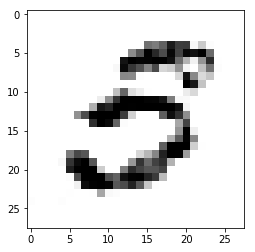

Estimate: [[8.423784]]
Iteration: 52500 at 2019-08-19 06:00:43.756231


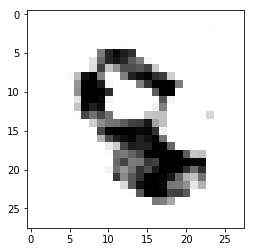

Estimate: [[-2.8848217]]
Iteration: 52600 at 2019-08-19 06:00:49.809384


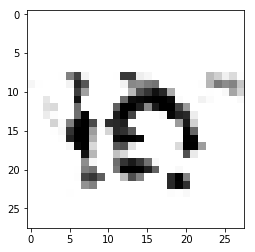

Estimate: [[-30.088787]]
Iteration: 52700 at 2019-08-19 06:00:55.854565


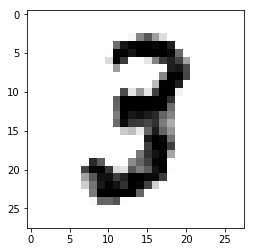

Estimate: [[-8.270734]]
Iteration: 52800 at 2019-08-19 06:01:01.900783


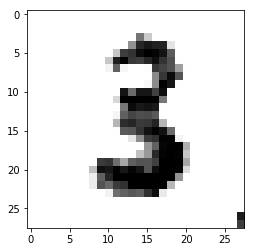

Estimate: [[-5.8226104]]
Iteration: 52900 at 2019-08-19 06:01:07.960532


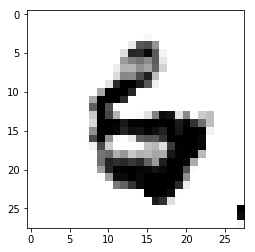

Estimate: [[-0.24812719]]
Iteration: 53000 at 2019-08-19 06:01:14.042632


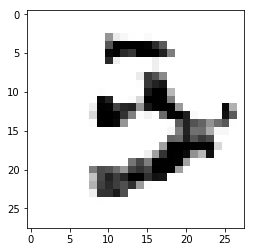

Estimate: [[12.701243]]
Iteration: 53100 at 2019-08-19 06:01:20.157532


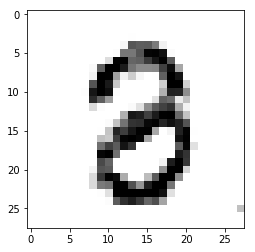

Estimate: [[-19.60293]]
Iteration: 53200 at 2019-08-19 06:01:26.258425


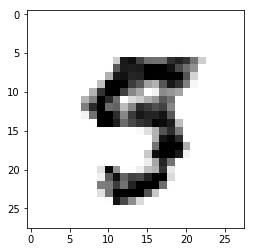

Estimate: [[4.768597]]
Iteration: 53300 at 2019-08-19 06:01:32.386554


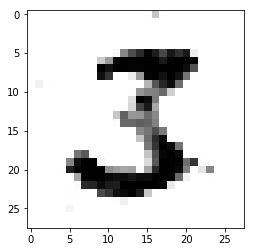

Estimate: [[3.0483236]]
Iteration: 53400 at 2019-08-19 06:01:38.541775


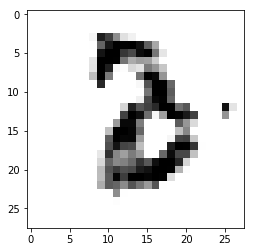

Estimate: [[-31.778112]]
Iteration: 53500 at 2019-08-19 06:01:44.641580


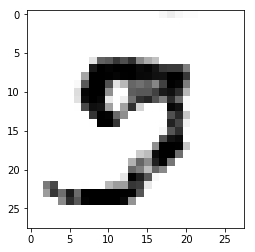

Estimate: [[31.078793]]
Iteration: 53600 at 2019-08-19 06:01:50.814107


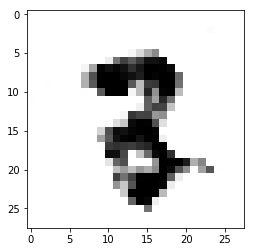

Estimate: [[-21.709146]]
Iteration: 53700 at 2019-08-19 06:01:56.949942


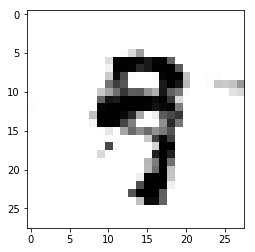

Estimate: [[-8.502825]]
Iteration: 53800 at 2019-08-19 06:02:03.113407


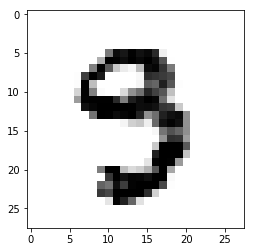

Estimate: [[1.3555782]]
Iteration: 53900 at 2019-08-19 06:02:09.280529


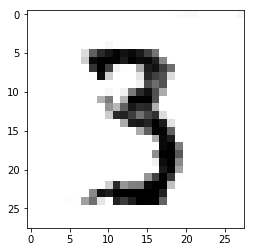

Estimate: [[-0.9508605]]
Iteration: 54000 at 2019-08-19 06:02:15.442147


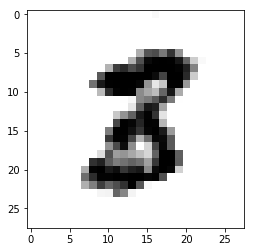

Estimate: [[0.73916066]]
Iteration: 54100 at 2019-08-19 06:02:21.586674


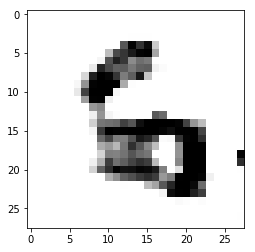

Estimate: [[-17.619228]]
Iteration: 54200 at 2019-08-19 06:02:27.788499


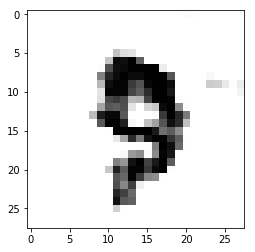

Estimate: [[9.061005]]
Iteration: 54300 at 2019-08-19 06:02:33.994443


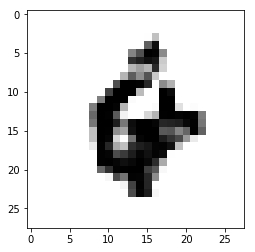

Estimate: [[21.66198]]
Iteration: 54400 at 2019-08-19 06:02:40.216463


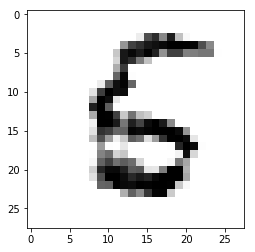

Estimate: [[1.7304344]]
Iteration: 54500 at 2019-08-19 06:02:46.391462


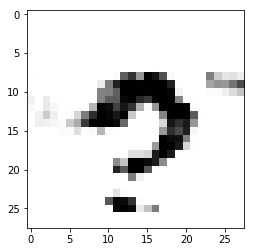

Estimate: [[-0.8268111]]
Iteration: 54600 at 2019-08-19 06:02:52.630473


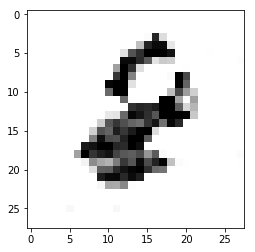

Estimate: [[14.592911]]
Iteration: 54700 at 2019-08-19 06:02:58.973401


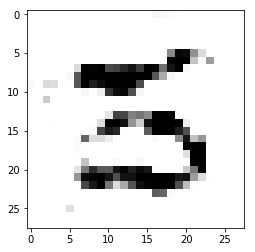

Estimate: [[15.270332]]
Iteration: 54800 at 2019-08-19 06:03:05.228254


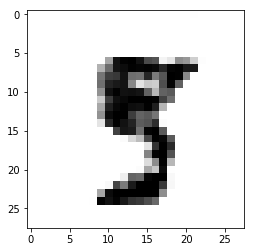

Estimate: [[-7.2947135]]
Iteration: 54900 at 2019-08-19 06:03:11.496816


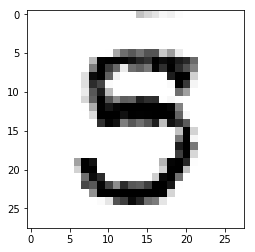

Estimate: [[12.786972]]
Iteration: 55000 at 2019-08-19 06:03:17.737604


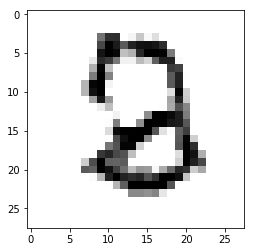

Estimate: [[6.7938695]]
Iteration: 55100 at 2019-08-19 06:03:23.995167


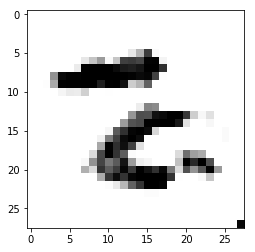

Estimate: [[5.6991262]]
Iteration: 55200 at 2019-08-19 06:03:30.273540


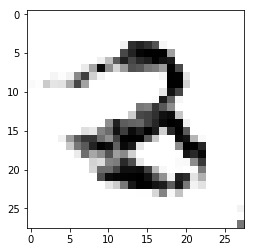

Estimate: [[-18.872232]]
Iteration: 55300 at 2019-08-19 06:03:36.517714


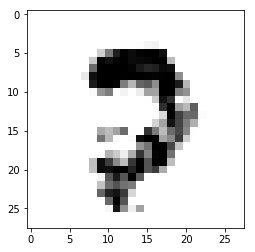

Estimate: [[-24.448223]]
Iteration: 55400 at 2019-08-19 06:03:42.815714


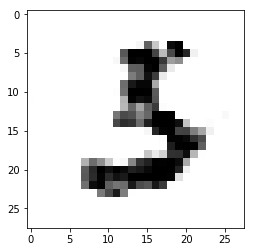

Estimate: [[-5.0201135]]
Iteration: 55500 at 2019-08-19 06:03:49.095533


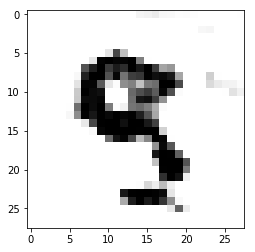

Estimate: [[-3.3756642]]
Iteration: 55600 at 2019-08-19 06:03:55.373934


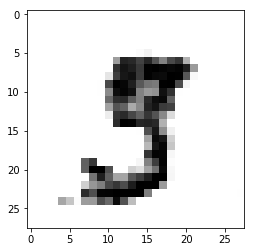

Estimate: [[0.46507078]]
Iteration: 55700 at 2019-08-19 06:04:01.649253


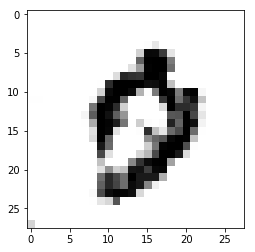

Estimate: [[2.6188445]]
Iteration: 55800 at 2019-08-19 06:04:08.039430


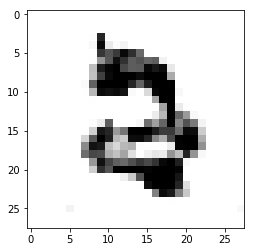

Estimate: [[-18.179897]]
Iteration: 55900 at 2019-08-19 06:04:14.431862


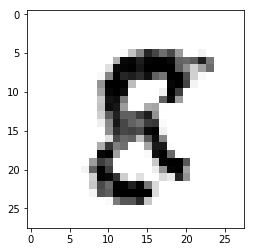

Estimate: [[18.884335]]
Iteration: 56000 at 2019-08-19 06:04:20.823496


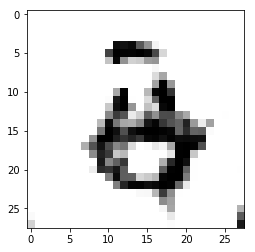

Estimate: [[-11.71564]]
Iteration: 56100 at 2019-08-19 06:04:27.154057


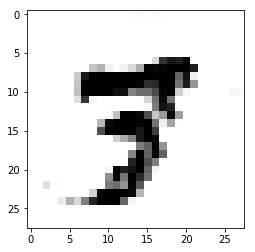

Estimate: [[16.182161]]
Iteration: 56200 at 2019-08-19 06:04:33.507298


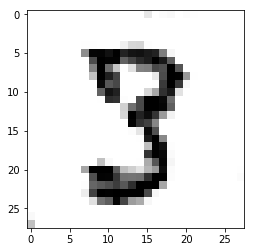

Estimate: [[-30.194815]]
Iteration: 56300 at 2019-08-19 06:04:39.862563


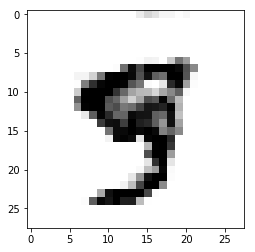

Estimate: [[-15.784494]]
Iteration: 56400 at 2019-08-19 06:04:46.231042


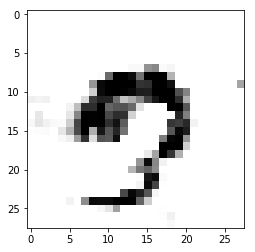

Estimate: [[-1.3439254]]
Iteration: 56500 at 2019-08-19 06:04:52.550139


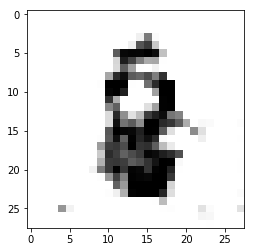

Estimate: [[0.47401452]]
Iteration: 56600 at 2019-08-19 06:04:58.903999


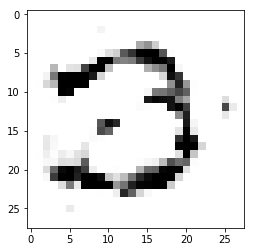

Estimate: [[21.016691]]
Iteration: 56700 at 2019-08-19 06:05:05.281255


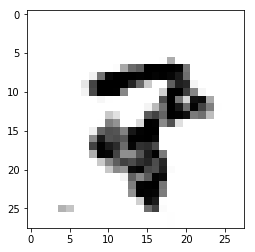

Estimate: [[11.779863]]
Iteration: 56800 at 2019-08-19 06:05:11.670450


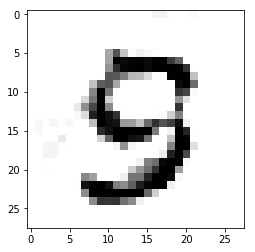

Estimate: [[7.1524487]]
Iteration: 56900 at 2019-08-19 06:05:18.172839


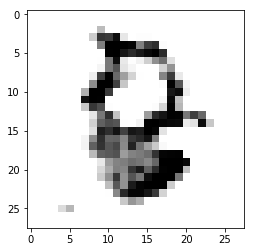

Estimate: [[3.23299]]
Iteration: 57000 at 2019-08-19 06:05:24.702073


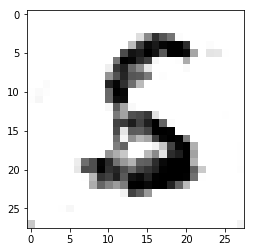

Estimate: [[-7.1956844]]
Iteration: 57100 at 2019-08-19 06:05:31.184603


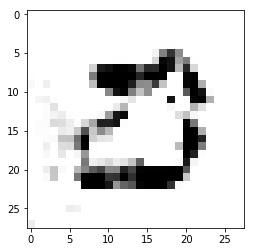

Estimate: [[-12.911885]]
Iteration: 57200 at 2019-08-19 06:05:37.614157


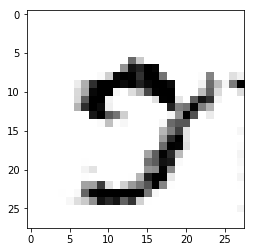

Estimate: [[-7.4528933]]
Iteration: 57300 at 2019-08-19 06:05:44.032425


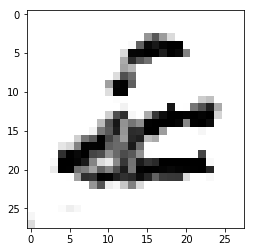

Estimate: [[24.58468]]
Iteration: 57400 at 2019-08-19 06:05:50.420036


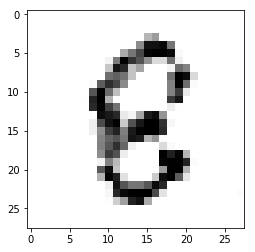

Estimate: [[8.812866]]
Iteration: 57500 at 2019-08-19 06:05:56.843165


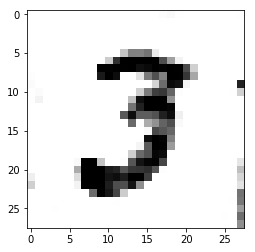

Estimate: [[-6.2536397]]
Iteration: 57600 at 2019-08-19 06:06:03.287642


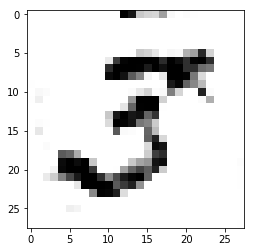

Estimate: [[2.9610214]]
Iteration: 57700 at 2019-08-19 06:06:09.750220


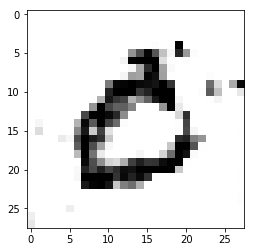

Estimate: [[-8.199041]]
Iteration: 57800 at 2019-08-19 06:06:16.205254


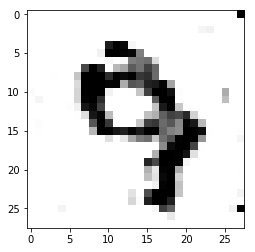

Estimate: [[19.214182]]
Iteration: 57900 at 2019-08-19 06:06:22.646735


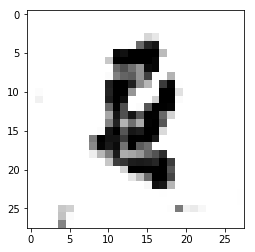

Estimate: [[1.4014205]]
Iteration: 58000 at 2019-08-19 06:06:29.217176


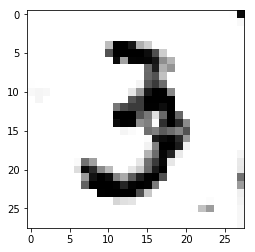

Estimate: [[1.6317883]]
Iteration: 58100 at 2019-08-19 06:06:35.674312


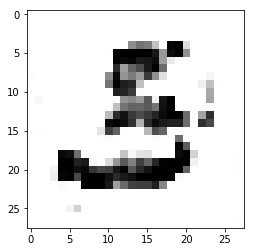

Estimate: [[-10.345133]]
Iteration: 58200 at 2019-08-19 06:06:42.167164


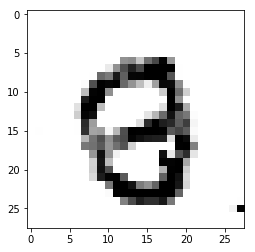

Estimate: [[-22.6614]]
Iteration: 58300 at 2019-08-19 06:06:48.648742


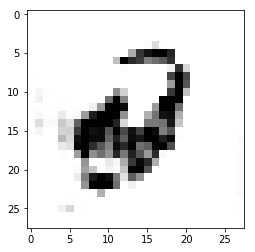

Estimate: [[8.183899]]
Iteration: 58400 at 2019-08-19 06:06:55.167472


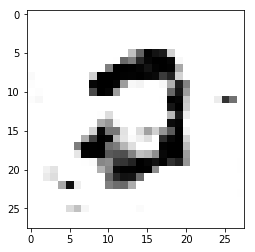

Estimate: [[-11.585614]]
Iteration: 58500 at 2019-08-19 06:07:01.699785


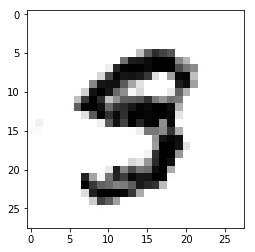

Estimate: [[-11.315796]]
Iteration: 58600 at 2019-08-19 06:07:08.207820


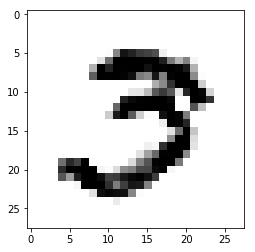

Estimate: [[1.6642537]]
Iteration: 58700 at 2019-08-19 06:07:14.708205


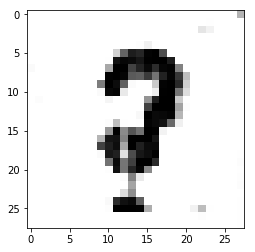

Estimate: [[-3.2685535]]
Iteration: 58800 at 2019-08-19 06:07:21.210262


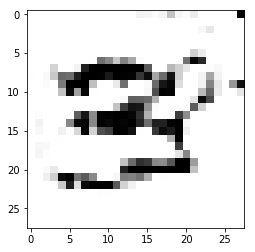

Estimate: [[-10.473283]]
Iteration: 58900 at 2019-08-19 06:07:27.756078


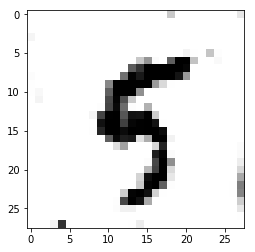

Estimate: [[-1.7440464]]
Iteration: 59000 at 2019-08-19 06:07:34.268899


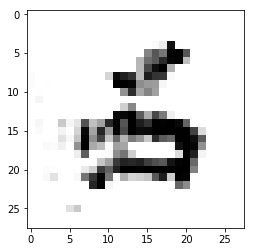

Estimate: [[-9.884993]]
Iteration: 59100 at 2019-08-19 06:07:41.575490


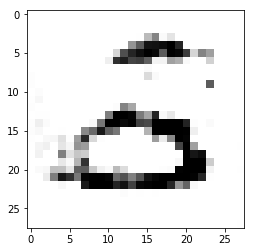

Estimate: [[4.065036]]
Iteration: 59200 at 2019-08-19 06:07:48.138214


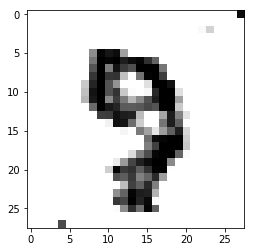

Estimate: [[38.222816]]
Iteration: 59300 at 2019-08-19 06:07:54.671936


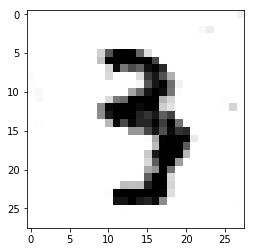

Estimate: [[-9.486315]]
Iteration: 59400 at 2019-08-19 06:08:01.265066


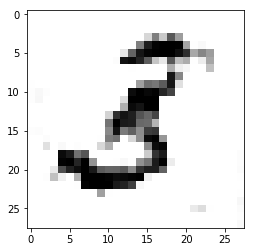

Estimate: [[-1.3498888]]
Iteration: 59500 at 2019-08-19 06:08:07.883545


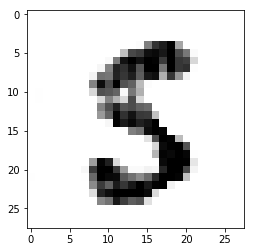

Estimate: [[-6.8405876]]
Iteration: 59600 at 2019-08-19 06:08:14.553812


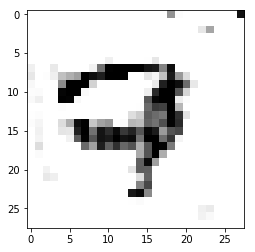

Estimate: [[7.286207]]
Iteration: 59700 at 2019-08-19 06:08:21.202726


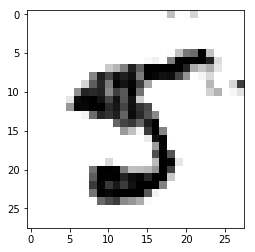

Estimate: [[3.2427623]]
Iteration: 59800 at 2019-08-19 06:08:27.856765


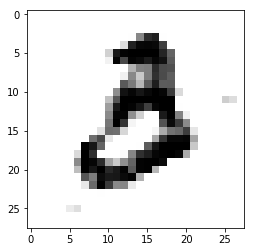

Estimate: [[37.746826]]
Iteration: 59900 at 2019-08-19 06:08:34.483493


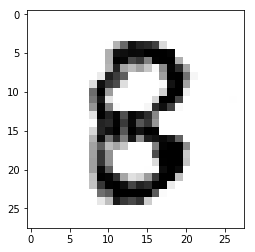

Estimate: [[-1.2228725]]
Iteration: 60000 at 2019-08-19 06:08:41.129285


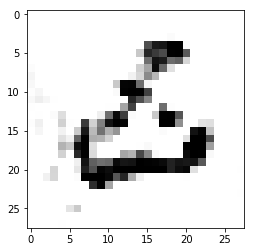

Estimate: [[13.070431]]
Iteration: 60100 at 2019-08-19 06:08:47.755433


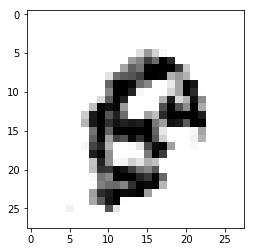

Estimate: [[-11.278749]]
Iteration: 60200 at 2019-08-19 06:08:54.436726


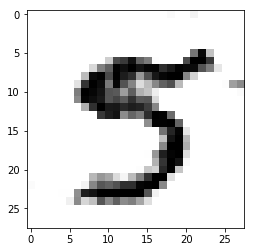

Estimate: [[-0.7144018]]
Iteration: 60300 at 2019-08-19 06:09:01.057423


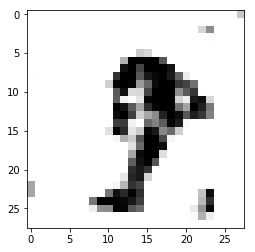

Estimate: [[-9.668108]]
Iteration: 60400 at 2019-08-19 06:09:07.691397


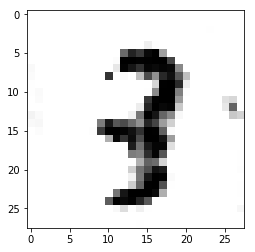

Estimate: [[-35.48848]]
Iteration: 60500 at 2019-08-19 06:09:14.316834


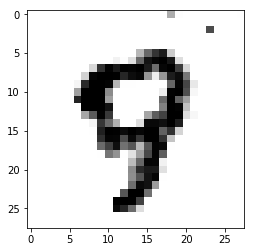

Estimate: [[13.704567]]
Iteration: 60600 at 2019-08-19 06:09:20.950847


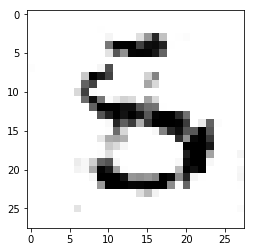

Estimate: [[-2.758297]]
Iteration: 60700 at 2019-08-19 06:09:27.604971


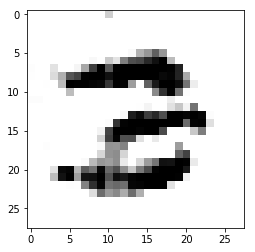

Estimate: [[14.815707]]
Iteration: 60800 at 2019-08-19 06:09:34.346686


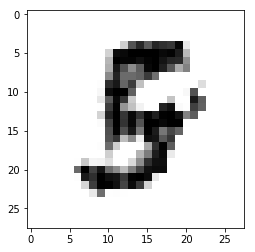

Estimate: [[-24.032553]]
Iteration: 60900 at 2019-08-19 06:09:41.063309


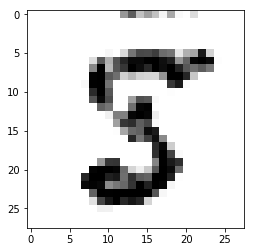

Estimate: [[-16.326412]]
Iteration: 61000 at 2019-08-19 06:09:47.723560


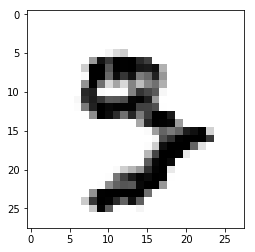

Estimate: [[-3.0143719]]
Iteration: 61100 at 2019-08-19 06:09:54.394226


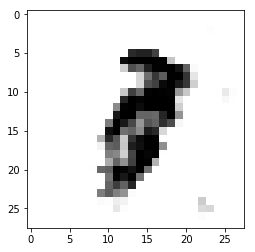

Estimate: [[-0.62144804]]
Iteration: 61200 at 2019-08-19 06:10:01.102174


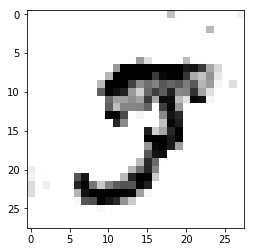

Estimate: [[10.775444]]
Iteration: 61300 at 2019-08-19 06:10:07.891390


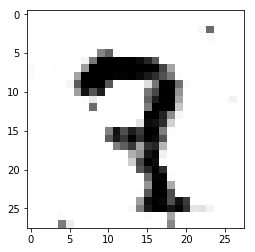

Estimate: [[7.834864]]
Iteration: 61400 at 2019-08-19 06:10:14.612236


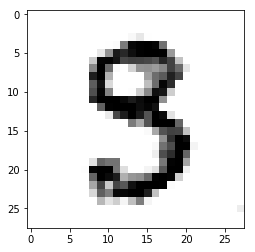

Estimate: [[-12.495184]]
Iteration: 61500 at 2019-08-19 06:10:21.360623


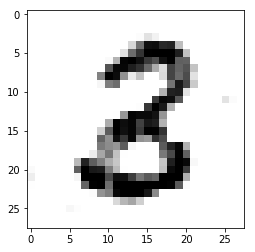

Estimate: [[13.432421]]
Iteration: 61600 at 2019-08-19 06:10:28.205173


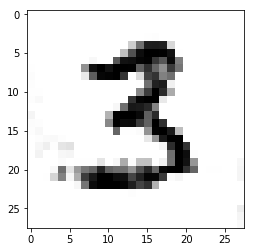

Estimate: [[-1.3597724]]
Iteration: 61700 at 2019-08-19 06:10:35.068713


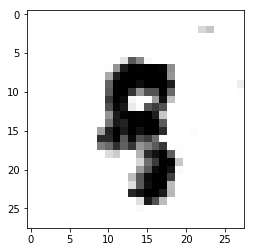

Estimate: [[-5.7411866]]
Iteration: 61800 at 2019-08-19 06:10:41.885064


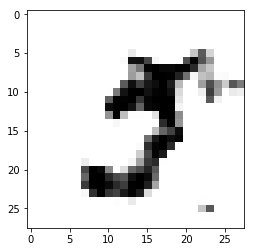

Estimate: [[-5.474513]]
Iteration: 61900 at 2019-08-19 06:10:48.639848


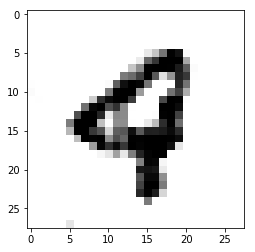

Estimate: [[17.420742]]
Iteration: 62000 at 2019-08-19 06:10:55.433060


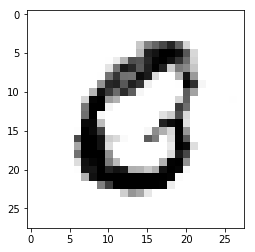

Estimate: [[11.156469]]
Iteration: 62100 at 2019-08-19 06:11:02.288779


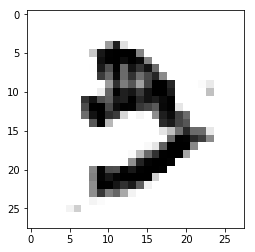

Estimate: [[-14.036715]]
Iteration: 62200 at 2019-08-19 06:11:09.066396


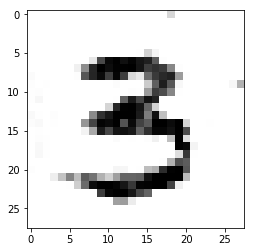

Estimate: [[3.934188]]
Iteration: 62300 at 2019-08-19 06:11:15.829723


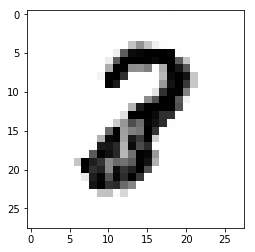

Estimate: [[-32.06256]]
Iteration: 62400 at 2019-08-19 06:11:22.712717


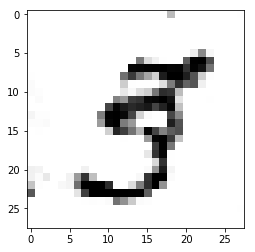

Estimate: [[-4.821183]]
Iteration: 62500 at 2019-08-19 06:11:29.509762


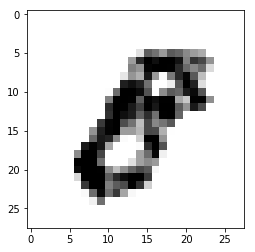

Estimate: [[19.582005]]
Iteration: 62600 at 2019-08-19 06:11:36.309396


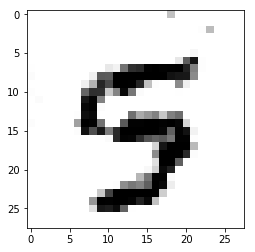

Estimate: [[3.7944925]]
Iteration: 62700 at 2019-08-19 06:11:43.165648


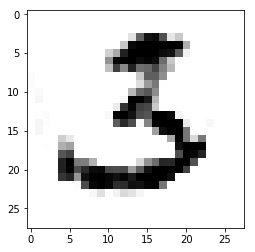

Estimate: [[-4.8059087]]
Iteration: 62800 at 2019-08-19 06:11:50.002841


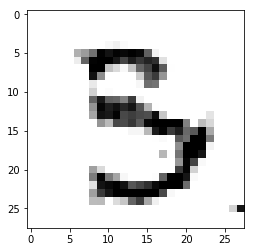

Estimate: [[-2.6712224]]
Iteration: 62900 at 2019-08-19 06:11:56.862713


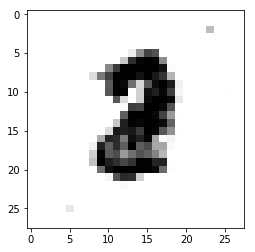

Estimate: [[-8.87294]]
Iteration: 63000 at 2019-08-19 06:12:03.737099


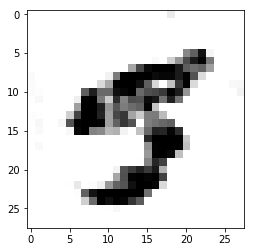

Estimate: [[5.797605]]
Iteration: 63100 at 2019-08-19 06:12:10.590709


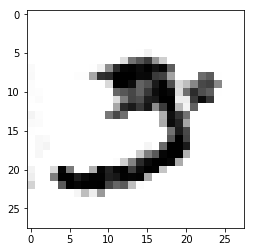

Estimate: [[9.156965]]
Iteration: 63200 at 2019-08-19 06:12:17.469271


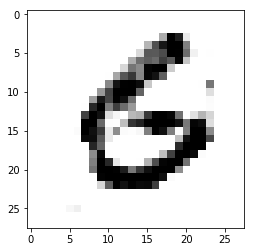

Estimate: [[28.69651]]
Iteration: 63300 at 2019-08-19 06:12:24.343499


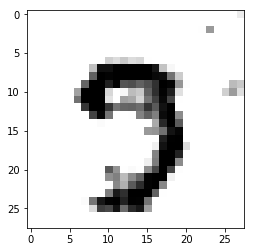

Estimate: [[-20.232433]]
Iteration: 63400 at 2019-08-19 06:12:31.240173


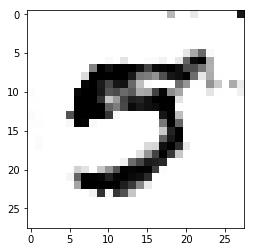

Estimate: [[5.189926]]
Iteration: 63500 at 2019-08-19 06:12:38.142940


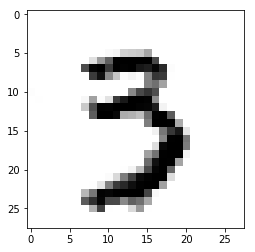

Estimate: [[4.175217]]
Iteration: 63600 at 2019-08-19 06:12:45.044641


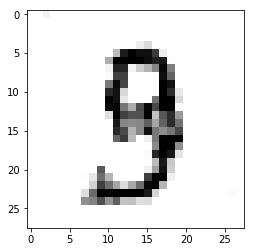

Estimate: [[-14.306909]]
Iteration: 63700 at 2019-08-19 06:12:51.944782


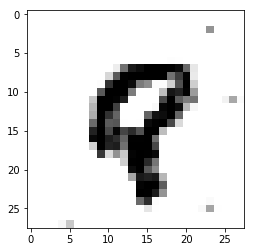

Estimate: [[27.63027]]
Iteration: 63800 at 2019-08-19 06:12:58.818743


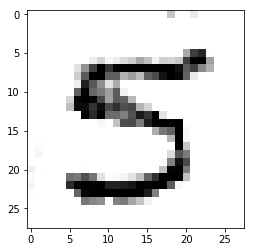

Estimate: [[5.756266]]
Iteration: 63900 at 2019-08-19 06:13:05.709056


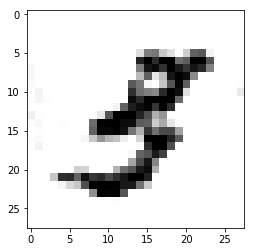

Estimate: [[7.702616]]
Iteration: 64000 at 2019-08-19 06:13:12.605052


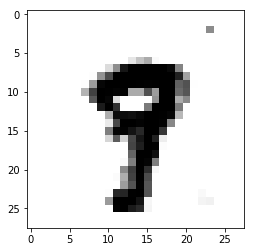

Estimate: [[-5.1578884]]
Iteration: 64100 at 2019-08-19 06:13:19.493557


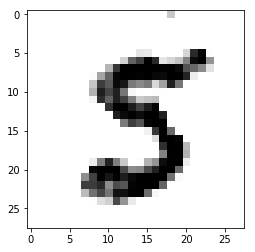

Estimate: [[8.812434]]
Iteration: 64200 at 2019-08-19 06:13:26.436228


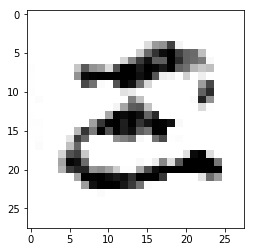

Estimate: [[-25.904228]]
Iteration: 64300 at 2019-08-19 06:13:33.350612


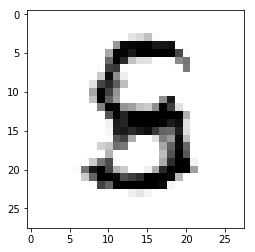

Estimate: [[-24.038792]]
Iteration: 64400 at 2019-08-19 06:13:40.323912


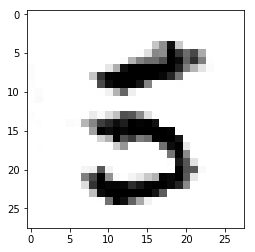

Estimate: [[-17.84984]]
Iteration: 64500 at 2019-08-19 06:13:47.299359


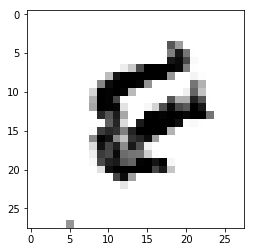

Estimate: [[21.702892]]
Iteration: 64600 at 2019-08-19 06:13:54.294725


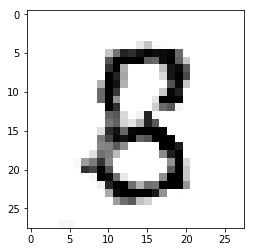

Estimate: [[11.291245]]
Iteration: 64700 at 2019-08-19 06:14:01.258434


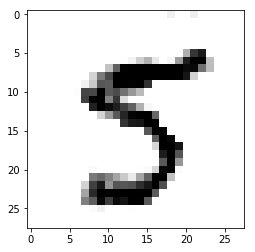

Estimate: [[-17.99042]]
Iteration: 64800 at 2019-08-19 06:14:08.236711


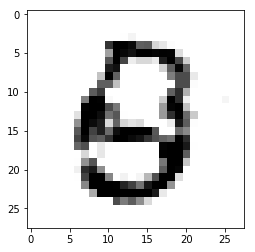

Estimate: [[0.34129262]]
Iteration: 64900 at 2019-08-19 06:14:15.191593


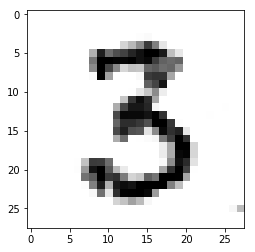

Estimate: [[-11.166785]]
Iteration: 65000 at 2019-08-19 06:14:22.177926


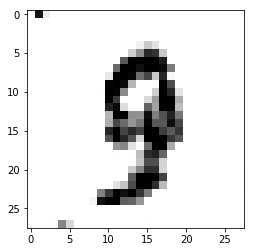

Estimate: [[-17.688292]]
Iteration: 65100 at 2019-08-19 06:14:29.188556


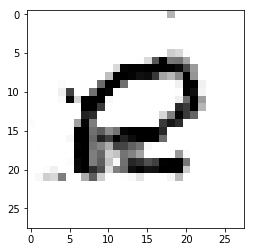

Estimate: [[15.515657]]
Iteration: 65200 at 2019-08-19 06:14:36.158504


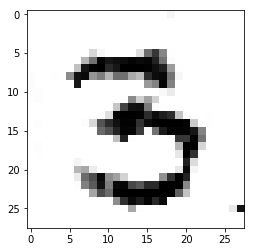

Estimate: [[-4.972671]]
Iteration: 65300 at 2019-08-19 06:14:43.153922


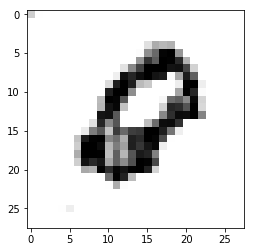

Estimate: [[10.947189]]
Iteration: 65400 at 2019-08-19 06:14:50.173059


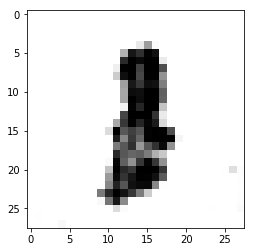

Estimate: [[-15.519815]]
Iteration: 65500 at 2019-08-19 06:14:57.265524


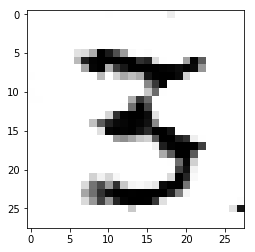

Estimate: [[-6.2690935]]
Iteration: 65600 at 2019-08-19 06:15:04.310856


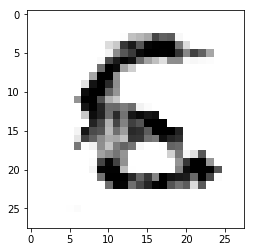

Estimate: [[13.136991]]
Iteration: 65700 at 2019-08-19 06:15:11.476283


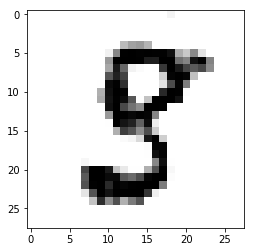

Estimate: [[13.5616]]
Iteration: 65800 at 2019-08-19 06:15:18.529089


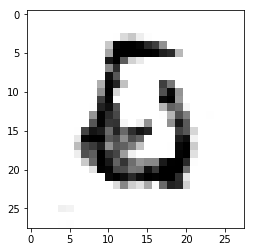

Estimate: [[-36.359386]]
Iteration: 65900 at 2019-08-19 06:15:25.614825


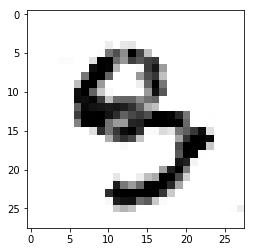

Estimate: [[-10.724883]]
Iteration: 66000 at 2019-08-19 06:15:32.678553


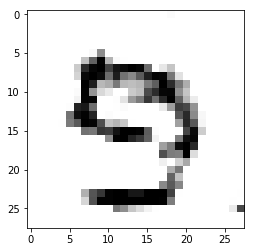

Estimate: [[11.141349]]
Iteration: 66100 at 2019-08-19 06:15:39.896221


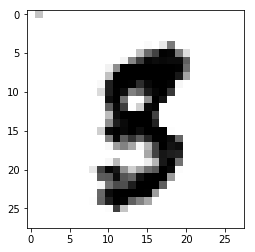

Estimate: [[-22.762966]]
Iteration: 66200 at 2019-08-19 06:15:47.096178


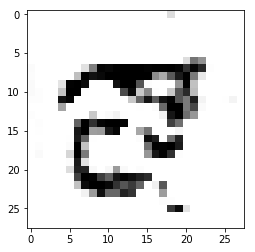

Estimate: [[-3.7701678]]
Iteration: 66300 at 2019-08-19 06:15:54.208834


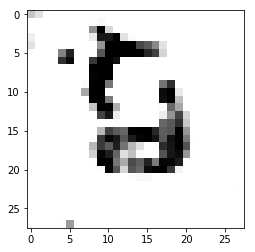

Estimate: [[17.169779]]
Iteration: 66400 at 2019-08-19 06:16:01.369491


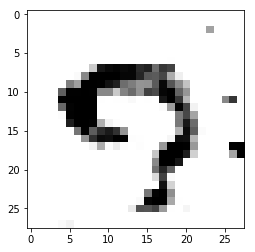

Estimate: [[-10.82615]]
Iteration: 66500 at 2019-08-19 06:16:08.496805


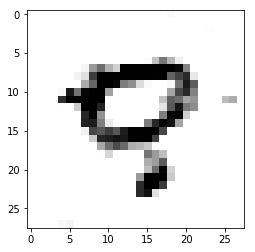

Estimate: [[-16.282429]]
Iteration: 66600 at 2019-08-19 06:16:15.678792


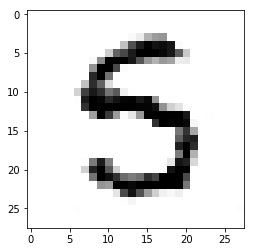

Estimate: [[16.57884]]
Iteration: 66700 at 2019-08-19 06:16:22.923534


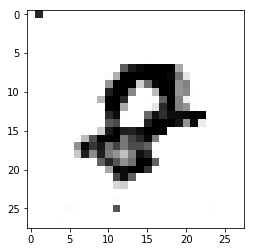

Estimate: [[-0.42346194]]
Iteration: 66800 at 2019-08-19 06:16:30.199746


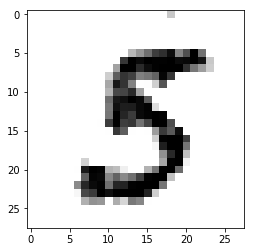

Estimate: [[-27.523619]]
Iteration: 66900 at 2019-08-19 06:16:37.383905


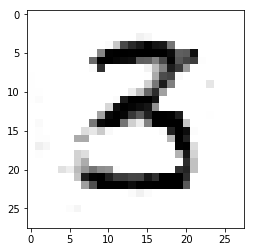

Estimate: [[-4.953491]]
Iteration: 67000 at 2019-08-19 06:16:44.570368


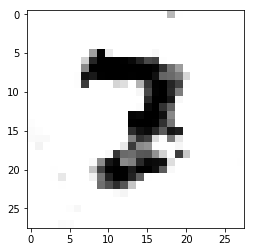

Estimate: [[-35.52428]]
Iteration: 67100 at 2019-08-19 06:16:51.767861


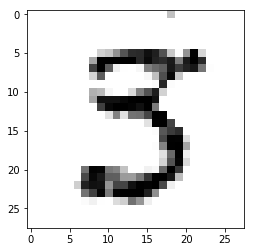

Estimate: [[-2.225448]]
Iteration: 67200 at 2019-08-19 06:16:59.005147


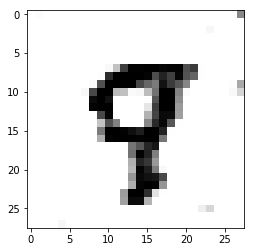

Estimate: [[2.7967072]]
Iteration: 67300 at 2019-08-19 06:17:06.242259


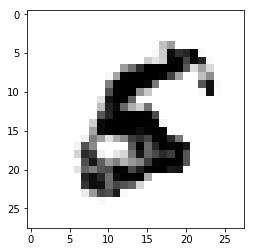

Estimate: [[11.67379]]
Iteration: 67400 at 2019-08-19 06:17:13.486542


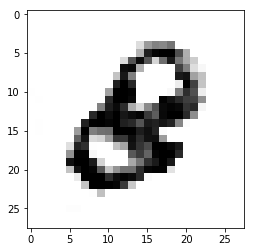

Estimate: [[-8.344224]]
Iteration: 67500 at 2019-08-19 06:17:20.710292


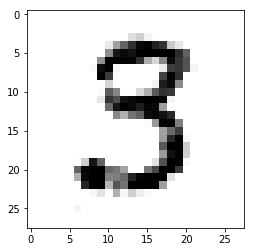

Estimate: [[7.3614516]]
Iteration: 67600 at 2019-08-19 06:17:27.971362


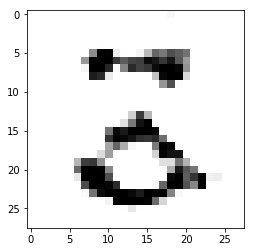

Estimate: [[22.355383]]
Iteration: 67700 at 2019-08-19 06:17:35.272145


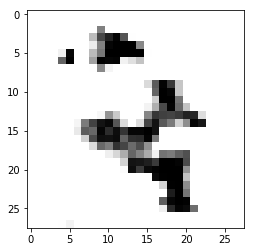

Estimate: [[3.414489]]
Iteration: 67800 at 2019-08-19 06:17:42.603897


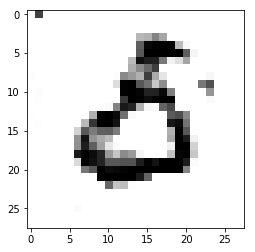

Estimate: [[-27.33309]]
Iteration: 67900 at 2019-08-19 06:17:49.943928


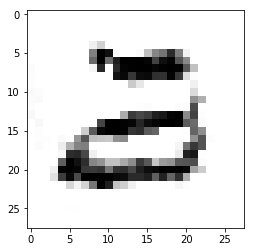

Estimate: [[-32.934433]]
Iteration: 68000 at 2019-08-19 06:17:57.243681


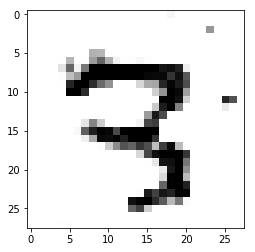

Estimate: [[11.751297]]
Iteration: 68100 at 2019-08-19 06:18:04.524996


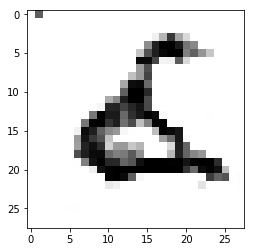

Estimate: [[20.319515]]
Iteration: 68200 at 2019-08-19 06:18:11.805763


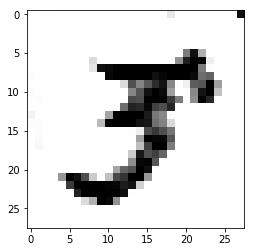

Estimate: [[-4.663825]]
Iteration: 68300 at 2019-08-19 06:18:19.064981


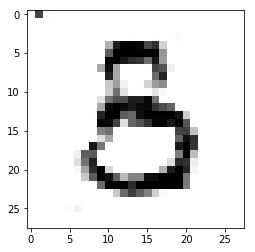

Estimate: [[-4.398452]]
Iteration: 68400 at 2019-08-19 06:18:26.384342


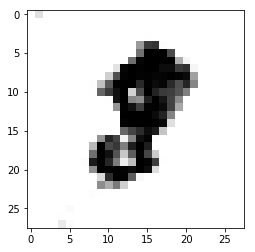

Estimate: [[-10.537734]]
Iteration: 68500 at 2019-08-19 06:18:33.714529


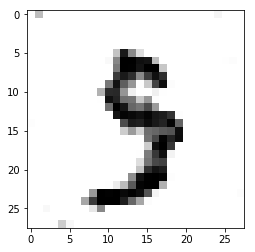

Estimate: [[16.762419]]
Iteration: 68600 at 2019-08-19 06:18:41.022124


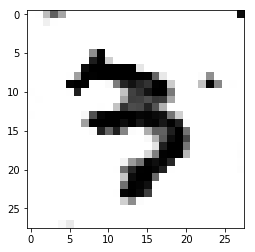

Estimate: [[-28.69527]]
Iteration: 68700 at 2019-08-19 06:18:48.319991


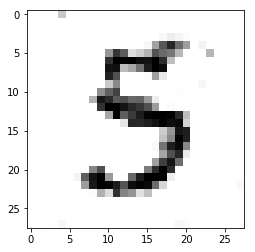

Estimate: [[-5.7594705]]
Iteration: 68800 at 2019-08-19 06:18:55.691159


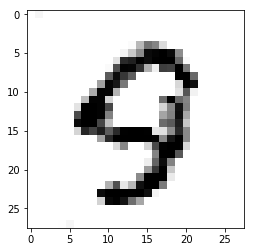

Estimate: [[-4.1210313]]
Iteration: 68900 at 2019-08-19 06:19:03.120925


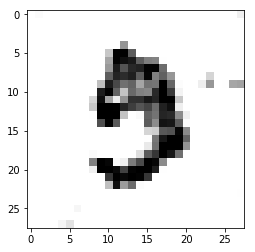

Estimate: [[-5.1706166]]
Iteration: 69000 at 2019-08-19 06:19:10.521613


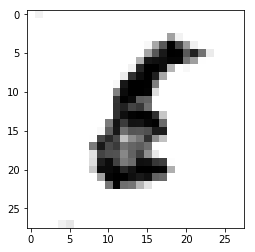

Estimate: [[44.306473]]
Iteration: 69100 at 2019-08-19 06:19:17.903712


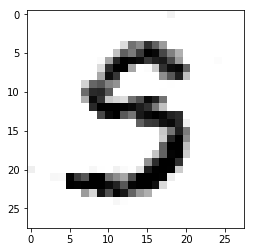

Estimate: [[-20.38584]]
Iteration: 69200 at 2019-08-19 06:19:25.287767


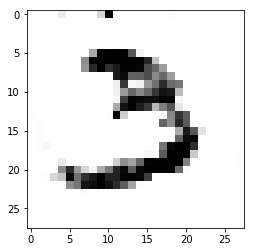

Estimate: [[-3.021057]]
Iteration: 69300 at 2019-08-19 06:19:32.646382


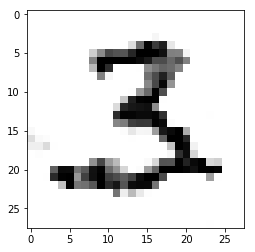

Estimate: [[12.867939]]
Iteration: 69400 at 2019-08-19 06:19:40.005449


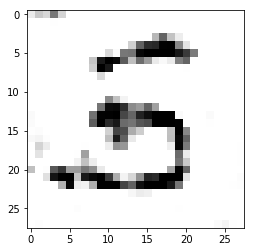

Estimate: [[-13.402011]]
Iteration: 69500 at 2019-08-19 06:19:47.348423


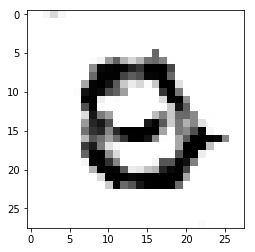

Estimate: [[-2.6541033]]
Iteration: 69600 at 2019-08-19 06:19:54.756867


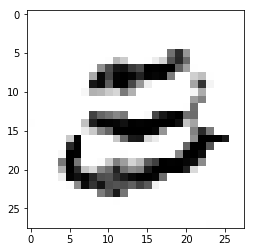

Estimate: [[-5.420757]]
Iteration: 69700 at 2019-08-19 06:20:02.198469


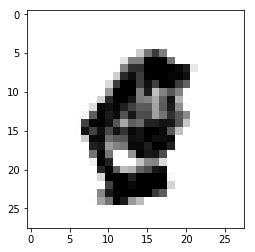

Estimate: [[-21.1017]]
Iteration: 69800 at 2019-08-19 06:20:09.651186


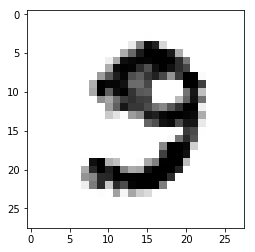

Estimate: [[-4.5007806]]
Iteration: 69900 at 2019-08-19 06:20:17.107175


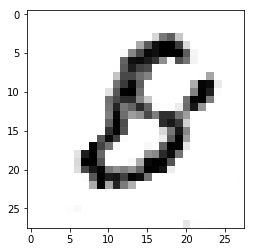

Estimate: [[30.050858]]
Iteration: 70000 at 2019-08-19 06:20:25.470343


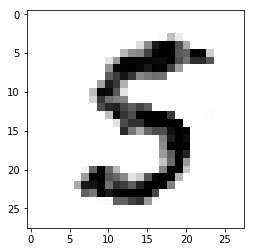

Estimate: [[24.294933]]
Iteration: 70100 at 2019-08-19 06:20:32.998846


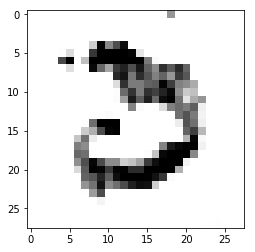

Estimate: [[12.309074]]
Iteration: 70200 at 2019-08-19 06:20:40.476432


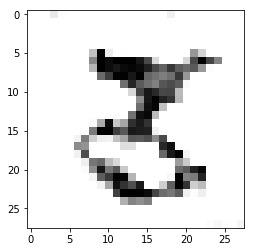

Estimate: [[-10.116964]]
Iteration: 70300 at 2019-08-19 06:20:47.993555


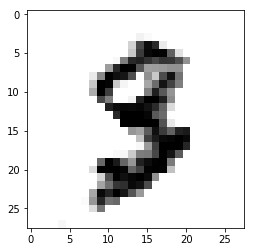

Estimate: [[12.811345]]
Iteration: 70400 at 2019-08-19 06:20:55.619028


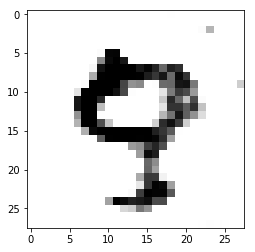

Estimate: [[-4.000373]]
Iteration: 70500 at 2019-08-19 06:21:03.139946


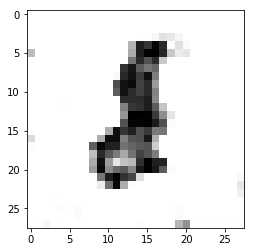

Estimate: [[26.028114]]
Iteration: 70600 at 2019-08-19 06:21:10.693767


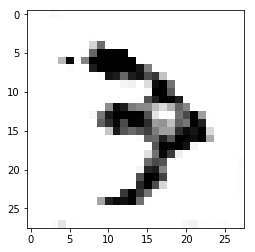

Estimate: [[32.410873]]
Iteration: 70700 at 2019-08-19 06:21:18.278324


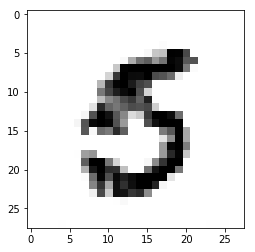

Estimate: [[-4.7711167]]
Iteration: 70800 at 2019-08-19 06:21:25.831103


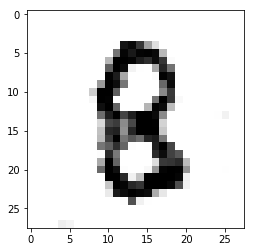

Estimate: [[3.5563097]]
Iteration: 70900 at 2019-08-19 06:21:33.334346


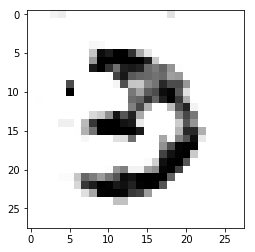

Estimate: [[-39.363907]]
Iteration: 71000 at 2019-08-19 06:21:40.979276


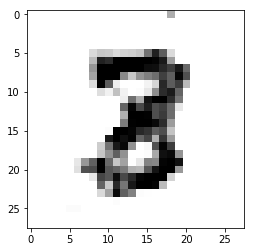

Estimate: [[-14.1160965]]
Iteration: 71100 at 2019-08-19 06:21:48.615768


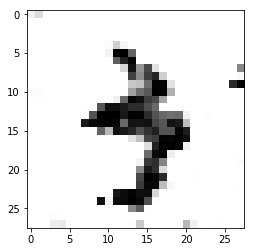

Estimate: [[-34.98336]]
Iteration: 71200 at 2019-08-19 06:21:56.227014


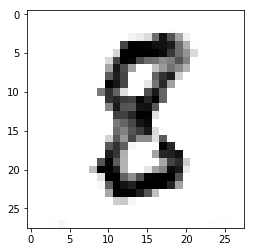

Estimate: [[5.1247582]]
Iteration: 71300 at 2019-08-19 06:22:03.786750


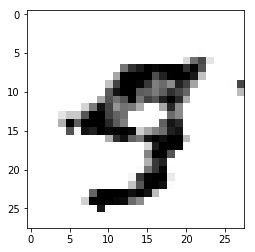

Estimate: [[15.508727]]
Iteration: 71400 at 2019-08-19 06:22:11.399335


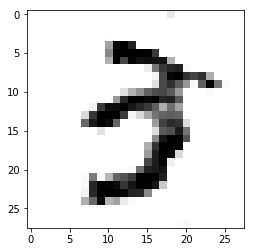

Estimate: [[-1.3366292]]
Iteration: 71500 at 2019-08-19 06:22:19.029282


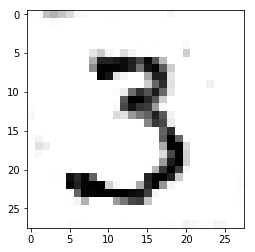

Estimate: [[8.299682]]
Iteration: 71600 at 2019-08-19 06:22:26.661941


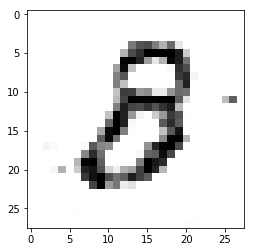

Estimate: [[21.689638]]
Iteration: 71700 at 2019-08-19 06:22:34.301820


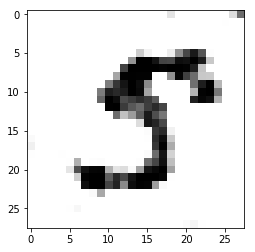

Estimate: [[9.292831]]
Iteration: 71800 at 2019-08-19 06:22:41.963997


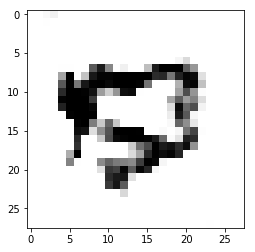

Estimate: [[-2.4742026]]
Iteration: 71900 at 2019-08-19 06:22:49.607766


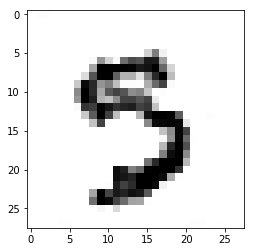

Estimate: [[8.867496]]
Iteration: 72000 at 2019-08-19 06:22:57.219105


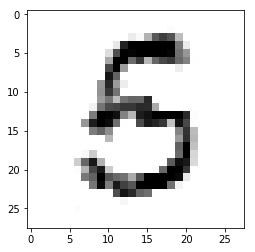

Estimate: [[7.6530743]]
Iteration: 72100 at 2019-08-19 06:23:04.865322


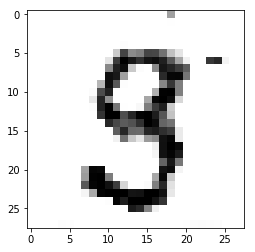

Estimate: [[0.80981904]]
Iteration: 72200 at 2019-08-19 06:23:12.474888


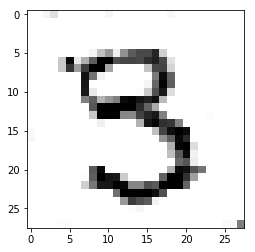

Estimate: [[21.377123]]
Iteration: 72300 at 2019-08-19 06:23:20.135599


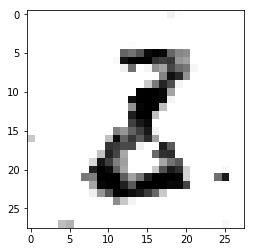

Estimate: [[6.9458985]]
Iteration: 72400 at 2019-08-19 06:23:27.754846


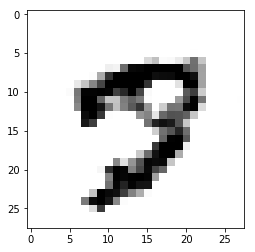

Estimate: [[14.558456]]
Iteration: 72500 at 2019-08-19 06:23:35.375774


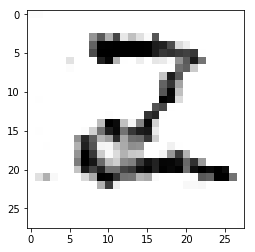

Estimate: [[17.915514]]
Iteration: 72600 at 2019-08-19 06:23:43.038752


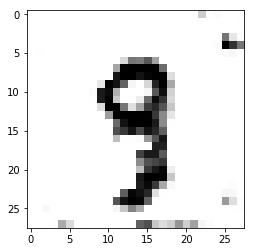

Estimate: [[-73.5369]]
Iteration: 72700 at 2019-08-19 06:23:50.680529


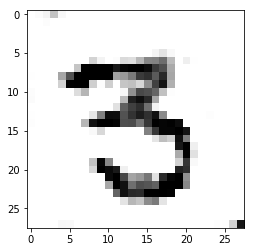

Estimate: [[7.554141]]
Iteration: 72800 at 2019-08-19 06:23:58.349266


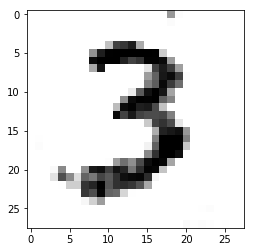

Estimate: [[-1.9493358]]
Iteration: 72900 at 2019-08-19 06:24:06.021008


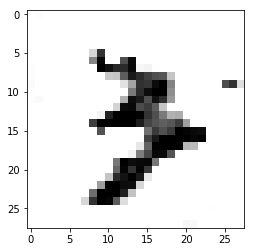

Estimate: [[-10.0743]]
Iteration: 73000 at 2019-08-19 06:24:13.696483


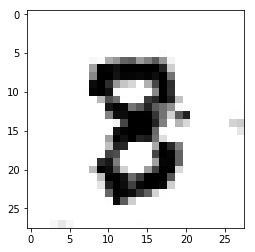

Estimate: [[-52.104374]]
Iteration: 73100 at 2019-08-19 06:24:21.412921


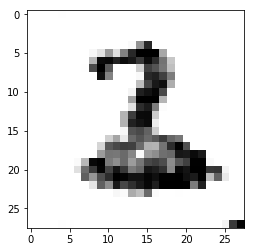

Estimate: [[-9.925414]]
Iteration: 73200 at 2019-08-19 06:24:29.159513


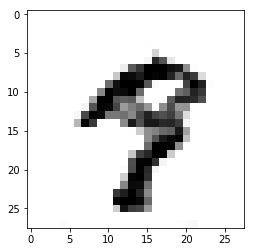

Estimate: [[22.11163]]
Iteration: 73300 at 2019-08-19 06:24:36.868881


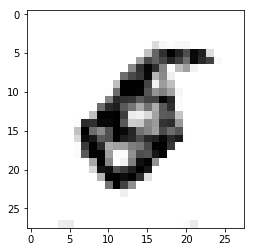

Estimate: [[-4.188489]]
Iteration: 73400 at 2019-08-19 06:24:44.628153


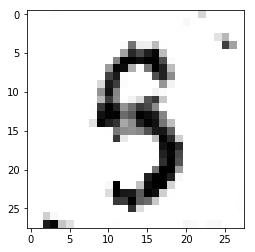

Estimate: [[0.3912649]]
Iteration: 73500 at 2019-08-19 06:24:52.336989


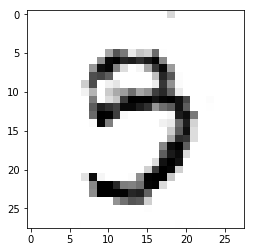

Estimate: [[7.0791163]]
Iteration: 73600 at 2019-08-19 06:25:00.023436


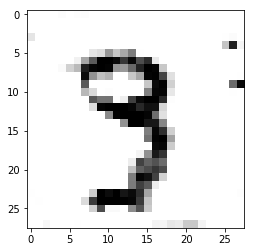

Estimate: [[12.663289]]
Iteration: 73700 at 2019-08-19 06:25:07.740012


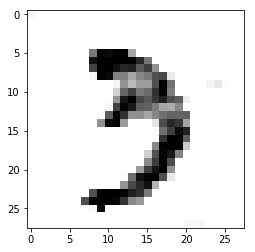

Estimate: [[11.207789]]
Iteration: 73800 at 2019-08-19 06:25:15.472594


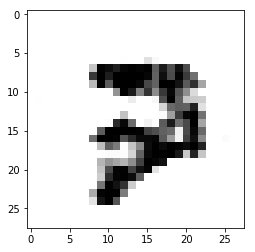

Estimate: [[-11.588039]]
Iteration: 73900 at 2019-08-19 06:25:23.187808


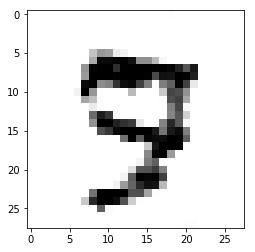

Estimate: [[22.733295]]
Iteration: 74000 at 2019-08-19 06:25:30.922630


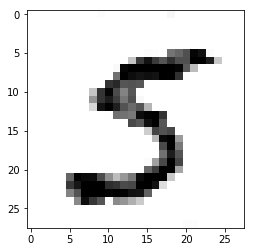

Estimate: [[-4.2876773]]
Iteration: 74100 at 2019-08-19 06:25:38.699971


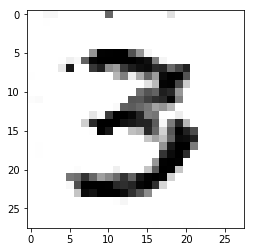

Estimate: [[-0.6128692]]
Iteration: 74200 at 2019-08-19 06:25:46.556783


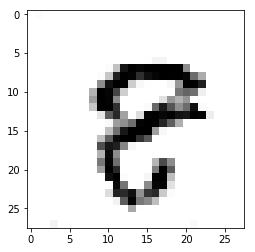

Estimate: [[8.66894]]
Iteration: 74300 at 2019-08-19 06:25:54.396778


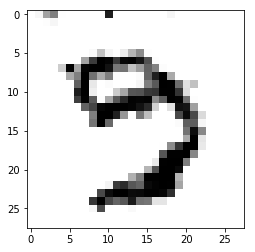

Estimate: [[11.535183]]
Iteration: 74400 at 2019-08-19 06:26:02.304165


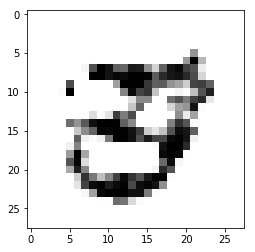

Estimate: [[-15.246849]]
Iteration: 74500 at 2019-08-19 06:26:10.252723


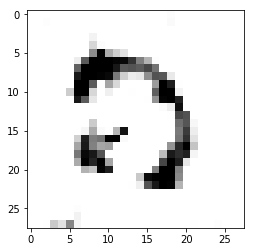

Estimate: [[21.03403]]
Iteration: 74600 at 2019-08-19 06:26:18.056600


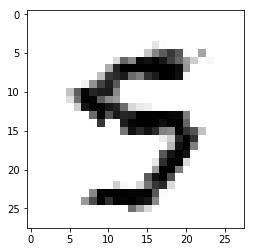

Estimate: [[9.116984]]
Iteration: 74700 at 2019-08-19 06:26:25.874564


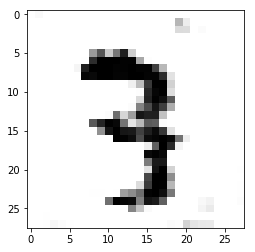

Estimate: [[-27.322021]]
Iteration: 74800 at 2019-08-19 06:26:33.683208


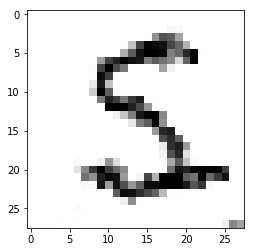

Estimate: [[17.256592]]
Iteration: 74900 at 2019-08-19 06:26:41.489880


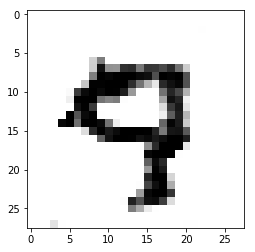

Estimate: [[57.793026]]
Iteration: 75000 at 2019-08-19 06:26:49.333641


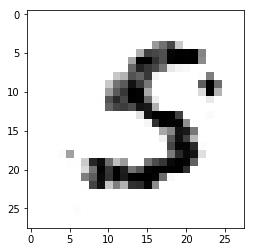

Estimate: [[12.223737]]
Iteration: 75100 at 2019-08-19 06:26:57.173830


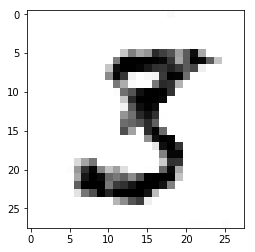

Estimate: [[14.009133]]
Iteration: 75200 at 2019-08-19 06:27:05.000980


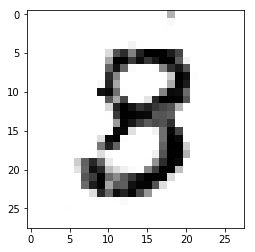

Estimate: [[0.8838028]]
Iteration: 75300 at 2019-08-19 06:27:12.804597


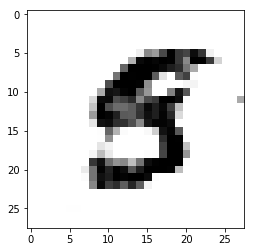

Estimate: [[-0.41259795]]
Iteration: 75400 at 2019-08-19 06:27:20.622846


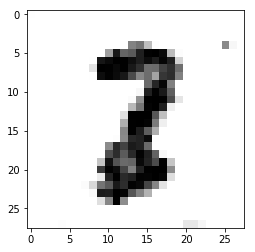

Estimate: [[33.960083]]
Iteration: 75500 at 2019-08-19 06:27:28.462191


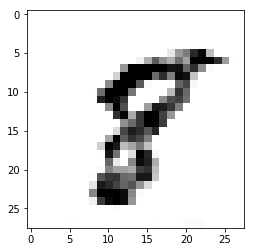

Estimate: [[12.532964]]
Iteration: 75600 at 2019-08-19 06:27:36.348183


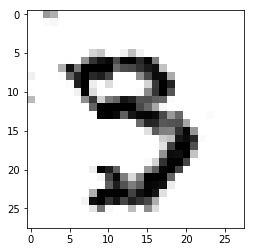

Estimate: [[-11.658055]]
Iteration: 75700 at 2019-08-19 06:27:44.188289


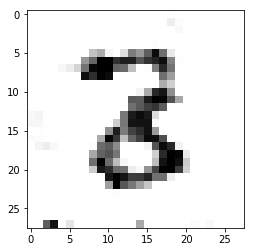

Estimate: [[-7.9490657]]
Iteration: 75800 at 2019-08-19 06:27:52.016800


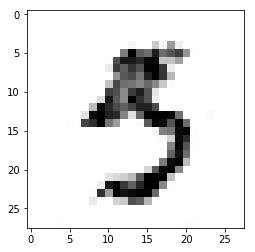

Estimate: [[-15.900919]]
Iteration: 75900 at 2019-08-19 06:27:59.876935


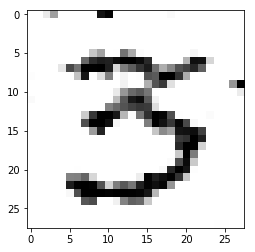

Estimate: [[2.266724]]
Iteration: 76000 at 2019-08-19 06:28:07.732828


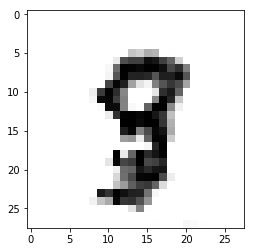

Estimate: [[9.412567]]
Iteration: 76100 at 2019-08-19 06:28:15.596861


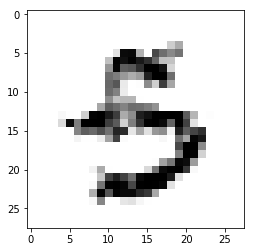

Estimate: [[14.682237]]
Iteration: 76200 at 2019-08-19 06:28:23.503394


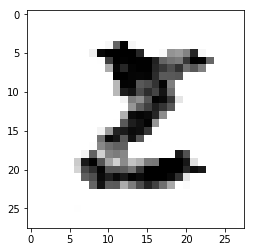

Estimate: [[-10.895783]]
Iteration: 76300 at 2019-08-19 06:28:31.424857


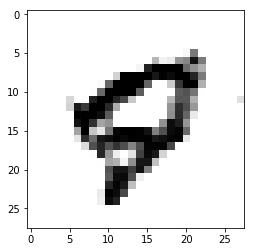

Estimate: [[20.438091]]
Iteration: 76400 at 2019-08-19 06:28:39.300531


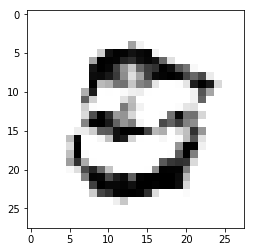

Estimate: [[-12.076506]]
Iteration: 76500 at 2019-08-19 06:28:47.161996


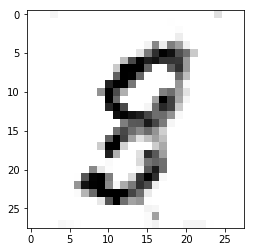

Estimate: [[25.732662]]
Iteration: 76600 at 2019-08-19 06:28:55.079297


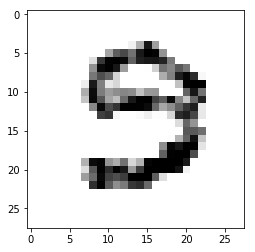

Estimate: [[-9.680365]]
Iteration: 76700 at 2019-08-19 06:29:03.052187


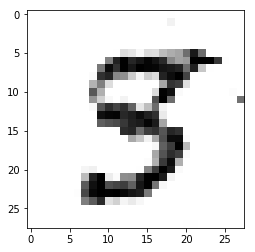

Estimate: [[0.7822498]]
Iteration: 76800 at 2019-08-19 06:29:10.994595


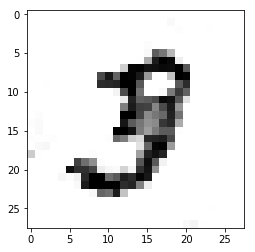

Estimate: [[-23.961222]]
Iteration: 76900 at 2019-08-19 06:29:18.903964


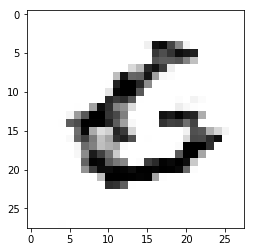

Estimate: [[-10.579544]]
Iteration: 77000 at 2019-08-19 06:29:26.818115


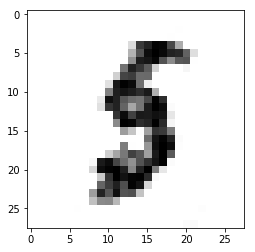

Estimate: [[13.937029]]
Iteration: 77100 at 2019-08-19 06:29:34.786815


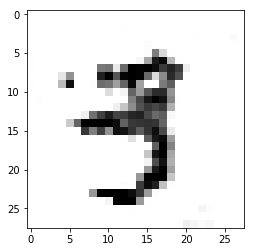

Estimate: [[-28.096575]]
Iteration: 77200 at 2019-08-19 06:29:42.819198


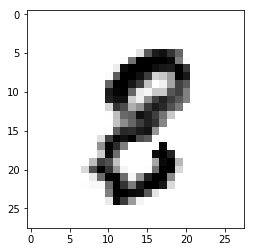

Estimate: [[3.4621944]]
Iteration: 77300 at 2019-08-19 06:29:50.788036


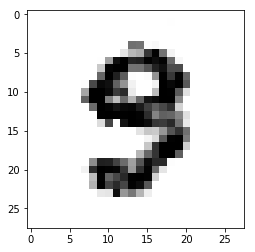

Estimate: [[-9.182081]]
Iteration: 77400 at 2019-08-19 06:29:58.772695


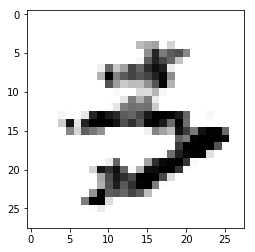

Estimate: [[34.965893]]
Iteration: 77500 at 2019-08-19 06:30:06.708354


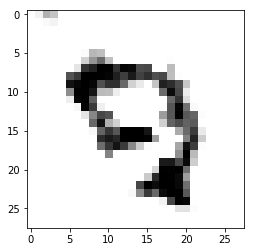

Estimate: [[1.4256048]]
Iteration: 77600 at 2019-08-19 06:30:14.729539


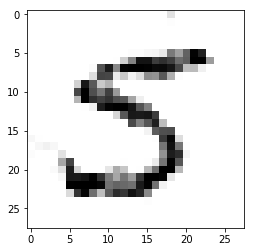

Estimate: [[3.3350477]]
Iteration: 77700 at 2019-08-19 06:30:22.738412


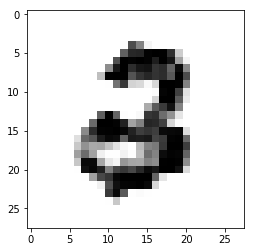

Estimate: [[-3.604464]]
Iteration: 77800 at 2019-08-19 06:30:30.765600


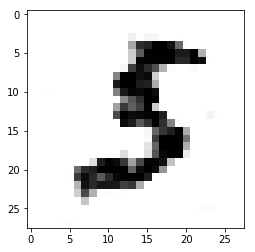

Estimate: [[-27.651834]]
Iteration: 77900 at 2019-08-19 06:30:38.734172


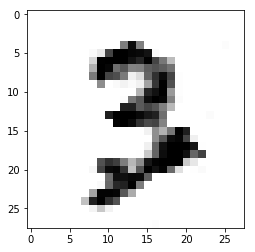

Estimate: [[-10.2969885]]
Iteration: 78000 at 2019-08-19 06:30:46.732301


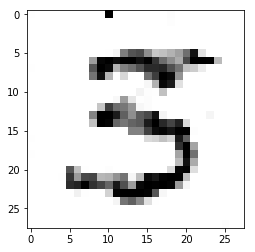

Estimate: [[11.226706]]
Iteration: 78100 at 2019-08-19 06:30:54.810250


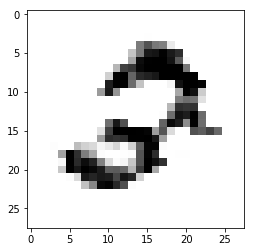

Estimate: [[-1.5331876]]
Iteration: 78200 at 2019-08-19 06:31:02.879158


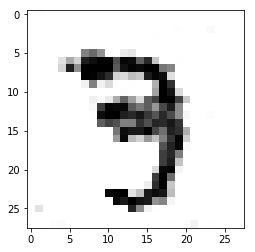

Estimate: [[-4.9756184]]
Iteration: 78300 at 2019-08-19 06:31:10.977987


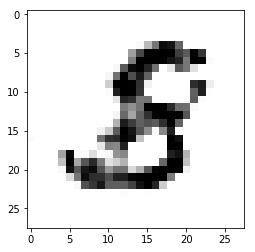

Estimate: [[-5.2894087]]
Iteration: 78400 at 2019-08-19 06:31:19.143706


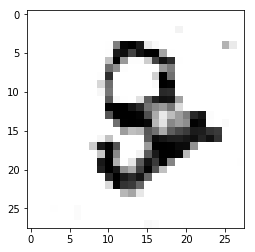

Estimate: [[24.338282]]
Iteration: 78500 at 2019-08-19 06:31:27.208463


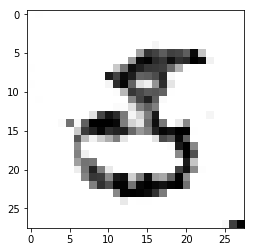

Estimate: [[3.5436513]]
Iteration: 78600 at 2019-08-19 06:31:35.247093


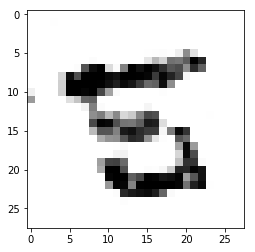

Estimate: [[-21.13735]]
Iteration: 78700 at 2019-08-19 06:31:43.336022


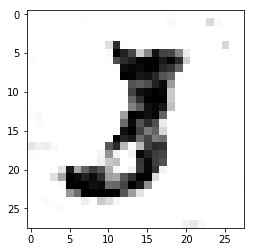

Estimate: [[5.4606013]]
Iteration: 78800 at 2019-08-19 06:31:51.397540


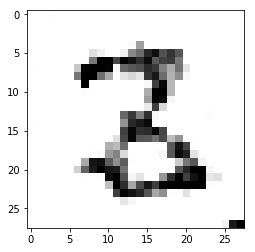

Estimate: [[6.401385]]
Iteration: 78900 at 2019-08-19 06:31:59.526924


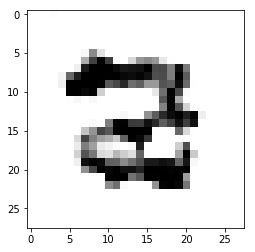

Estimate: [[-3.8360581]]
Iteration: 79000 at 2019-08-19 06:32:07.578565


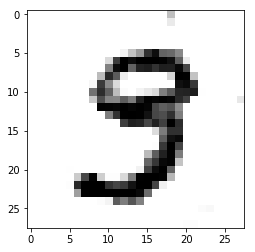

Estimate: [[7.7940974]]
Iteration: 79100 at 2019-08-19 06:32:15.705547


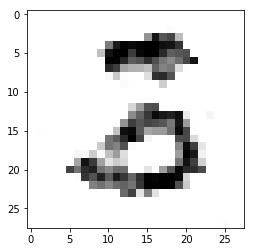

Estimate: [[4.887327]]
Iteration: 79200 at 2019-08-19 06:32:23.839172


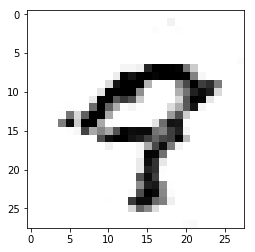

Estimate: [[-6.0527034]]
Iteration: 79300 at 2019-08-19 06:32:31.973157


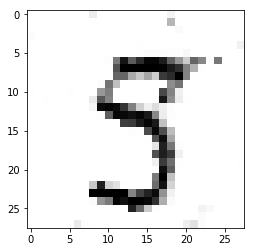

Estimate: [[-26.259352]]
Iteration: 79400 at 2019-08-19 06:32:40.094428


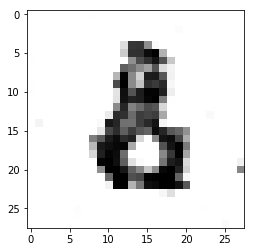

Estimate: [[-9.78812]]
Iteration: 79500 at 2019-08-19 06:32:48.195222


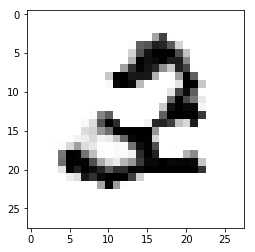

Estimate: [[36.829163]]
Iteration: 79600 at 2019-08-19 06:32:56.312735


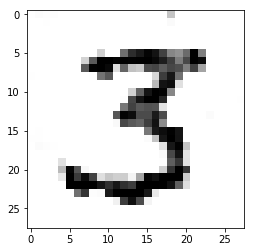

Estimate: [[3.4906223]]
Iteration: 79700 at 2019-08-19 06:33:04.416127


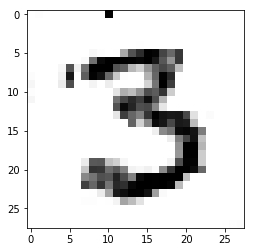

Estimate: [[-25.78792]]
Iteration: 79800 at 2019-08-19 06:33:12.549203


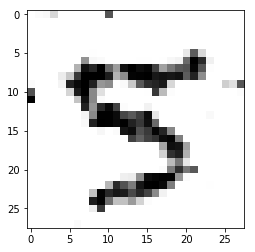

Estimate: [[-5.5739365]]
Iteration: 79900 at 2019-08-19 06:33:20.677418


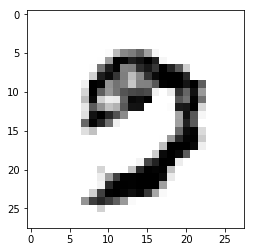

Estimate: [[14.818612]]
Iteration: 80000 at 2019-08-19 06:33:28.910381


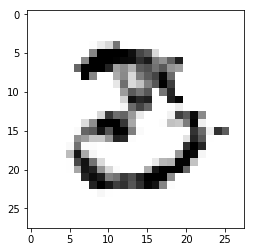

Estimate: [[-6.3968034]]
Iteration: 80100 at 2019-08-19 06:33:37.102286


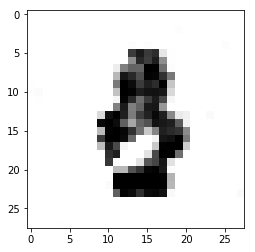

Estimate: [[-0.42897633]]
Iteration: 80200 at 2019-08-19 06:33:45.363625


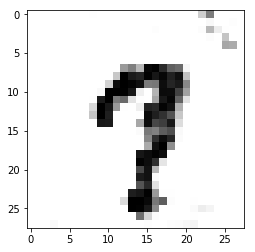

Estimate: [[-13.675135]]
Iteration: 80300 at 2019-08-19 06:33:53.562135


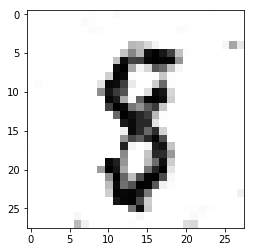

Estimate: [[-8.431082]]
Iteration: 80400 at 2019-08-19 06:34:01.803407


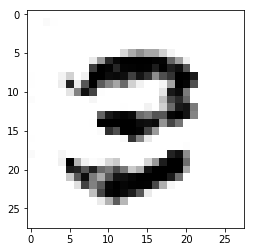

Estimate: [[14.987939]]
Iteration: 80500 at 2019-08-19 06:34:09.999017


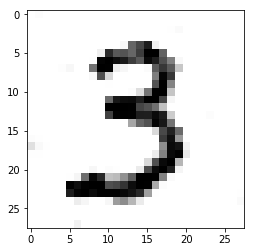

Estimate: [[-2.1526067]]
Iteration: 80600 at 2019-08-19 06:34:18.223964


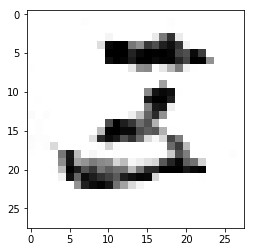

Estimate: [[-17.229399]]
Iteration: 80700 at 2019-08-19 06:34:26.457640


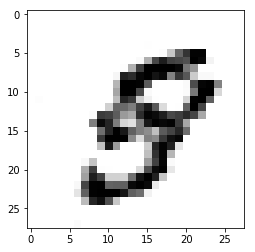

Estimate: [[9.718985]]
Iteration: 80800 at 2019-08-19 06:34:34.705443


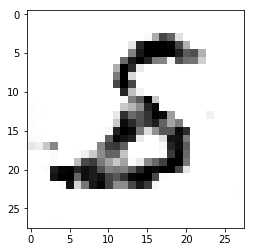

Estimate: [[-18.071892]]
Iteration: 80900 at 2019-08-19 06:34:42.969741


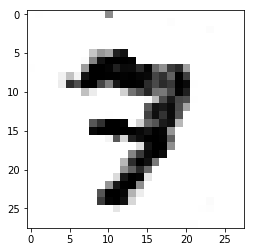

Estimate: [[-0.7019679]]
Iteration: 81000 at 2019-08-19 06:34:51.221907


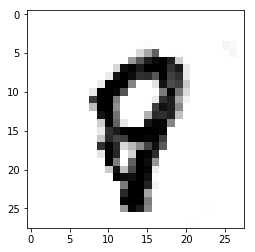

Estimate: [[16.563198]]
Iteration: 81100 at 2019-08-19 06:34:59.576947


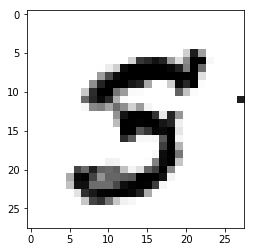

Estimate: [[-5.417899]]
Iteration: 81200 at 2019-08-19 06:35:07.856198


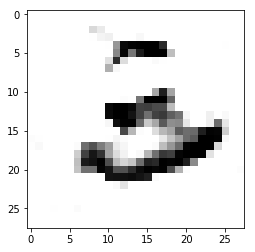

Estimate: [[20.145863]]
Iteration: 81300 at 2019-08-19 06:35:16.061380


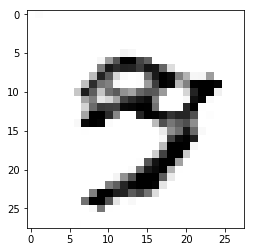

Estimate: [[-2.6877007]]
Iteration: 81400 at 2019-08-19 06:35:24.331835


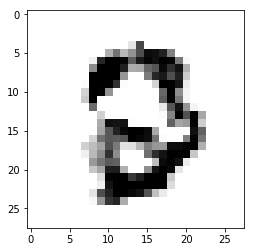

Estimate: [[-13.17937]]
Iteration: 81500 at 2019-08-19 06:35:32.630105


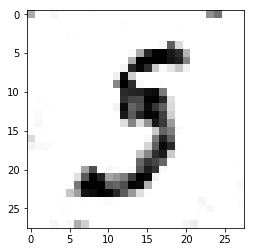

Estimate: [[-18.803207]]
Iteration: 81600 at 2019-08-19 06:35:40.946388


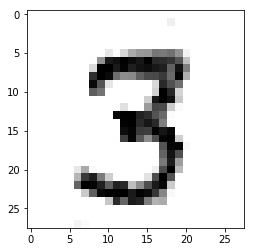

Estimate: [[8.44958]]
Iteration: 81700 at 2019-08-19 06:35:49.245370


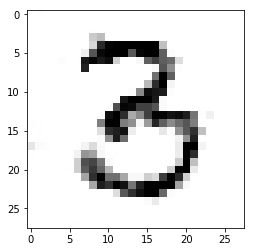

Estimate: [[9.459452]]
Iteration: 81800 at 2019-08-19 06:35:57.569225


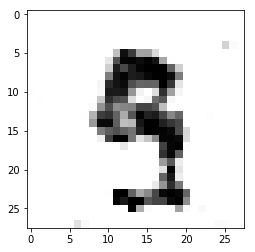

Estimate: [[5.179214]]
Iteration: 81900 at 2019-08-19 06:36:05.945499


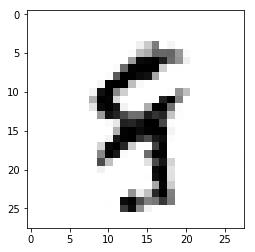

Estimate: [[17.80104]]
Iteration: 82000 at 2019-08-19 06:36:14.259345


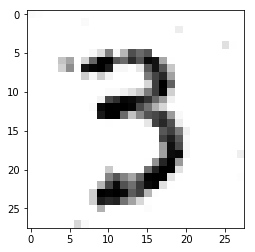

Estimate: [[-6.845027]]
Iteration: 82100 at 2019-08-19 06:36:22.696779


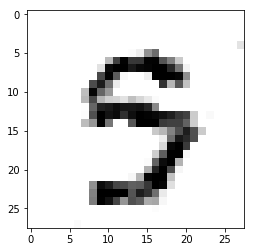

Estimate: [[13.85825]]
Iteration: 82200 at 2019-08-19 06:36:31.228305


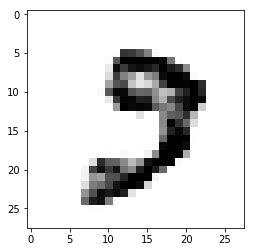

Estimate: [[19.941458]]
Iteration: 82300 at 2019-08-19 06:36:39.518939


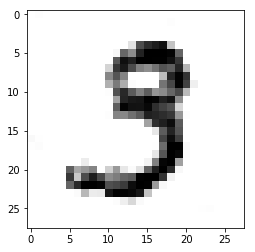

Estimate: [[2.7493272]]
Iteration: 82400 at 2019-08-19 06:36:47.849134


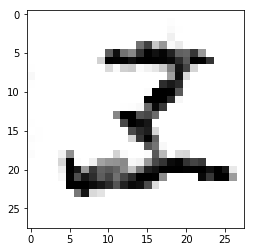

Estimate: [[-6.820304]]
Iteration: 82500 at 2019-08-19 06:36:56.167389


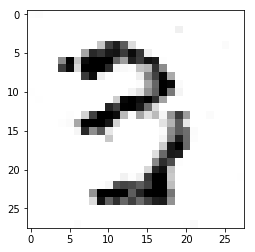

Estimate: [[-4.4670973]]
Iteration: 82600 at 2019-08-19 06:37:05.478676


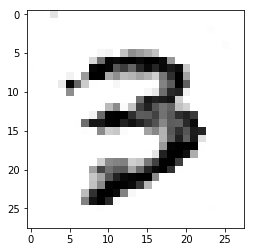

Estimate: [[-38.151722]]
Iteration: 82700 at 2019-08-19 06:37:13.832544


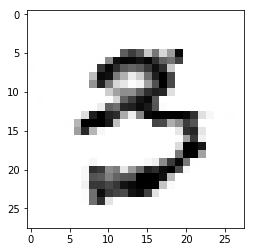

Estimate: [[-4.7823806]]
Iteration: 82800 at 2019-08-19 06:37:22.221748


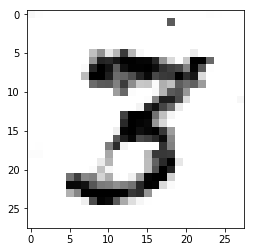

Estimate: [[-13.945683]]
Iteration: 82900 at 2019-08-19 06:37:30.600552


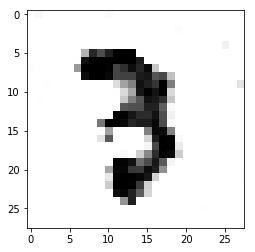

Estimate: [[-13.224288]]
Iteration: 83000 at 2019-08-19 06:37:38.971032


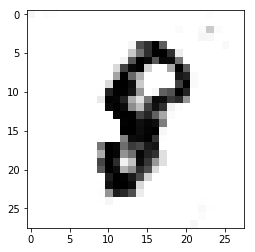

Estimate: [[17.092447]]
Iteration: 83100 at 2019-08-19 06:37:47.477415


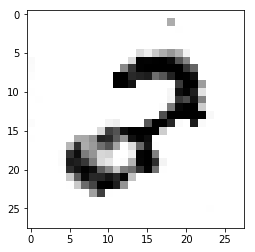

Estimate: [[0.9168829]]
Iteration: 83200 at 2019-08-19 06:37:55.936256


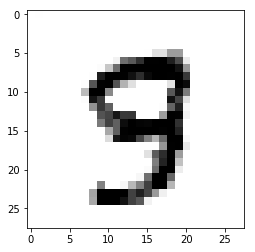

Estimate: [[13.339405]]
Iteration: 83300 at 2019-08-19 06:38:04.450095


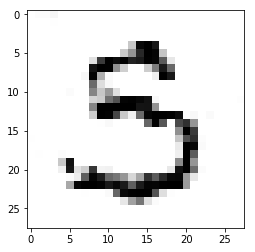

Estimate: [[-23.718903]]
Iteration: 83400 at 2019-08-19 06:38:12.890502


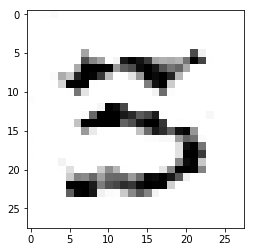

Estimate: [[14.662942]]
Iteration: 83500 at 2019-08-19 06:38:21.332737


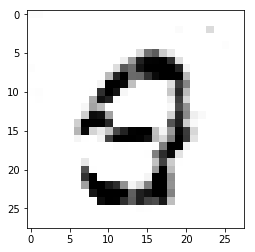

Estimate: [[30.30502]]
Iteration: 83600 at 2019-08-19 06:38:29.771811


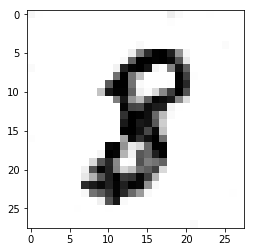

Estimate: [[6.8261333]]
Iteration: 83700 at 2019-08-19 06:38:38.221464


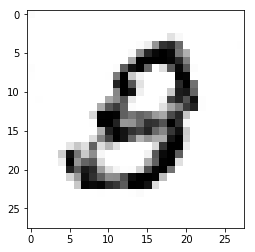

Estimate: [[-6.315838]]
Iteration: 83800 at 2019-08-19 06:38:46.695646


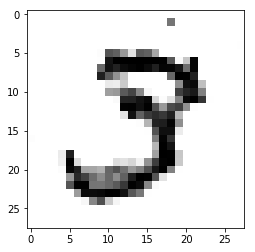

Estimate: [[9.768839]]
Iteration: 83900 at 2019-08-19 06:38:55.176247


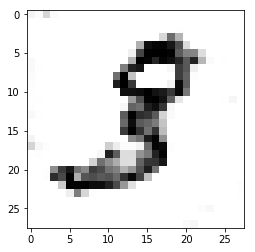

Estimate: [[6.2728996]]
Iteration: 84000 at 2019-08-19 06:39:03.674034


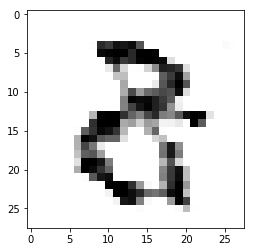

Estimate: [[-26.012772]]
Iteration: 84100 at 2019-08-19 06:39:12.181412


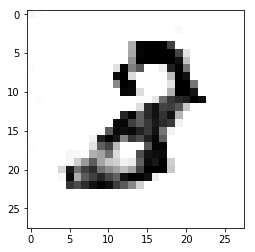

Estimate: [[-4.8810167]]
Iteration: 84200 at 2019-08-19 06:39:20.605207


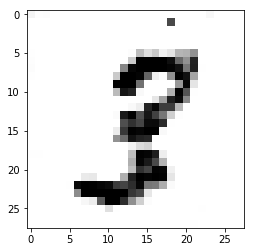

Estimate: [[-1.4224408]]
Iteration: 84300 at 2019-08-19 06:39:29.077537


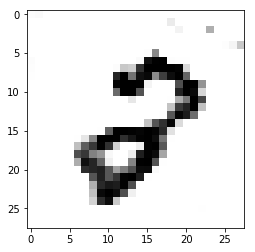

Estimate: [[-16.621521]]
Iteration: 84400 at 2019-08-19 06:39:37.622148


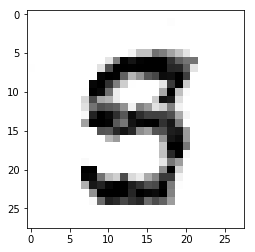

Estimate: [[14.74613]]
Iteration: 84500 at 2019-08-19 06:39:46.116346


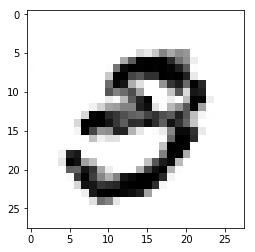

Estimate: [[-11.938188]]
Iteration: 84600 at 2019-08-19 06:39:54.605427


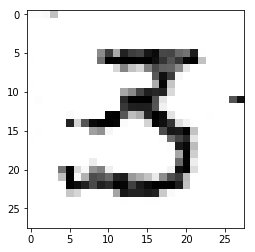

Estimate: [[7.5632124]]
Iteration: 84700 at 2019-08-19 06:40:03.109903


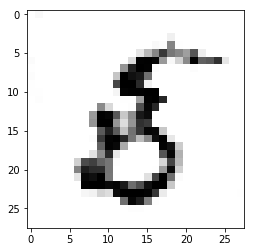

Estimate: [[16.42592]]
Iteration: 84800 at 2019-08-19 06:40:11.683714


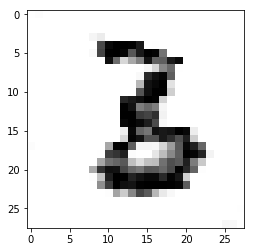

Estimate: [[19.820654]]
Iteration: 84900 at 2019-08-19 06:40:20.199440


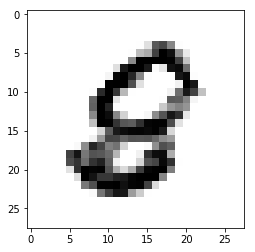

Estimate: [[-21.931211]]
Iteration: 85000 at 2019-08-19 06:40:28.825651


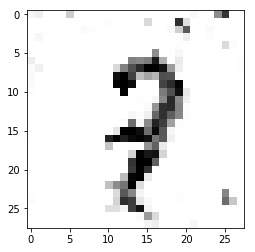

Estimate: [[-97.11509]]
Iteration: 85100 at 2019-08-19 06:40:37.404321


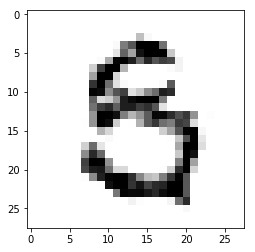

Estimate: [[22.377785]]
Iteration: 85200 at 2019-08-19 06:40:45.954868


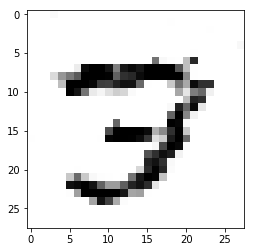

Estimate: [[-2.2814717]]
Iteration: 85300 at 2019-08-19 06:40:54.522756


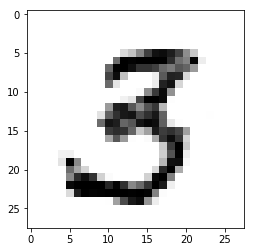

Estimate: [[11.002586]]
Iteration: 85400 at 2019-08-19 06:41:03.161090


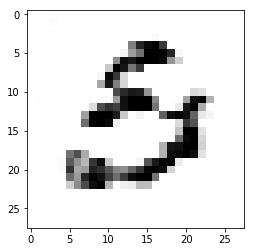

Estimate: [[-16.329813]]
Iteration: 85500 at 2019-08-19 06:41:11.844739


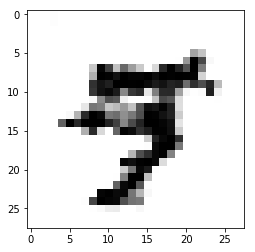

Estimate: [[-11.408242]]
Iteration: 85600 at 2019-08-19 06:41:20.399402


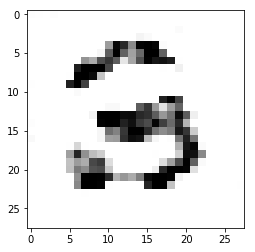

Estimate: [[1.213126]]
Iteration: 85700 at 2019-08-19 06:41:29.019296


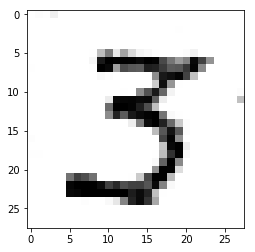

Estimate: [[3.619828]]
Iteration: 85800 at 2019-08-19 06:41:37.740793


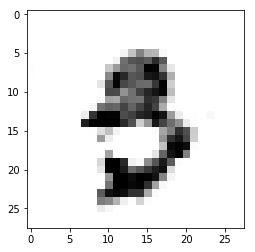

Estimate: [[-4.7066193]]
Iteration: 85900 at 2019-08-19 06:41:46.448828


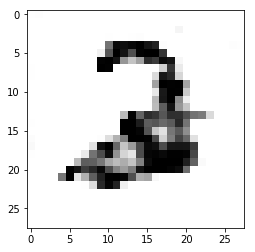

Estimate: [[14.736604]]
Iteration: 86000 at 2019-08-19 06:41:55.076386


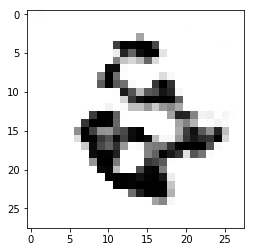

Estimate: [[7.167507]]
Iteration: 86100 at 2019-08-19 06:42:03.710129


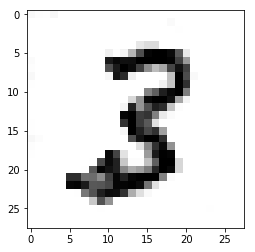

Estimate: [[-10.606372]]
Iteration: 86200 at 2019-08-19 06:42:12.354250


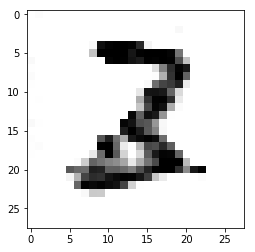

Estimate: [[-2.7632875]]
Iteration: 86300 at 2019-08-19 06:42:21.016967


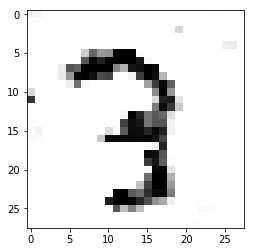

Estimate: [[3.8270612]]
Iteration: 86400 at 2019-08-19 06:42:29.703534


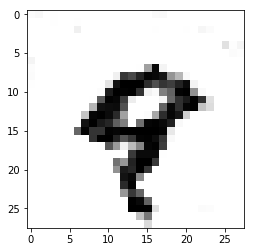

Estimate: [[-6.3701143]]
Iteration: 86500 at 2019-08-19 06:42:38.358759


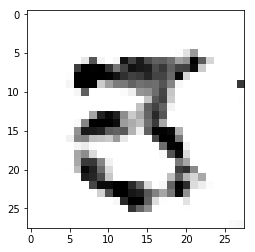

Estimate: [[13.342922]]
Iteration: 86600 at 2019-08-19 06:42:47.066620


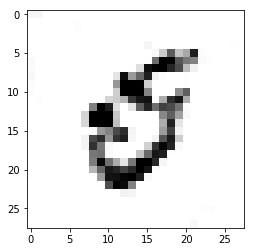

Estimate: [[33.359154]]
Iteration: 86700 at 2019-08-19 06:42:55.709668


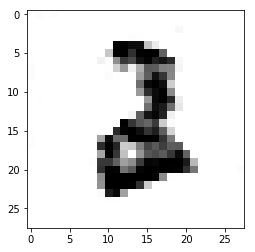

Estimate: [[-18.002348]]
Iteration: 86800 at 2019-08-19 06:43:04.380079


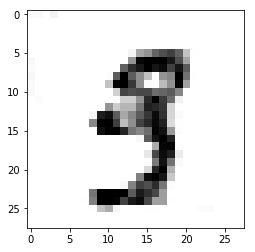

Estimate: [[-8.397723]]
Iteration: 86900 at 2019-08-19 06:43:13.068096


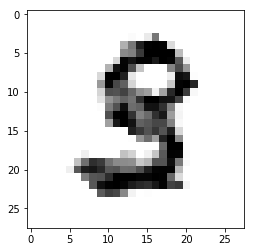

Estimate: [[-5.4483585]]
Iteration: 87000 at 2019-08-19 06:43:21.742601


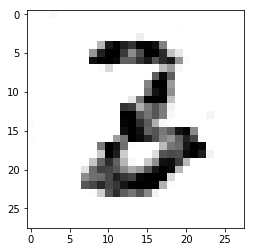

Estimate: [[48.815594]]
Iteration: 87100 at 2019-08-19 06:43:30.419816


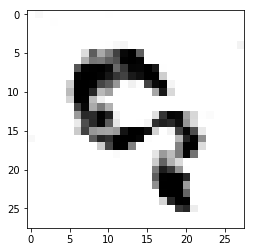

Estimate: [[22.857367]]
Iteration: 87200 at 2019-08-19 06:43:39.152467


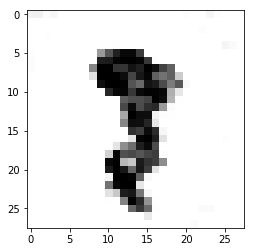

Estimate: [[35.549694]]
Iteration: 87300 at 2019-08-19 06:43:47.856759


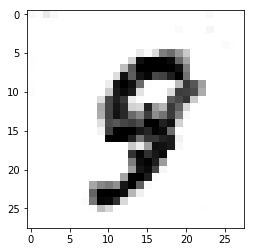

Estimate: [[-39.809055]]
Iteration: 87400 at 2019-08-19 06:43:56.554388


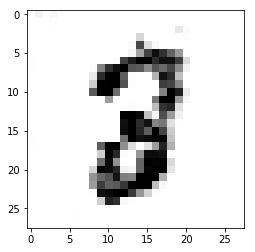

Estimate: [[6.94547]]
Iteration: 87500 at 2019-08-19 06:44:05.230380


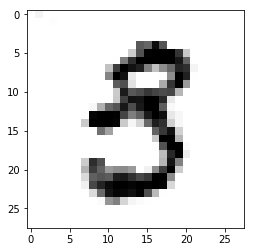

Estimate: [[0.2548179]]
Iteration: 87600 at 2019-08-19 06:44:13.988982


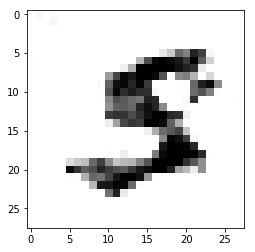

Estimate: [[-21.475266]]
Iteration: 87700 at 2019-08-19 06:44:22.769555


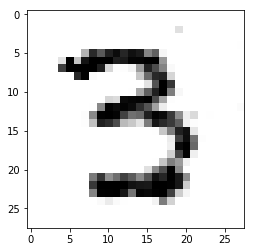

Estimate: [[5.2645617]]
Iteration: 87800 at 2019-08-19 06:44:31.582091


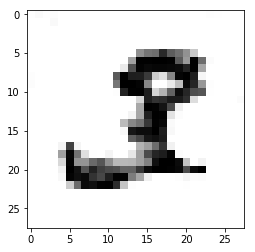

Estimate: [[7.441043]]
Iteration: 87900 at 2019-08-19 06:44:40.352479


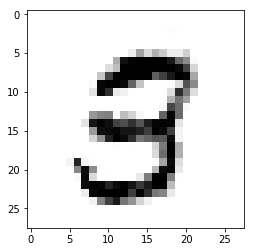

Estimate: [[0.59209996]]
Iteration: 88000 at 2019-08-19 06:44:49.107951


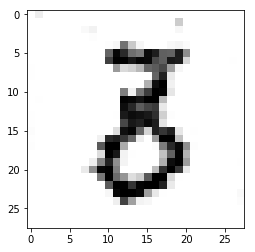

Estimate: [[-3.5801382]]
Iteration: 88100 at 2019-08-19 06:44:57.884894


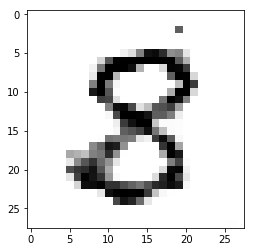

Estimate: [[5.6054254]]
Iteration: 88200 at 2019-08-19 06:45:06.643055


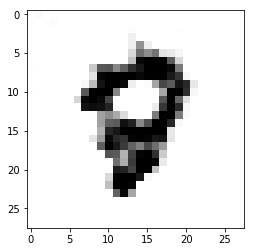

Estimate: [[11.654279]]
Iteration: 88300 at 2019-08-19 06:45:15.425411


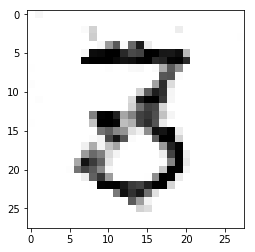

Estimate: [[1.8325361]]
Iteration: 88400 at 2019-08-19 06:45:24.211000


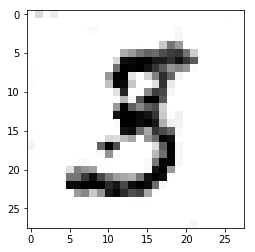

Estimate: [[-22.33835]]
Iteration: 88500 at 2019-08-19 06:45:32.991167


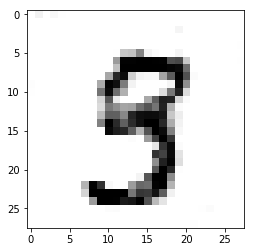

Estimate: [[0.61806196]]
Iteration: 88600 at 2019-08-19 06:45:41.783633


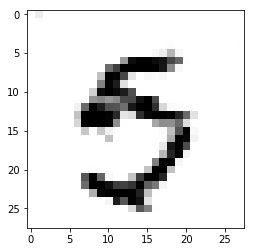

Estimate: [[-7.944085]]
Iteration: 88700 at 2019-08-19 06:45:50.643862


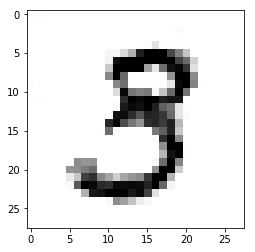

Estimate: [[-16.670155]]
Iteration: 88800 at 2019-08-19 06:45:59.519236


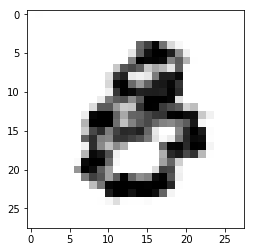

Estimate: [[-29.766808]]
Iteration: 88900 at 2019-08-19 06:46:08.394268


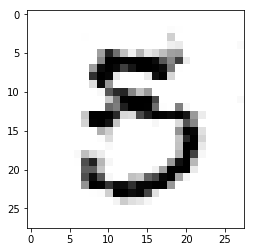

Estimate: [[-3.3811243]]
Iteration: 89000 at 2019-08-19 06:46:17.245026


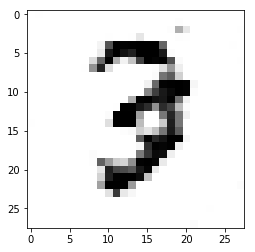

Estimate: [[27.746153]]
Iteration: 89100 at 2019-08-19 06:46:26.089057


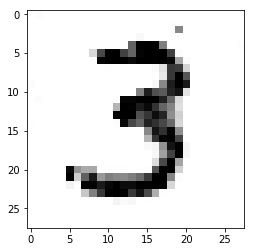

Estimate: [[36.54628]]
Iteration: 89200 at 2019-08-19 06:46:34.955019


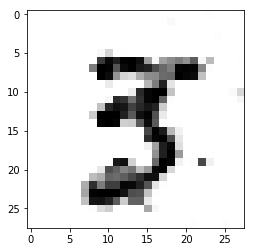

Estimate: [[-31.971792]]
Iteration: 89300 at 2019-08-19 06:46:43.858670


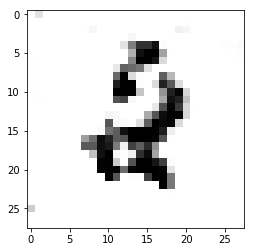

Estimate: [[-42.275177]]
Iteration: 89400 at 2019-08-19 06:46:52.861173


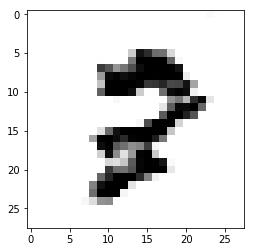

Estimate: [[1.831602]]
Iteration: 89500 at 2019-08-19 06:47:01.741435


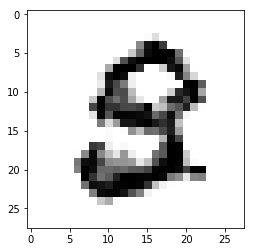

Estimate: [[-18.247833]]
Iteration: 89600 at 2019-08-19 06:47:10.656012


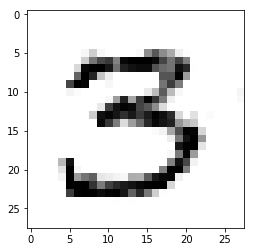

Estimate: [[16.527376]]
Iteration: 89700 at 2019-08-19 06:47:19.521263


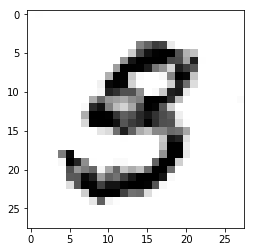

Estimate: [[-2.6513636]]
Iteration: 89800 at 2019-08-19 06:47:28.386292


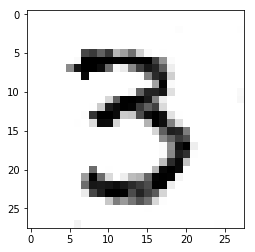

Estimate: [[-4.8665915]]
Iteration: 89900 at 2019-08-19 06:47:37.307614


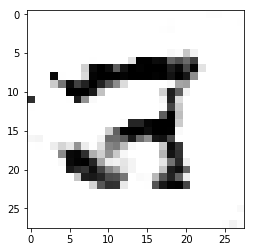

Estimate: [[33.026886]]
Iteration: 90000 at 2019-08-19 06:47:46.200344


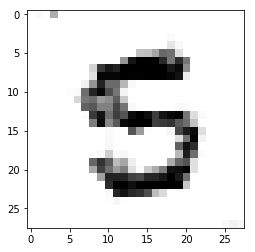

Estimate: [[8.403287]]
Iteration: 90100 at 2019-08-19 06:47:55.114122


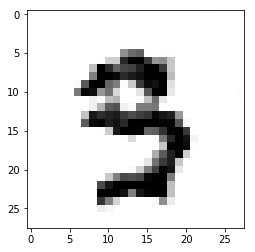

Estimate: [[-0.9522616]]
Iteration: 90200 at 2019-08-19 06:48:04.070483


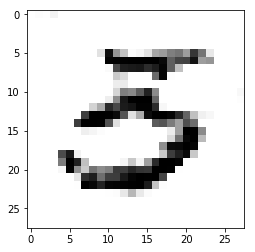

Estimate: [[-0.3791027]]
Iteration: 90300 at 2019-08-19 06:48:12.992802


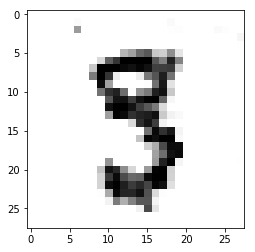

Estimate: [[6.2906327]]
Iteration: 90400 at 2019-08-19 06:48:21.912446


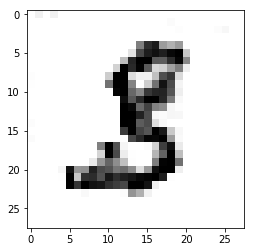

Estimate: [[13.140727]]
Iteration: 90500 at 2019-08-19 06:48:30.939329


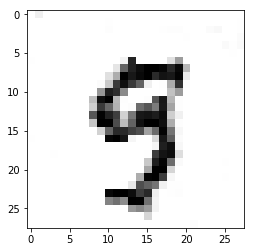

Estimate: [[-41.803585]]
Iteration: 90600 at 2019-08-19 06:48:39.856956


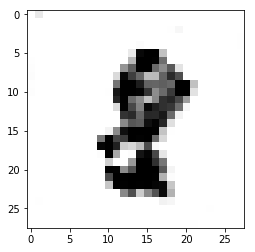

Estimate: [[1.5174363]]
Iteration: 90700 at 2019-08-19 06:48:48.826559


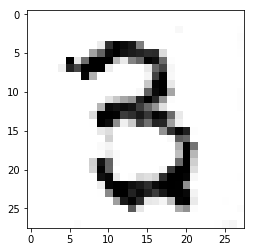

Estimate: [[-10.978877]]
Iteration: 90800 at 2019-08-19 06:48:57.783877


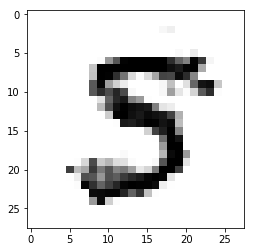

Estimate: [[1.239204]]
Iteration: 90900 at 2019-08-19 06:49:06.767888


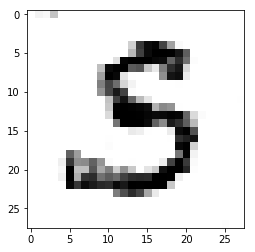

Estimate: [[-9.333323]]
Iteration: 91000 at 2019-08-19 06:49:15.759720


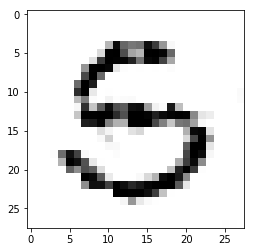

Estimate: [[42.14727]]
Iteration: 91100 at 2019-08-19 06:49:24.736352


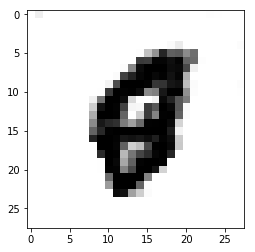

Estimate: [[-7.518951]]
Iteration: 91200 at 2019-08-19 06:49:33.739491


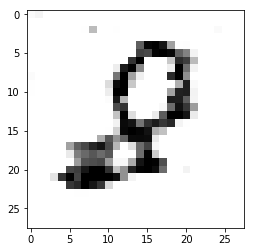

Estimate: [[13.67375]]
Iteration: 91300 at 2019-08-19 06:49:42.745129


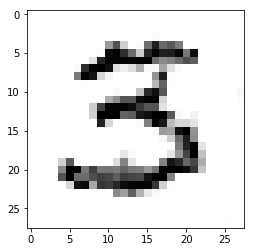

Estimate: [[-8.275425]]
Iteration: 91400 at 2019-08-19 06:49:51.853209


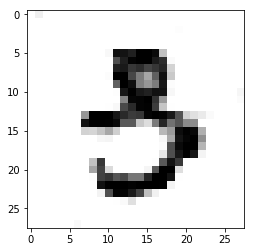

Estimate: [[6.863334]]
Iteration: 91500 at 2019-08-19 06:50:00.881424


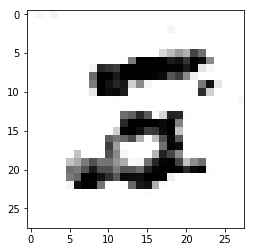

Estimate: [[-3.438797]]
Iteration: 91600 at 2019-08-19 06:50:09.891361


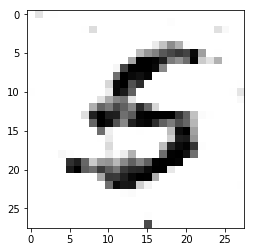

Estimate: [[-7.63629]]
Iteration: 91700 at 2019-08-19 06:50:18.899318


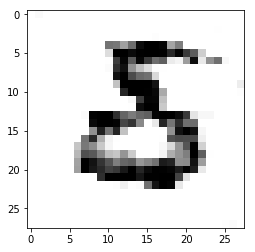

Estimate: [[27.465845]]
Iteration: 91800 at 2019-08-19 06:50:27.950782


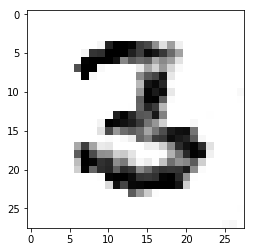

Estimate: [[2.172244]]
Iteration: 91900 at 2019-08-19 06:50:36.995163


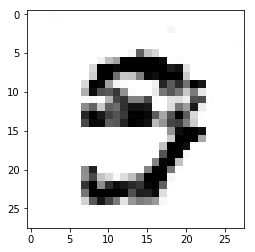

Estimate: [[-10.519361]]
Iteration: 92000 at 2019-08-19 06:50:46.030701


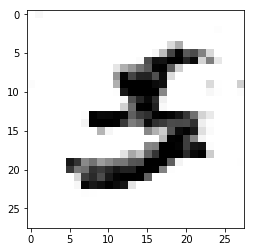

Estimate: [[16.442139]]
Iteration: 92100 at 2019-08-19 06:50:55.145259


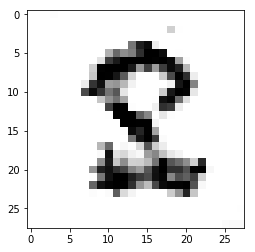

Estimate: [[16.984715]]
Iteration: 92200 at 2019-08-19 06:51:04.204882


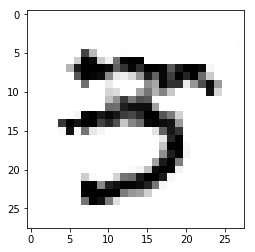

Estimate: [[-9.665384]]
Iteration: 92300 at 2019-08-19 06:51:13.341790


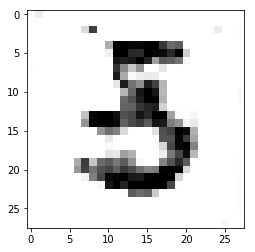

Estimate: [[21.458214]]
Iteration: 92400 at 2019-08-19 06:51:22.442443


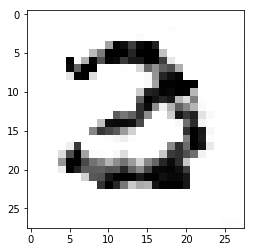

Estimate: [[-19.653637]]
Iteration: 92500 at 2019-08-19 06:51:31.514147


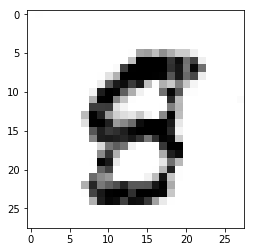

Estimate: [[-7.1205316]]
Iteration: 92600 at 2019-08-19 06:51:40.562648


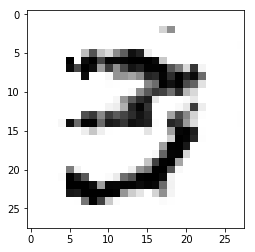

Estimate: [[-3.530851]]
Iteration: 92700 at 2019-08-19 06:51:49.679421


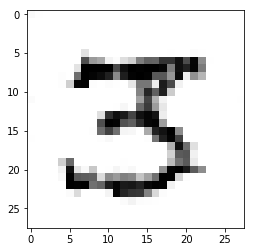

Estimate: [[-19.573719]]
Iteration: 92800 at 2019-08-19 06:51:58.957583


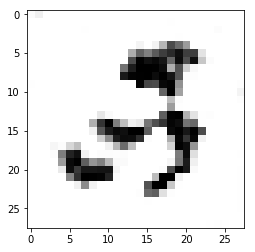

Estimate: [[-24.133617]]
Iteration: 92900 at 2019-08-19 06:52:08.074751


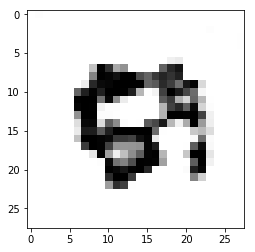

Estimate: [[89.01976]]
Iteration: 93000 at 2019-08-19 06:52:17.156585


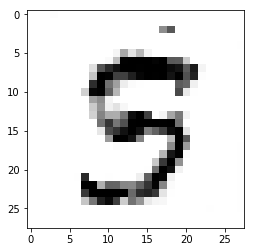

Estimate: [[13.961193]]
Iteration: 93100 at 2019-08-19 06:52:26.327338


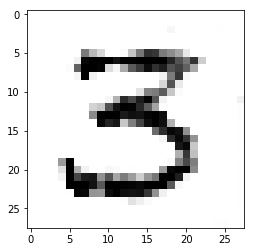

Estimate: [[-13.6496]]
Iteration: 93200 at 2019-08-19 06:52:35.604873


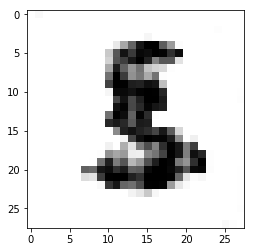

Estimate: [[14.659273]]
Iteration: 93300 at 2019-08-19 06:52:44.712265


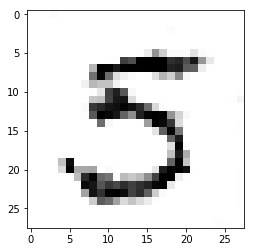

Estimate: [[19.446808]]
Iteration: 93400 at 2019-08-19 06:52:53.861943


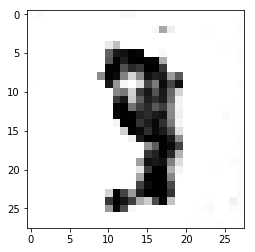

Estimate: [[-16.91569]]
Iteration: 93500 at 2019-08-19 06:53:02.998828


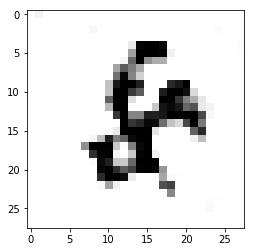

Estimate: [[41.022984]]
Iteration: 93600 at 2019-08-19 06:53:12.113682


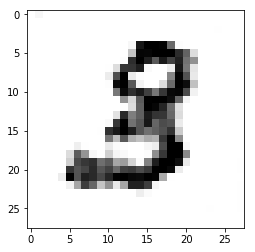

Estimate: [[0.10994935]]
Iteration: 93700 at 2019-08-19 06:53:21.214194


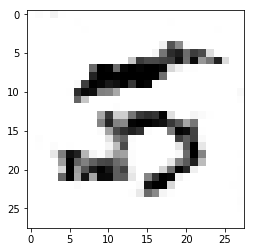

Estimate: [[5.1200886]]
Iteration: 93800 at 2019-08-19 06:53:30.363040


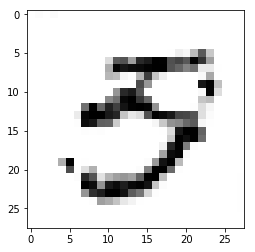

Estimate: [[25.27066]]
Iteration: 93900 at 2019-08-19 06:53:39.491784


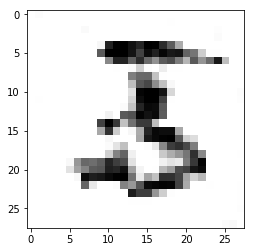

Estimate: [[-5.476389]]
Iteration: 94000 at 2019-08-19 06:53:48.709223


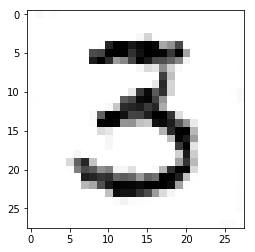

Estimate: [[0.14051363]]
Iteration: 94100 at 2019-08-19 06:53:57.942016


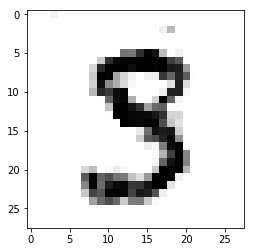

Estimate: [[35.766567]]
Iteration: 94200 at 2019-08-19 06:54:07.082297


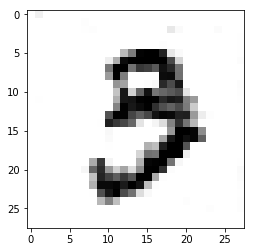

Estimate: [[4.1329546]]
Iteration: 94300 at 2019-08-19 06:54:16.332438


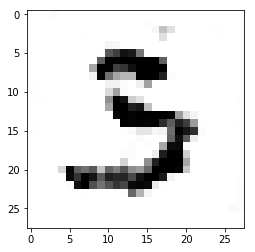

Estimate: [[26.629213]]
Iteration: 94400 at 2019-08-19 06:54:25.534571


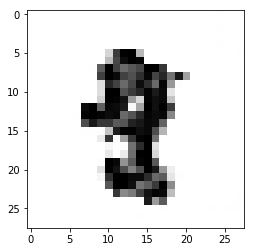

Estimate: [[7.320077]]
Iteration: 94500 at 2019-08-19 06:54:34.751218


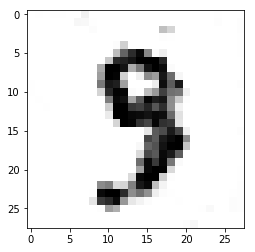

Estimate: [[24.82059]]
Iteration: 94600 at 2019-08-19 06:54:43.942066


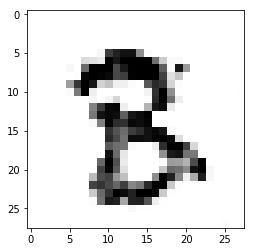

Estimate: [[-20.688852]]
Iteration: 94700 at 2019-08-19 06:54:53.153532


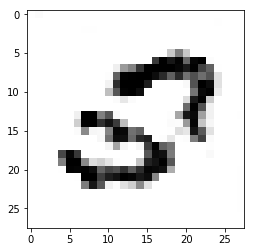

Estimate: [[40.480072]]
Iteration: 94800 at 2019-08-19 06:55:02.393984


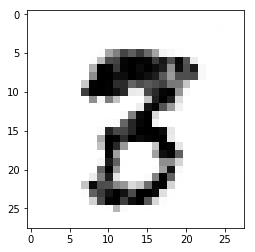

Estimate: [[-4.119714]]
Iteration: 94900 at 2019-08-19 06:55:11.660115


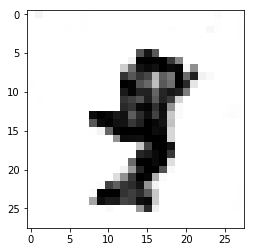

Estimate: [[26.708153]]
Iteration: 95000 at 2019-08-19 06:55:20.917239


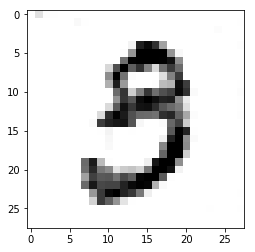

Estimate: [[13.831725]]
Iteration: 95100 at 2019-08-19 06:55:30.174522


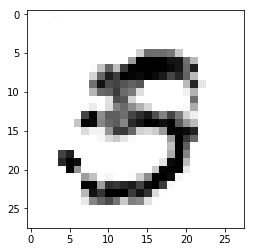

Estimate: [[14.837824]]
Iteration: 95200 at 2019-08-19 06:55:39.425580


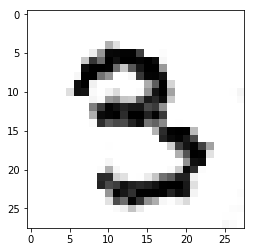

Estimate: [[18.518484]]
Iteration: 95300 at 2019-08-19 06:55:48.703486


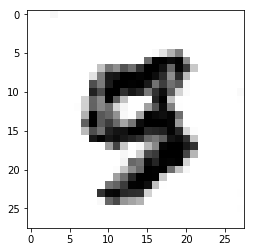

Estimate: [[-20.27946]]
Iteration: 95400 at 2019-08-19 06:55:58.110406


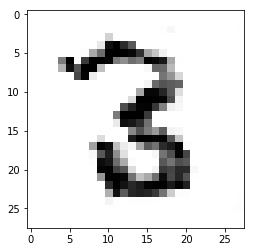

Estimate: [[15.610263]]
Iteration: 95500 at 2019-08-19 06:56:07.414264


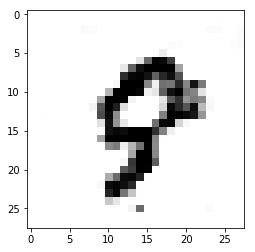

Estimate: [[-22.406874]]
Iteration: 95600 at 2019-08-19 06:56:16.697778


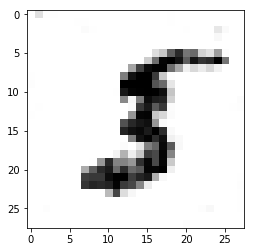

Estimate: [[-7.5453496]]
Iteration: 95700 at 2019-08-19 06:56:26.022304


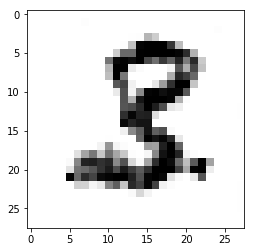

Estimate: [[-6.1173196]]
Iteration: 95800 at 2019-08-19 06:56:35.404776


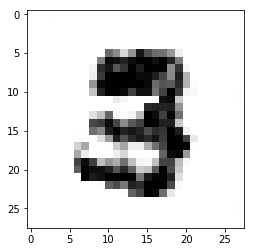

Estimate: [[-29.556087]]
Iteration: 95900 at 2019-08-19 06:56:44.712054


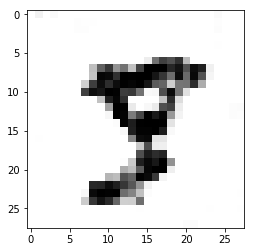

Estimate: [[-16.90694]]
Iteration: 96000 at 2019-08-19 06:56:54.022119


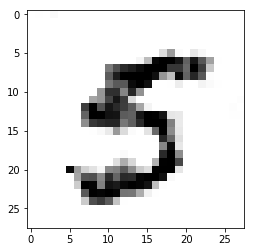

Estimate: [[12.887013]]
Iteration: 96100 at 2019-08-19 06:57:03.413600


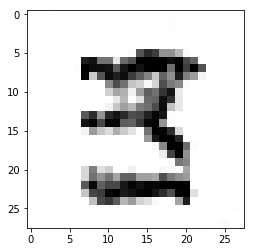

Estimate: [[-9.092645]]
Iteration: 96200 at 2019-08-19 06:57:12.859818


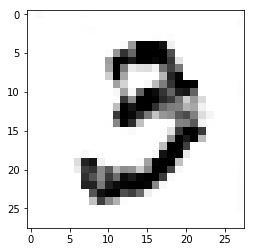

Estimate: [[12.888264]]
Iteration: 96300 at 2019-08-19 06:57:22.176520


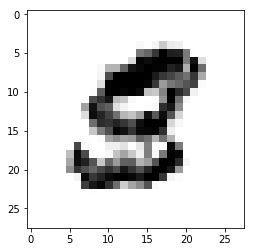

Estimate: [[-12.943181]]
Iteration: 96400 at 2019-08-19 06:57:31.544841


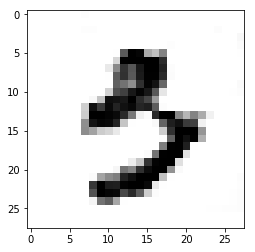

Estimate: [[-4.0410414]]
Iteration: 96500 at 2019-08-19 06:57:41.026590


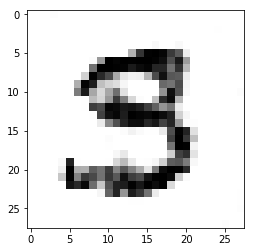

Estimate: [[10.3721075]]
Iteration: 96600 at 2019-08-19 06:57:50.517758


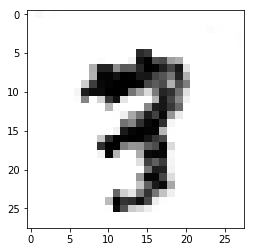

Estimate: [[15.328159]]
Iteration: 96700 at 2019-08-19 06:58:00.009940


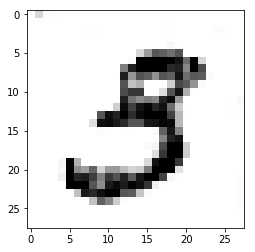

Estimate: [[-1.5661825]]
Iteration: 96800 at 2019-08-19 06:58:09.654740


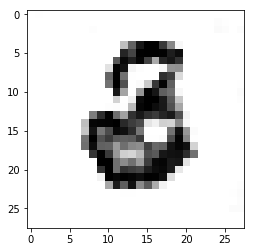

Estimate: [[23.56121]]
Iteration: 96900 at 2019-08-19 06:58:19.321772


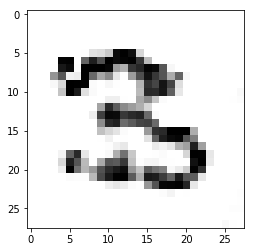

Estimate: [[14.8133]]
Iteration: 97000 at 2019-08-19 06:58:28.850364


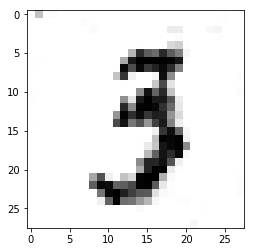

Estimate: [[1.3205619]]
Iteration: 97100 at 2019-08-19 06:58:38.237248


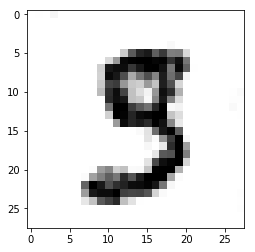

Estimate: [[-9.695674]]
Iteration: 97200 at 2019-08-19 06:58:48.824625


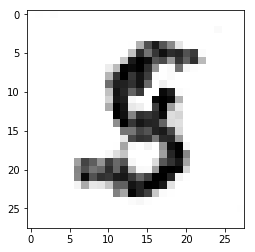

Estimate: [[4.613754]]
Iteration: 97300 at 2019-08-19 06:58:58.271873


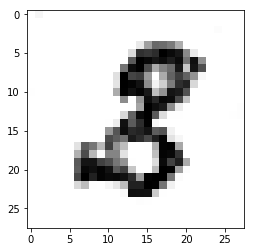

Estimate: [[7.3195686]]
Iteration: 97400 at 2019-08-19 06:59:07.674759


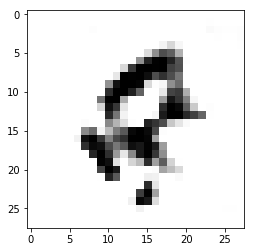

Estimate: [[-18.163637]]
Iteration: 97500 at 2019-08-19 06:59:17.173115


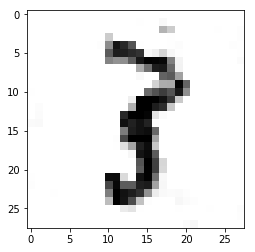

Estimate: [[-20.921108]]
Iteration: 97600 at 2019-08-19 06:59:26.742205


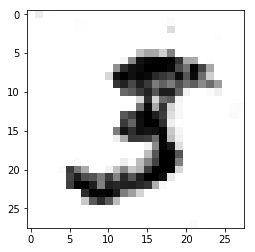

Estimate: [[-10.56737]]
Iteration: 97700 at 2019-08-19 06:59:36.214459


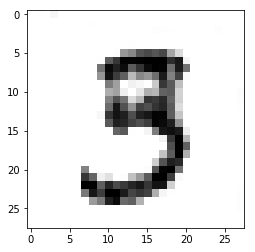

Estimate: [[4.3068943]]
Iteration: 97800 at 2019-08-19 06:59:45.687624


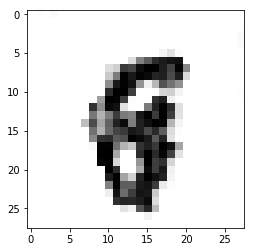

Estimate: [[-21.69989]]
Iteration: 97900 at 2019-08-19 06:59:55.153877


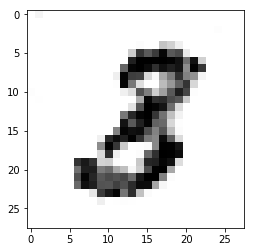

Estimate: [[-20.48029]]
Iteration: 98000 at 2019-08-19 07:00:04.610113


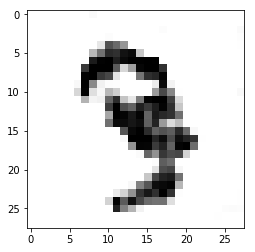

Estimate: [[15.860996]]
Iteration: 98100 at 2019-08-19 07:00:14.105163


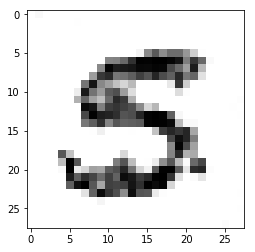

Estimate: [[-10.867]]
Iteration: 98200 at 2019-08-19 07:00:23.597233


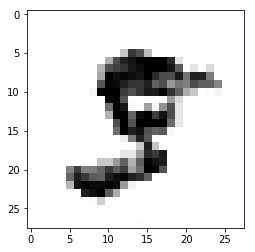

Estimate: [[12.054689]]
Iteration: 98300 at 2019-08-19 07:00:33.181543


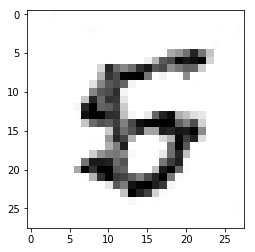

Estimate: [[83.07911]]
Iteration: 98400 at 2019-08-19 07:00:42.684604


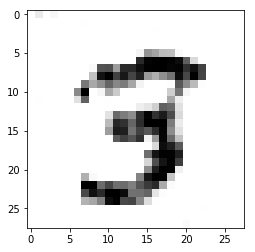

Estimate: [[-13.562687]]
Iteration: 98500 at 2019-08-19 07:00:52.211224


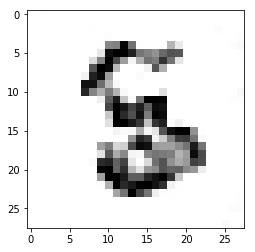

Estimate: [[45.202366]]
Iteration: 98600 at 2019-08-19 07:01:01.759643


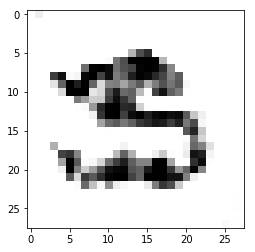

Estimate: [[-11.478358]]
Iteration: 98700 at 2019-08-19 07:01:11.322503


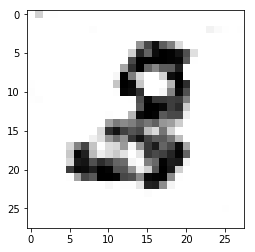

Estimate: [[-14.922629]]
Iteration: 98800 at 2019-08-19 07:01:20.881247


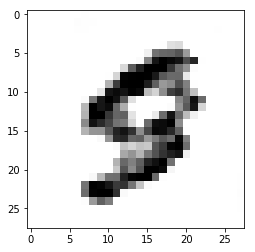

Estimate: [[5.72775]]
Iteration: 98900 at 2019-08-19 07:01:30.513432


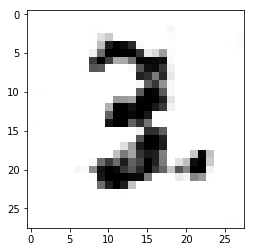

Estimate: [[36.399525]]
Iteration: 99000 at 2019-08-19 07:01:40.030457


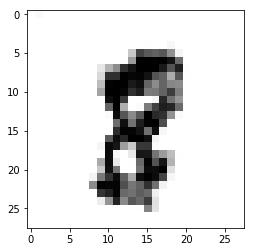

Estimate: [[40.925808]]
Iteration: 99100 at 2019-08-19 07:01:49.582034


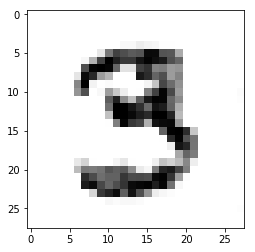

Estimate: [[-23.144793]]
Iteration: 99200 at 2019-08-19 07:01:59.194450


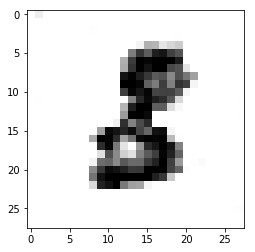

Estimate: [[18.101631]]
Iteration: 99300 at 2019-08-19 07:02:08.788899


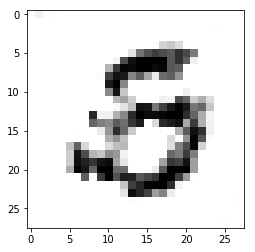

Estimate: [[20.384874]]
Iteration: 99400 at 2019-08-19 07:02:18.490447


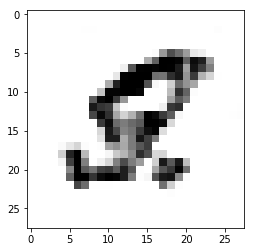

Estimate: [[-1.2199776]]
Iteration: 99500 at 2019-08-19 07:02:28.162801


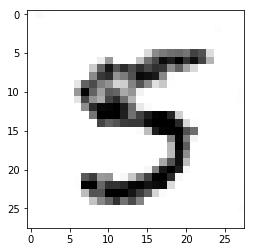

Estimate: [[-15.491459]]
Iteration: 99600 at 2019-08-19 07:02:37.766363


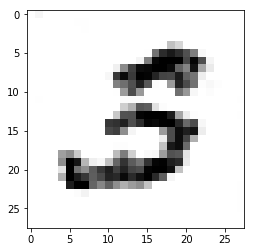

Estimate: [[-22.752726]]
Iteration: 99700 at 2019-08-19 07:02:47.391187


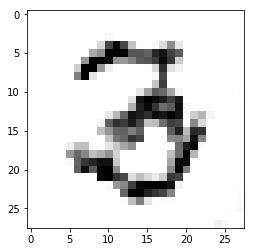

Estimate: [[-16.519703]]
Iteration: 99800 at 2019-08-19 07:02:57.048103


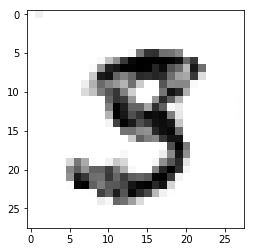

Estimate: [[-26.873955]]
Iteration: 99900 at 2019-08-19 07:03:06.678468


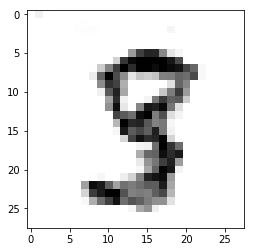

Estimate: [[22.036226]]


In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

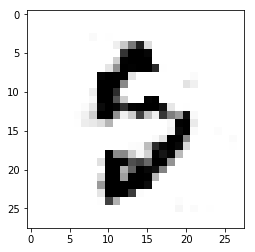

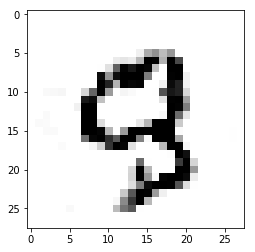

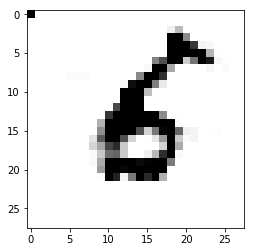

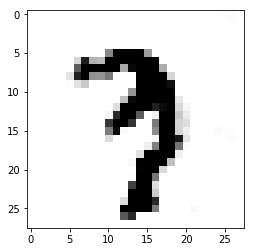

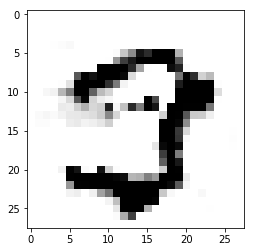

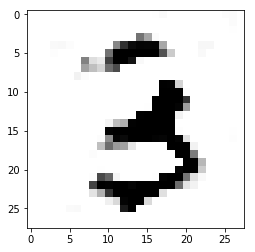

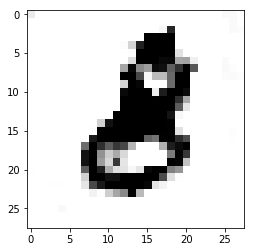

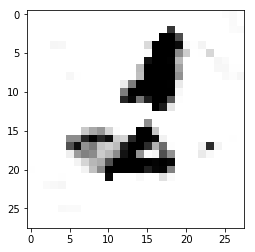

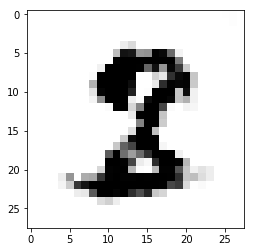

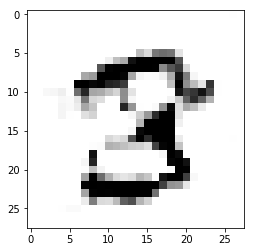

In [18]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, '/content/pretrained_gan.ckpt')
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, {z_placeholder: z_batch})
    for i in range(10):
        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')
        plt.show()